In [1]:
import jax
jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
#import keql_tools
#reload(keql_tools)
#from keql_tools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from GP_sampler import *
from plotting import *
from evaluation_metrics import *

import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize

from LM_Solve import adaptive_refine_solution

/home/josorior/miniconda3/envs/myjaxenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [2]:
## Utils
# Build interior and boundary grids
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [3]:
def get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, vmapped_rhs, seed):
    """
        Gets samples(functions) of GP. 

        Args:
            num_obs (list): List of integers of number of observed points per function.
            xy_int (jnp.array): Interior domain to get the sample.
            xy_bdy (jnp.array): Boundary domain.
            vmapped_u_true_functions (list): List of vmapped u true functions.
            vmapped_u_true_functions (list): List of vmapped f true functions.
            seed (int): Integer to fix the simulation.

        Returns:
            list: List of lists xy_obs, u_obs, f_obs.   
    """

    if len(num_obs) != len(vmapped_u_true_functions):
        raise Exception("len of list of provided observed points not same as len of list of provided functions.")
    
    num_f = len(vmapped_rhs)
    key = jax.random.PRNGKey(seed)
    seed = jax.random.randint(key=key, shape=(num_f,), minval=1, maxval=40)
    xy_obs, u_obs, f_obs =  [], [], []
    for i, num_ob in enumerate(num_obs):
        np.random.seed(seed[i])
        xy_sample_indsi = np.random.choice(list(np.arange(len(xy_int))),num_ob,replace = False)
        xy_obsi = jnp.vstack([xy_bdy,xy_int[xy_sample_indsi]])
        xy_obs.append(xy_obsi)
        u_obs.append(vmapped_u_true_functions[i](xy_obsi))
        f_obs.append(vmapped_rhs[i](xy_obsi))
    return xy_obs, u_obs, f_obs

In [4]:
# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

In [5]:
def run_exp(m, obs_pts,run):
    # Define grid to get samples from GP
    x_grid=jnp.linspace(0,1,25)
    y_grid=jnp.linspace(0,1,25)
    X,Y=jnp.meshgrid(x_grid,y_grid)
    pairs = jnp.vstack([X.ravel(), Y.ravel()]).T

    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = run
                                        )  
                                        )

    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(2*(jnp.sin(jnp.cos(2*x) + jnp.cos(2*y))))

    # Compute f = Pu for any u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 8
    # Ghost grid - Same per function
    xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
    xy_all = jnp.vstack([xy_bdy,xy_int])

    # Number of observed points per u
    num_obs = [obs_pts]*m

    xy_obs, u_obs, f_obs = get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, rhs_functions, seed=2024)

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_models = tuple([InducedRKHS(
        xy_all,
        feature_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = (xy_int,)*m

    rhs_values = tuple(rhs_func(xy_int) for rhs_func in rhs_functions)

    all_u_params_init = tuple([model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for model,model_params in zip(u_models,all_u_params_init) ])


    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

    class P_model():

        kernel_function = jit(
            get_kernel_block_ops(k_P,[eval_k],[eval_k])
        )

        num_params = len(grid_features_u_init)

        @jit
        def predict(input_data,params):
            K = P_model.kernel_function(input_data,input_data)
            return K@params
        
        def get_P_eval(input_data,params):
            def predict(prediction_points):
                K = P_model.kernel_function(prediction_points,input_data)
                return K@params
            return predict
        
    collocation_points = tuple([xy_int]*m)
    
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_int))])

    params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 501,
        init_alpha=3,
        line_search_increase_ratio=2.
    )

    p_adjusted,refinement_losses,reg_sequence = adaptive_refine_solution(params,EqnModel,1e-1,500)

    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # Estimated P from 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
    S_train = model_grid_features_all
    P_func = P_model.get_P_eval(S_train,P_sol)

    # Estimated P from 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    S_train_2 = init_P_features 
    K = P_model.kernel_function(S_train_2,S_train_2)
    P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
    P_func2 = P_model.get_P_eval(S_train_2,P_params_naive)

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])
        S_test = model_fine_features


        #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
        P_preds = P_func(S_test)
        return P_preds
    
    ########### Errors ################
    
    # In sample

    # Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
    true = [f(xy_fine_int) for f in rhs_functions]

    u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
                    for ind in range(m)]
    pred1_5 = [
        evaluate_hatP(
        P_func,
        u, xy_fine_int,feature_operators) for u in u_approx_funcs
    ]

    twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
                    for ind in range(m)]
    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
    ]
    i_smpl_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])) # RMSE
    i_smpl_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))



    # In distribution

    M = 50
    kernel_GP = get_gaussianRBF(0.5)
    # Sample M training functions from GP(0,K)
    w_train_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_train_functions = tuple([jax.vmap(w) for w in w_train_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_train_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_train_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_train_functions
    ]

    i_dis_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    i_dis_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))


    

    # Out of sample
    M = 50
    kernel_GP = get_gaussianRBF(0.2)
    # Sample M test functions from GP(0,K)
    w_test_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_test_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_test_functions
    ]

    o_dis_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    o_dis_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return i_dis_1_5, i_dis_2, o_dis_1_5, o_dis_2, i_smpl_1_5, i_smpl_2

## Structure to store the errors

We create a dictionary called `err` to store errors (nrmse) where we denote the keys as follows:

>  `1_5_mthd`: This is the main algorithm.

>  `2_obs`: This means that its parent method was trained using the observed functions at 2 points.

>  `i_dis`: List of list which contains the errors for P at the training functions.

>  `o_dis`: List of list which contains the errors for P at the testing functions.

In [6]:
err = {
    '1_5_mthd': {
        '2_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '4_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '8_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []}
                  },
    '2_mthd':   {
        '2_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '4_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '8_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []}
                }
}

In [7]:
NUM_FUN_LIST = [2,4,8,16]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]

for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_dis_1_5 = []
        i_dis_2 = []
        o_dis_1_5 = []
        o_dis_2 = []
        i_smpl_1_5 = []
        i_smpl_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp(m, obs_pt, run)
            # Append
            i_dis_1_5.append(res[0])
            i_dis_2.append(res[1])
            o_dis_1_5.append(res[2])
            o_dis_2.append(res[3])
            i_smpl_1_5.append(res[4])
            i_smpl_2.append(res[5])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_2)
        err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_2)
        err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'].append(i_smpl_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_smpl'].append(i_smpl_2)    
    # Save after 
    jnp.save('errors/err', err)

  3%|▎         | 17/501 [00:00<00:09, 49.82it/s]

Iteration 0, loss = 3.436e+03, Jres = 1.329e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 2.633e+03, Jres = 4.507e+04, alpha = 2.5, improvement_ratio = 0.2386
Iteration 2, loss = 56.21, Jres = 1.085e+05, alpha = 2.083, improvement_ratio = 0.983
Iteration 3, loss = 9.029, Jres = 1.039e+04, alpha = 1.736, improvement_ratio = 0.9951
Iteration 4, loss = 6.831, Jres = 489.1, alpha = 1.447, improvement_ratio = 1.002
Iteration 5, loss = 5.777, Jres = 31.06, alpha = 1.206, improvement_ratio = 1.004


 16%|█▌        | 81/501 [00:00<00:02, 154.03it/s]

Iteration 50, loss = 0.01124, Jres = 37.18, alpha = 0.0004747, improvement_ratio = 0.7764


 25%|██▍       | 125/501 [00:00<00:02, 186.33it/s]

Iteration 100, loss = 0.0002186, Jres = 2.466, alpha = 4.437e-05, improvement_ratio = 0.7979


 38%|███▊      | 191/501 [00:01<00:01, 207.22it/s]

Iteration 150, loss = 6.923e-05, Jres = 0.8887, alpha = 1.032e-05, improvement_ratio = 0.7366


 47%|████▋     | 236/501 [00:01<00:01, 214.47it/s]

Iteration 200, loss = 5.375e-05, Jres = 0.2561, alpha = 4.976e-06, improvement_ratio = 0.7975


 56%|█████▋    | 282/501 [00:01<00:01, 217.97it/s]

Iteration 250, loss = 5.046e-05, Jres = 0.1943, alpha = 4.147e-06, improvement_ratio = 0.7774


 65%|██████▌   | 328/501 [00:01<00:00, 219.83it/s]

Iteration 300, loss = 4.878e-05, Jres = 0.1518, alpha = 4.147e-06, improvement_ratio = 0.7902


 75%|███████▍  | 374/501 [00:02<00:00, 219.93it/s]

Iteration 350, loss = 4.772e-05, Jres = 0.1818, alpha = 3.456e-06, improvement_ratio = 0.7002


 88%|████████▊ | 442/501 [00:02<00:00, 219.65it/s]

Iteration 400, loss = 4.691e-05, Jres = 0.1483, alpha = 3.456e-06, improvement_ratio = 0.7261


 97%|█████████▋| 487/501 [00:02<00:00, 220.26it/s]

Iteration 450, loss = 4.64e-05, Jres = 0.1205, alpha = 3.456e-06, improvement_ratio = 0.7607


100%|██████████| 501/501 [00:02<00:00, 188.47it/s]


Iteration 500, loss = 4.609e-05, Jres = 0.09792, alpha = 3.456e-06, improvement_ratio = 0.797


  3%|▎         | 15/501 [00:00<00:03, 145.84it/s]

Iteration 0, loss = 2.731e+03, Jres = 909.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.881e+03, Jres = 4.42e+04, alpha = 80.0, improvement_ratio = 0.3616
Iteration 2, loss = 94.46, Jres = 1.234e+05, alpha = 16.67, improvement_ratio = 0.9776
Iteration 3, loss = 36.36, Jres = 1.132e+04, alpha = 13.89, improvement_ratio = 0.9965
Iteration 4, loss = 27.04, Jres = 619.5, alpha = 11.57, improvement_ratio = 1.004
Iteration 5, loss = 21.34, Jres = 158.8, alpha = 9.645, improvement_ratio = 1.004


 16%|█▋        | 82/501 [00:00<00:02, 208.83it/s]

Iteration 50, loss = 0.04349, Jres = 8.451, alpha = 0.002637, improvement_ratio = 0.9854


 25%|██▌       | 126/501 [00:00<00:01, 212.88it/s]

Iteration 100, loss = 0.001546, Jres = 12.19, alpha = 0.0001189, improvement_ratio = 0.8129


 38%|███▊      | 192/501 [00:00<00:01, 215.25it/s]

Iteration 150, loss = 0.00033, Jres = 4.64, alpha = 3.981e-05, improvement_ratio = 0.776


 47%|████▋     | 236/501 [00:01<00:01, 214.09it/s]

Iteration 200, loss = 0.0001151, Jres = 2.419, alpha = 1.6e-05, improvement_ratio = 0.7596


 56%|█████▌    | 280/501 [00:01<00:01, 215.22it/s]

Iteration 250, loss = 6.352e-05, Jres = 1.099, alpha = 6.429e-06, improvement_ratio = 0.7538


 65%|██████▍   | 324/501 [00:01<00:00, 213.41it/s]

Iteration 300, loss = 5.469e-05, Jres = 0.4095, alpha = 2.584e-06, improvement_ratio = 0.7236


 78%|███████▊  | 390/501 [00:01<00:00, 214.24it/s]

Iteration 350, loss = 5.335e-05, Jres = 0.2454, alpha = 1.794e-06, improvement_ratio = 0.7419


 87%|████████▋ | 434/501 [00:02<00:00, 214.92it/s]

Iteration 400, loss = 5.3e-05, Jres = 0.1684, alpha = 1.495e-06, improvement_ratio = 0.7846


 96%|█████████▌| 480/501 [00:02<00:00, 218.57it/s]

Iteration 450, loss = 5.297e-05, Jres = 0.1428, alpha = 1.038e-06, improvement_ratio = 0.765


100%|██████████| 501/501 [00:02<00:00, 212.92it/s]


Iteration 500, loss = 5.308e-05, Jres = 0.05738, alpha = 8.333e-07, improvement_ratio = 0.894


  4%|▍         | 22/501 [00:00<00:02, 210.74it/s]

Iteration 0, loss = 1.421e+03, Jres = 1.005e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 891.9, Jres = 3.387e+04, alpha = 2.5, improvement_ratio = 0.3803
Iteration 2, loss = 21.06, Jres = 6.01e+04, alpha = 2.083, improvement_ratio = 0.9843
Iteration 3, loss = 5.758, Jres = 5.189e+03, alpha = 1.736, improvement_ratio = 0.9944
Iteration 4, loss = 4.425, Jres = 227.6, alpha = 1.447, improvement_ratio = 1.005
Iteration 5, loss = 3.749, Jres = 50.02, alpha = 1.206, improvement_ratio = 1.003


 17%|█▋        | 87/501 [00:00<00:01, 208.44it/s]

Iteration 50, loss = 0.005073, Jres = 20.85, alpha = 0.0003956, improvement_ratio = 0.8297


 26%|██▌       | 131/501 [00:00<00:01, 212.27it/s]

Iteration 100, loss = 0.0002614, Jres = 3.659, alpha = 5.324e-05, improvement_ratio = 0.8068


 35%|███▍      | 175/501 [00:00<00:01, 213.31it/s]

Iteration 150, loss = 6.376e-05, Jres = 1.892, alpha = 1.783e-05, improvement_ratio = 0.7415


 48%|████▊     | 241/501 [00:01<00:01, 213.99it/s]

Iteration 200, loss = 3.203e-05, Jres = 0.5245, alpha = 5.971e-06, improvement_ratio = 0.8081


 57%|█████▋    | 285/501 [00:01<00:01, 214.15it/s]

Iteration 250, loss = 2.815e-05, Jres = 0.1989, alpha = 2.88e-06, improvement_ratio = 0.6555


 66%|██████▌   | 329/501 [00:01<00:00, 214.28it/s]

Iteration 300, loss = 2.696e-05, Jres = 0.1565, alpha = 2.4e-06, improvement_ratio = 0.7657


 74%|███████▍  | 373/501 [00:01<00:00, 214.37it/s]

Iteration 350, loss = 2.646e-05, Jres = 0.1151, alpha = 2e-06, improvement_ratio = 0.7635


 88%|████████▊ | 439/501 [00:02<00:00, 214.47it/s]

Iteration 400, loss = 2.625e-05, Jres = 0.09994, alpha = 1.666e-06, improvement_ratio = 0.7421


 96%|█████████▋| 483/501 [00:02<00:00, 214.41it/s]

Iteration 450, loss = 2.617e-05, Jres = 0.09142, alpha = 1.389e-06, improvement_ratio = 0.7228


100%|██████████| 501/501 [00:02<00:00, 213.10it/s]


Iteration 500, loss = 2.615e-05, Jres = 0.08603, alpha = 1.157e-06, improvement_ratio = 0.7048


  8%|▊         | 42/501 [00:00<00:02, 208.81it/s]

Iteration 0, loss = 2.621e+03, Jres = 1.022e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 2.199e+03, Jres = 3.595e+04, alpha = 6.0, improvement_ratio = 0.1698
Iteration 2, loss = 67.19, Jres = 9.684e+04, alpha = 5.0, improvement_ratio = 0.9834
Iteration 3, loss = 25.27, Jres = 8.78e+03, alpha = 4.167, improvement_ratio = 0.9955
Iteration 4, loss = 19.2, Jres = 400.0, alpha = 3.472, improvement_ratio = 1.011
Iteration 5, loss = 14.74, Jres = 235.0, alpha = 2.894, improvement_ratio = 1.009


 17%|█▋        | 85/501 [00:00<00:01, 208.43it/s]

Iteration 50, loss = 0.0238, Jres = 17.57, alpha = 0.0007912, improvement_ratio = 0.8386


 26%|██▌       | 129/501 [00:00<00:01, 210.37it/s]

Iteration 100, loss = 0.0007985, Jres = 7.229, alpha = 7.395e-05, improvement_ratio = 0.7196


 35%|███▍      | 173/501 [00:00<00:01, 210.76it/s]

Iteration 150, loss = 9.389e-05, Jres = 1.696, alpha = 1.194e-05, improvement_ratio = 0.7662


 48%|████▊     | 239/501 [00:01<00:01, 211.54it/s]

Iteration 200, loss = 5.335e-05, Jres = 0.5, alpha = 5.759e-06, improvement_ratio = 0.7966


 56%|█████▋    | 283/501 [00:01<00:01, 212.78it/s]

Iteration 250, loss = 4.828e-05, Jres = 0.2904, alpha = 2.777e-06, improvement_ratio = 0.7189


 65%|██████▌   | 327/501 [00:01<00:00, 213.05it/s]

Iteration 300, loss = 4.74e-05, Jres = 0.1964, alpha = 1.929e-06, improvement_ratio = 0.7096


 79%|███████▉  | 395/501 [00:01<00:00, 216.93it/s]

Iteration 350, loss = 4.736e-05, Jres = 0.1508, alpha = 1.607e-06, improvement_ratio = 0.7089


 88%|████████▊ | 440/501 [00:02<00:00, 218.65it/s]

Iteration 400, loss = 4.753e-05, Jres = 0.09185, alpha = 1.607e-06, improvement_ratio = 0.7924


 97%|█████████▋| 485/501 [00:02<00:00, 219.53it/s]

Iteration 450, loss = 4.779e-05, Jres = 0.07728, alpha = 1.339e-06, improvement_ratio = 0.7938


100%|██████████| 501/501 [00:02<00:00, 214.07it/s]


Iteration 500, loss = 4.807e-05, Jres = 0.07836, alpha = 1e-06, improvement_ratio = 0.7548


  8%|▊         | 41/501 [00:00<00:02, 203.67it/s]

Iteration 0, loss = 1.738e+03, Jres = 928.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.467e+03, Jres = 3.45e+04, alpha = 12.0, improvement_ratio = 0.1688
Iteration 2, loss = 59.85, Jres = 9.126e+04, alpha = 10.0, improvement_ratio = 0.9764
Iteration 3, loss = 18.15, Jres = 9.275e+03, alpha = 8.333, improvement_ratio = 0.9969
Iteration 4, loss = 13.71, Jres = 712.6, alpha = 6.944, improvement_ratio = 1.011
Iteration 5, loss = 11.37, Jres = 171.7, alpha = 5.787, improvement_ratio = 1.009


 17%|█▋        | 86/501 [00:00<00:01, 213.80it/s]

Iteration 50, loss = 0.0207, Jres = 2.762, alpha = 0.001582, improvement_ratio = 0.9867


 26%|██▌       | 130/501 [00:00<00:01, 216.39it/s]

Iteration 100, loss = 0.001015, Jres = 9.298, alpha = 8.559e-05, improvement_ratio = 0.778


 35%|███▍      | 174/501 [00:00<00:01, 217.94it/s]

Iteration 150, loss = 0.0001768, Jres = 1.955, alpha = 1.99e-05, improvement_ratio = 0.8034


 48%|████▊     | 242/501 [00:01<00:01, 218.73it/s]

Iteration 200, loss = 8.055e-05, Jres = 1.812, alpha = 1.382e-05, improvement_ratio = 0.7647


 57%|█████▋    | 286/501 [00:01<00:00, 219.01it/s]

Iteration 250, loss = 5.369e-05, Jres = 1.043, alpha = 7.999e-06, improvement_ratio = 0.7916


 66%|██████▌   | 331/501 [00:01<00:00, 218.65it/s]

Iteration 300, loss = 4.559e-05, Jres = 0.5355, alpha = 2.232e-06, improvement_ratio = 0.667


 75%|███████▌  | 376/501 [00:01<00:00, 219.34it/s]

Iteration 350, loss = 4.254e-05, Jres = 0.2818, alpha = 1.292e-06, improvement_ratio = 0.6895


 88%|████████▊ | 443/501 [00:02<00:00, 219.28it/s]

Iteration 400, loss = 4.127e-05, Jres = 0.3119, alpha = 1.292e-06, improvement_ratio = 0.6598


 97%|█████████▋| 488/501 [00:02<00:00, 219.72it/s]

Iteration 450, loss = 4.05e-05, Jres = 0.1579, alpha = 1.292e-06, improvement_ratio = 0.7835


100%|██████████| 501/501 [00:02<00:00, 217.56it/s]


Iteration 500, loss = 3.994e-05, Jres = 0.05445, alpha = 1.077e-06, improvement_ratio = 0.7962


  4%|▍         | 20/501 [00:00<00:02, 196.97it/s]

Iteration 0, loss = 1.55e+03, Jres = 819.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.207e+03, Jres = 3.578e+04, alpha = 10.0, improvement_ratio = 0.2283
Iteration 2, loss = 38.44, Jres = 9.181e+04, alpha = 8.333, improvement_ratio = 0.9767
Iteration 3, loss = 8.531, Jres = 9.606e+03, alpha = 6.944, improvement_ratio = 0.9936
Iteration 4, loss = 6.255, Jres = 499.4, alpha = 5.787, improvement_ratio = 1.005
Iteration 5, loss = 4.946, Jres = 49.23, alpha = 4.823, improvement_ratio = 1.004


 17%|█▋        | 85/501 [00:00<00:01, 212.16it/s]

Iteration 50, loss = 0.01763, Jres = 13.45, alpha = 0.001319, improvement_ratio = 0.9386


 26%|██▌       | 131/501 [00:00<00:01, 220.34it/s]

Iteration 100, loss = 0.0001886, Jres = 4.281, alpha = 5.943e-05, improvement_ratio = 0.7992


 35%|███▌      | 177/501 [00:00<00:01, 222.64it/s]

Iteration 150, loss = 4.104e-05, Jres = 0.8728, alpha = 1.382e-05, improvement_ratio = 0.81


 45%|████▍     | 223/501 [00:01<00:01, 221.75it/s]

Iteration 200, loss = 2.971e-05, Jres = 0.3148, alpha = 4.629e-06, improvement_ratio = 0.7503


 58%|█████▊    | 292/501 [00:01<00:00, 223.27it/s]

Iteration 250, loss = 2.768e-05, Jres = 0.1586, alpha = 3.858e-06, improvement_ratio = 0.7636


 67%|██████▋   | 338/501 [00:01<00:00, 224.23it/s]

Iteration 300, loss = 2.688e-05, Jres = 0.1329, alpha = 3.215e-06, improvement_ratio = 0.7115


 77%|███████▋  | 384/501 [00:01<00:00, 223.81it/s]

Iteration 350, loss = 2.642e-05, Jres = 0.08754, alpha = 3.215e-06, improvement_ratio = 0.7669


 86%|████████▌ | 430/501 [00:01<00:00, 221.91it/s]

Iteration 400, loss = 2.616e-05, Jres = 0.08827, alpha = 2.679e-06, improvement_ratio = 0.7298


 95%|█████████▌| 476/501 [00:02<00:00, 220.94it/s]

Iteration 450, loss = 2.602e-05, Jres = 0.06266, alpha = 2.232e-06, improvement_ratio = 0.6476


100%|██████████| 501/501 [00:02<00:00, 220.14it/s]


Iteration 500, loss = 2.596e-05, Jres = 0.06271, alpha = 2.232e-06, improvement_ratio = 0.7923


  8%|▊         | 40/501 [00:00<00:02, 201.95it/s]

Iteration 0, loss = 1.374e+03, Jres = 1.008e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 773.3, Jres = 3.573e+04, alpha = 80.0, improvement_ratio = 0.5222
Iteration 2, loss = 66.2, Jres = 7.402e+04, alpha = 16.67, improvement_ratio = 0.962
Iteration 3, loss = 24.42, Jres = 8.424e+03, alpha = 13.89, improvement_ratio = 0.9988
Iteration 4, loss = 15.73, Jres = 572.8, alpha = 11.57, improvement_ratio = 1.017
Iteration 5, loss = 11.63, Jres = 175.2, alpha = 9.645, improvement_ratio = 1.014


 17%|█▋        | 84/501 [00:00<00:01, 213.94it/s]

Iteration 50, loss = 0.02574, Jres = 4.626, alpha = 0.002637, improvement_ratio = 0.9867


 26%|██▌       | 128/501 [00:00<00:01, 215.47it/s]

Iteration 100, loss = 0.001978, Jres = 14.57, alpha = 0.0002465, improvement_ratio = 0.7761


 39%|███▉      | 195/501 [00:00<00:01, 218.22it/s]

Iteration 150, loss = 0.000381, Jres = 6.268, alpha = 8.255e-05, improvement_ratio = 0.8079


 48%|████▊     | 241/501 [00:01<00:01, 221.13it/s]

Iteration 200, loss = 0.0001065, Jres = 3.905, alpha = 3.317e-05, improvement_ratio = 0.759


 57%|█████▋    | 287/501 [00:01<00:00, 220.50it/s]

Iteration 250, loss = 5.379e-05, Jres = 2.046, alpha = 1.333e-05, improvement_ratio = 0.7297


 66%|██████▋   | 333/501 [00:01<00:00, 220.15it/s]

Iteration 300, loss = 4.03e-05, Jres = 1.135, alpha = 7.715e-06, improvement_ratio = 0.7245


 75%|███████▌  | 378/501 [00:01<00:00, 219.84it/s]

Iteration 350, loss = 3.541e-05, Jres = 0.8208, alpha = 5.358e-06, improvement_ratio = 0.7081


 89%|████████▊ | 444/501 [00:02<00:00, 219.72it/s]

Iteration 400, loss = 3.288e-05, Jres = 0.6682, alpha = 4.465e-06, improvement_ratio = 0.7118


 98%|█████████▊| 489/501 [00:02<00:00, 220.02it/s]

Iteration 450, loss = 3.114e-05, Jres = 0.4891, alpha = 4.465e-06, improvement_ratio = 0.7761


100%|██████████| 501/501 [00:02<00:00, 217.74it/s]


Iteration 500, loss = 2.984e-05, Jres = 0.5066, alpha = 3.721e-06, improvement_ratio = 0.7583


  8%|▊         | 41/501 [00:00<00:02, 200.31it/s]

Iteration 0, loss = 1.4e+03, Jres = 863.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.111e+03, Jres = 2.502e+04, alpha = 10.0, improvement_ratio = 0.2224
Iteration 2, loss = 56.49, Jres = 6.364e+04, alpha = 8.333, improvement_ratio = 0.9801
Iteration 3, loss = 28.65, Jres = 5.995e+03, alpha = 6.944, improvement_ratio = 0.9933
Iteration 4, loss = 22.05, Jres = 322.7, alpha = 5.787, improvement_ratio = 1.014
Iteration 5, loss = 17.28, Jres = 129.7, alpha = 4.823, improvement_ratio = 1.018


 17%|█▋        | 85/501 [00:00<00:01, 211.06it/s]

Iteration 50, loss = 0.01717, Jres = 17.03, alpha = 0.001319, improvement_ratio = 0.8823


 26%|██▌       | 129/501 [00:00<00:01, 214.50it/s]

Iteration 100, loss = 0.0002227, Jres = 3.713, alpha = 4.127e-05, improvement_ratio = 0.6909


 35%|███▍      | 174/501 [00:00<00:01, 217.32it/s]

Iteration 150, loss = 4.242e-05, Jres = 0.822, alpha = 7.999e-06, improvement_ratio = 0.7664


 48%|████▊     | 240/501 [00:01<00:01, 216.75it/s]

Iteration 200, loss = 3.021e-05, Jres = 0.3664, alpha = 4.629e-06, improvement_ratio = 0.7843


 57%|█████▋    | 285/501 [00:01<00:00, 218.26it/s]

Iteration 250, loss = 2.605e-05, Jres = 0.2564, alpha = 1.86e-06, improvement_ratio = 0.7378


 66%|██████▌   | 331/501 [00:01<00:00, 220.51it/s]

Iteration 300, loss = 2.51e-05, Jres = 0.111, alpha = 1.077e-06, improvement_ratio = 0.7669


 75%|███████▌  | 376/501 [00:01<00:00, 217.73it/s]

Iteration 350, loss = 2.504e-05, Jres = 0.0363, alpha = 8.333e-07, improvement_ratio = 0.8957


 88%|████████▊ | 442/501 [00:02<00:00, 217.71it/s]

Iteration 400, loss = 2.507e-05, Jres = 0.01107, alpha = 8.333e-07, improvement_ratio = 0.9684


 97%|█████████▋| 486/501 [00:02<00:00, 217.47it/s]

Iteration 450, loss = 2.511e-05, Jres = 0.003694, alpha = 8.333e-07, improvement_ratio = 0.9899


100%|██████████| 501/501 [00:02<00:00, 216.05it/s]


Iteration 500, loss = 2.513e-05, Jres = 0.001346, alpha = 8.333e-07, improvement_ratio = 0.9963


  9%|▊         | 43/501 [00:00<00:02, 210.46it/s]

Iteration 0, loss = 992.9, Jres = 599.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 824.8, Jres = 1.8e+04, alpha = 6.0, improvement_ratio = 0.1803
Iteration 2, loss = 39.23, Jres = 4.65e+04, alpha = 5.0, improvement_ratio = 0.981
Iteration 3, loss = 18.94, Jres = 4.402e+03, alpha = 4.167, improvement_ratio = 0.9984
Iteration 4, loss = 13.82, Jres = 200.2, alpha = 3.472, improvement_ratio = 1.024
Iteration 5, loss = 10.35, Jres = 61.8, alpha = 2.894, improvement_ratio = 1.022


 18%|█▊        | 88/501 [00:00<00:01, 216.63it/s]

Iteration 50, loss = 0.01104, Jres = 16.35, alpha = 0.0007912, improvement_ratio = 0.8203


 27%|██▋       | 134/501 [00:00<00:01, 220.19it/s]

Iteration 100, loss = 0.0004628, Jres = 4.869, alpha = 7.395e-05, improvement_ratio = 0.8013


 36%|███▌      | 180/501 [00:00<00:01, 220.79it/s]

Iteration 150, loss = 8.266e-05, Jres = 1.545, alpha = 1.72e-05, improvement_ratio = 0.7565


 45%|████▌     | 226/501 [00:01<00:01, 221.29it/s]

Iteration 200, loss = 3.559e-05, Jres = 0.5124, alpha = 6.911e-06, improvement_ratio = 0.7997


 59%|█████▉    | 295/501 [00:01<00:00, 220.95it/s]

Iteration 250, loss = 2.855e-05, Jres = 0.1489, alpha = 1.929e-06, improvement_ratio = 0.7961


 68%|██████▊   | 340/501 [00:01<00:00, 217.96it/s]

Iteration 300, loss = 2.761e-05, Jres = 0.06009, alpha = 8.333e-07, improvement_ratio = 0.8216


 77%|███████▋  | 384/501 [00:01<00:00, 216.19it/s]

Iteration 350, loss = 2.738e-05, Jres = 0.01368, alpha = 8.333e-07, improvement_ratio = 0.9588


 85%|████████▌ | 428/501 [00:01<00:00, 216.05it/s]

Iteration 400, loss = 2.733e-05, Jres = 0.005545, alpha = 8.333e-07, improvement_ratio = 0.9861


 95%|█████████▍| 474/501 [00:02<00:00, 218.12it/s]

Iteration 450, loss = 2.731e-05, Jres = 0.002801, alpha = 8.333e-07, improvement_ratio = 0.994


100%|██████████| 501/501 [00:02<00:00, 218.18it/s]


Iteration 500, loss = 2.73e-05, Jres = 0.001575, alpha = 8.333e-07, improvement_ratio = 0.9973


  8%|▊         | 39/501 [00:00<00:02, 193.94it/s]

Iteration 0, loss = 1.192e+03, Jres = 750.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 517.1, Jres = 1.367e+04, alpha = 10.0, improvement_ratio = 0.7183
Iteration 2, loss = 47.27, Jres = 2.431e+04, alpha = 8.333, improvement_ratio = 0.9828
Iteration 3, loss = 27.14, Jres = 2.432e+03, alpha = 6.944, improvement_ratio = 0.9991
Iteration 4, loss = 22.1, Jres = 209.2, alpha = 5.787, improvement_ratio = 1.007
Iteration 5, loss = 18.74, Jres = 68.49, alpha = 4.823, improvement_ratio = 1.006


 16%|█▋        | 82/501 [00:00<00:02, 205.88it/s]

Iteration 50, loss = 0.02068, Jres = 5.53, alpha = 0.001319, improvement_ratio = 0.9596


 25%|██▌       | 126/501 [00:00<00:01, 210.52it/s]

Iteration 100, loss = 0.0003854, Jres = 3.431, alpha = 4.953e-05, improvement_ratio = 0.7698


 38%|███▊      | 192/501 [00:00<00:01, 214.31it/s]

Iteration 150, loss = 8.784e-05, Jres = 0.8433, alpha = 1.382e-05, improvement_ratio = 0.7402


 48%|████▊     | 238/501 [00:01<00:01, 219.25it/s]

Iteration 200, loss = 4.504e-05, Jres = 0.295, alpha = 6.666e-06, improvement_ratio = 0.7823


 56%|█████▋    | 283/501 [00:01<00:00, 219.80it/s]

Iteration 250, loss = 3.703e-05, Jres = 0.153, alpha = 3.858e-06, improvement_ratio = 0.7555


 66%|██████▌   | 329/501 [00:01<00:00, 220.42it/s]

Iteration 300, loss = 3.493e-05, Jres = 0.07705, alpha = 3.215e-06, improvement_ratio = 0.7921


 75%|███████▍  | 375/501 [00:01<00:00, 220.09it/s]

Iteration 350, loss = 3.414e-05, Jres = 0.0781, alpha = 2.232e-06, improvement_ratio = 0.7127


 89%|████████▊ | 444/501 [00:02<00:00, 221.31it/s]

Iteration 400, loss = 3.377e-05, Jres = 0.05919, alpha = 1.86e-06, improvement_ratio = 0.7629


 98%|█████████▊| 490/501 [00:02<00:00, 221.63it/s]

Iteration 450, loss = 3.361e-05, Jres = 0.06246, alpha = 1.292e-06, improvement_ratio = 0.7343


100%|██████████| 501/501 [00:02<00:00, 216.34it/s]


Iteration 500, loss = 3.359e-05, Jres = 0.04321, alpha = 8.972e-07, improvement_ratio = 0.8003


  1%|▏         | 7/501 [00:00<00:16, 29.83it/s]

Iteration 0, loss = 1.882e+03, Jres = 755.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.197e+03, Jres = 1.339e+04, alpha = 10.0, improvement_ratio = 0.4113
Iteration 2, loss = 88.89, Jres = 3.63e+04, alpha = 8.333, improvement_ratio = 0.9724
Iteration 3, loss = 46.05, Jres = 3.64e+03, alpha = 6.944, improvement_ratio = 0.9868
Iteration 4, loss = 35.22, Jres = 304.2, alpha = 5.787, improvement_ratio = 1.004
Iteration 5, loss = 28.31, Jres = 118.0, alpha = 4.823, improvement_ratio = 1.005


 13%|█▎        | 63/501 [00:01<00:05, 73.21it/s]

Iteration 50, loss = 0.03559, Jres = 11.76, alpha = 0.001319, improvement_ratio = 0.9009


 22%|██▏       | 111/501 [00:01<00:05, 75.42it/s]

Iteration 100, loss = 0.00148, Jres = 5.022, alpha = 8.559e-05, improvement_ratio = 0.808


 32%|███▏      | 159/501 [00:02<00:04, 75.87it/s]

Iteration 150, loss = 0.0001973, Jres = 1.83, alpha = 1.99e-05, improvement_ratio = 0.7799


 43%|████▎     | 215/501 [00:03<00:03, 75.89it/s]

Iteration 200, loss = 8.339e-05, Jres = 0.66, alpha = 5.555e-06, improvement_ratio = 0.7846


 52%|█████▏    | 263/501 [00:03<00:03, 75.98it/s]

Iteration 250, loss = 6.353e-05, Jres = 0.3153, alpha = 2.232e-06, improvement_ratio = 0.6624


 62%|██████▏   | 311/501 [00:04<00:02, 75.77it/s]

Iteration 300, loss = 5.904e-05, Jres = 0.1332, alpha = 1e-06, improvement_ratio = 0.7976


 72%|███████▏  | 359/501 [00:04<00:01, 74.61it/s]

Iteration 350, loss = 5.852e-05, Jres = 0.03956, alpha = 8.333e-07, improvement_ratio = 0.9159


 83%|████████▎ | 415/501 [00:05<00:01, 75.27it/s]

Iteration 400, loss = 5.844e-05, Jres = 0.01653, alpha = 8.333e-07, improvement_ratio = 0.9647


 92%|█████████▏| 463/501 [00:06<00:00, 75.76it/s]

Iteration 450, loss = 5.842e-05, Jres = 0.008127, alpha = 8.333e-07, improvement_ratio = 0.983


100%|██████████| 501/501 [00:06<00:00, 73.60it/s]


Iteration 500, loss = 5.841e-05, Jres = 0.004579, alpha = 8.333e-07, improvement_ratio = 0.9904


  3%|▎         | 15/501 [00:00<00:06, 71.05it/s]

Iteration 0, loss = 1.843e+03, Jres = 1.3e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.408e+03, Jres = 2.128e+04, alpha = 5.0, improvement_ratio = 0.2542
Iteration 2, loss = 63.24, Jres = 4.881e+04, alpha = 4.167, improvement_ratio = 0.9797
Iteration 3, loss = 26.55, Jres = 4.742e+03, alpha = 3.472, improvement_ratio = 0.9996
Iteration 4, loss = 19.73, Jres = 213.7, alpha = 2.894, improvement_ratio = 1.018
Iteration 5, loss = 15.33, Jres = 58.91, alpha = 2.411, improvement_ratio = 1.016


 13%|█▎        | 63/501 [00:00<00:05, 77.92it/s]

Iteration 50, loss = 0.01433, Jres = 14.74, alpha = 0.0006593, improvement_ratio = 0.8977


 22%|██▏       | 111/501 [00:01<00:04, 78.31it/s]

Iteration 100, loss = 0.0006216, Jres = 4.392, alpha = 7.395e-05, improvement_ratio = 0.7867


 32%|███▏      | 159/501 [00:02<00:04, 78.25it/s]

Iteration 150, loss = 0.0001541, Jres = 2.123, alpha = 2.064e-05, improvement_ratio = 0.776


 43%|████▎     | 215/501 [00:02<00:03, 78.18it/s]

Iteration 200, loss = 7.66e-05, Jres = 1.092, alpha = 6.911e-06, improvement_ratio = 0.6704


 52%|█████▏    | 263/501 [00:03<00:03, 78.34it/s]

Iteration 250, loss = 5.493e-05, Jres = 0.5537, alpha = 2.777e-06, improvement_ratio = 0.8069


 62%|██████▏   | 311/501 [00:03<00:02, 78.44it/s]

Iteration 300, loss = 5.06e-05, Jres = 0.1857, alpha = 1.339e-06, improvement_ratio = 0.7991


 72%|███████▏  | 359/501 [00:04<00:01, 78.20it/s]

Iteration 350, loss = 5.007e-05, Jres = 0.04402, alpha = 8.333e-07, improvement_ratio = 0.929


 83%|████████▎ | 415/501 [00:05<00:01, 78.16it/s]

Iteration 400, loss = 5.006e-05, Jres = 0.01162, alpha = 8.333e-07, improvement_ratio = 0.9808


 92%|█████████▏| 463/501 [00:05<00:00, 78.19it/s]

Iteration 450, loss = 5.011e-05, Jres = 0.004204, alpha = 8.333e-07, improvement_ratio = 0.9925


100%|██████████| 501/501 [00:06<00:00, 78.02it/s]


Iteration 500, loss = 5.015e-05, Jres = 0.001813, alpha = 8.333e-07, improvement_ratio = 0.9967


  3%|▎         | 16/501 [00:00<00:06, 75.89it/s]

Iteration 0, loss = 1.399e+03, Jres = 1.32e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.055e+03, Jres = 2.183e+04, alpha = 2.5, improvement_ratio = 0.256
Iteration 2, loss = 38.57, Jres = 4.598e+04, alpha = 2.083, improvement_ratio = 0.9804
Iteration 3, loss = 13.04, Jres = 4.537e+03, alpha = 1.736, improvement_ratio = 1.001
Iteration 4, loss = 9.147, Jres = 229.0, alpha = 1.447, improvement_ratio = 1.022
Iteration 5, loss = 6.736, Jres = 66.57, alpha = 1.206, improvement_ratio = 1.019


 13%|█▎        | 64/501 [00:00<00:05, 76.08it/s]

Iteration 50, loss = 0.01103, Jres = 24.67, alpha = 0.0006836, improvement_ratio = 0.7952


 22%|██▏       | 112/501 [00:01<00:05, 76.20it/s]

Iteration 100, loss = 0.0007725, Jres = 6.662, alpha = 7.667e-05, improvement_ratio = 0.7763


 32%|███▏      | 160/501 [00:02<00:04, 76.27it/s]

Iteration 150, loss = 0.0001404, Jres = 2.038, alpha = 1.783e-05, improvement_ratio = 0.7863


 43%|████▎     | 216/501 [00:02<00:03, 75.93it/s]

Iteration 200, loss = 6.201e-05, Jres = 0.8885, alpha = 4.976e-06, improvement_ratio = 0.733


 53%|█████▎    | 264/501 [00:03<00:03, 75.84it/s]

Iteration 250, loss = 5.056e-05, Jres = 0.326, alpha = 2.4e-06, improvement_ratio = 0.8017


 62%|██████▏   | 312/501 [00:04<00:02, 75.85it/s]

Iteration 300, loss = 4.691e-05, Jres = 0.183, alpha = 1.157e-06, improvement_ratio = 0.7789


 72%|███████▏  | 360/501 [00:04<00:01, 75.45it/s]

Iteration 350, loss = 4.605e-05, Jres = 0.01792, alpha = 8.333e-07, improvement_ratio = 0.9689


 83%|████████▎ | 416/501 [00:05<00:01, 75.72it/s]

Iteration 400, loss = 4.593e-05, Jres = 0.003619, alpha = 8.333e-07, improvement_ratio = 0.9937


 93%|█████████▎| 464/501 [00:06<00:00, 76.21it/s]

Iteration 450, loss = 4.592e-05, Jres = 0.001279, alpha = 8.333e-07, improvement_ratio = 0.9976


100%|██████████| 501/501 [00:06<00:00, 75.95it/s]


Iteration 500, loss = 4.592e-05, Jres = 0.0006582, alpha = 8.333e-07, improvement_ratio = 0.9989


  3%|▎         | 15/501 [00:00<00:06, 70.81it/s]

Iteration 0, loss = 1.612e+03, Jres = 974.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.336e+03, Jres = 1.769e+04, alpha = 6.0, improvement_ratio = 0.1831
Iteration 2, loss = 54.63, Jres = 4.696e+04, alpha = 5.0, improvement_ratio = 0.9813
Iteration 3, loss = 24.84, Jres = 4.304e+03, alpha = 4.167, improvement_ratio = 0.9938
Iteration 4, loss = 19.31, Jres = 196.7, alpha = 3.472, improvement_ratio = 1.008
Iteration 5, loss = 15.35, Jres = 57.33, alpha = 2.894, improvement_ratio = 1.01


 13%|█▎        | 63/501 [00:00<00:05, 75.37it/s]

Iteration 50, loss = 0.02313, Jres = 22.66, alpha = 0.0007912, improvement_ratio = 0.8214


 22%|██▏       | 111/501 [00:01<00:05, 75.78it/s]

Iteration 100, loss = 0.0007858, Jres = 5.272, alpha = 7.395e-05, improvement_ratio = 0.7061


 32%|███▏      | 159/501 [00:02<00:04, 75.95it/s]

Iteration 150, loss = 0.0001156, Jres = 1.36, alpha = 1.433e-05, improvement_ratio = 0.7561


 43%|████▎     | 215/501 [00:02<00:03, 74.96it/s]

Iteration 200, loss = 6.693e-05, Jres = 0.6183, alpha = 5.759e-06, improvement_ratio = 0.7599


 52%|█████▏    | 263/501 [00:03<00:03, 74.90it/s]

Iteration 250, loss = 5.171e-05, Jres = 0.3188, alpha = 2.315e-06, improvement_ratio = 0.7432


 62%|██████▏   | 311/501 [00:04<00:02, 75.47it/s]

Iteration 300, loss = 4.791e-05, Jres = 0.1077, alpha = 1.116e-06, improvement_ratio = 0.798


 72%|███████▏  | 359/501 [00:04<00:01, 75.36it/s]

Iteration 350, loss = 4.719e-05, Jres = 0.02974, alpha = 8.333e-07, improvement_ratio = 0.9162


 83%|████████▎ | 415/501 [00:05<00:01, 75.36it/s]

Iteration 400, loss = 4.707e-05, Jres = 0.01058, alpha = 8.333e-07, improvement_ratio = 0.9659


 92%|█████████▏| 463/501 [00:06<00:00, 75.59it/s]

Iteration 450, loss = 4.704e-05, Jres = 0.004541, alpha = 8.333e-07, improvement_ratio = 0.9842


100%|██████████| 501/501 [00:06<00:00, 75.27it/s]


Iteration 500, loss = 4.703e-05, Jres = 0.00226, alpha = 8.333e-07, improvement_ratio = 0.9921


  2%|▏         | 8/501 [00:00<00:06, 72.06it/s]

Iteration 0, loss = 1.175e+03, Jres = 966.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 657.6, Jres = 1.521e+04, alpha = 2.5, improvement_ratio = 0.4566
Iteration 2, loss = 23.56, Jres = 2.857e+04, alpha = 2.083, improvement_ratio = 0.9839
Iteration 3, loss = 10.09, Jres = 2.514e+03, alpha = 1.736, improvement_ratio = 0.9907
Iteration 4, loss = 7.189, Jres = 151.5, alpha = 1.447, improvement_ratio = 1.005
Iteration 5, loss = 5.459, Jres = 55.7, alpha = 1.206, improvement_ratio = 1.008


 13%|█▎        | 64/501 [00:00<00:05, 77.96it/s]

Iteration 50, loss = 0.00829, Jres = 12.81, alpha = 0.0005696, improvement_ratio = 0.7804


 22%|██▏       | 112/501 [00:01<00:04, 78.24it/s]

Iteration 100, loss = 0.0002703, Jres = 2.365, alpha = 4.437e-05, improvement_ratio = 0.8116


 32%|███▏      | 160/501 [00:02<00:04, 78.38it/s]

Iteration 150, loss = 7.198e-05, Jres = 0.8104, alpha = 1.238e-05, improvement_ratio = 0.6719


 43%|████▎     | 216/501 [00:02<00:03, 78.37it/s]

Iteration 200, loss = 4.438e-05, Jres = 0.5112, alpha = 5.971e-06, improvement_ratio = 0.7715


 53%|█████▎    | 264/501 [00:03<00:03, 78.07it/s]

Iteration 250, loss = 3.566e-05, Jres = 0.3102, alpha = 2.4e-06, improvement_ratio = 0.745


 62%|██████▏   | 312/501 [00:04<00:02, 77.22it/s]

Iteration 300, loss = 3.312e-05, Jres = 0.06537, alpha = 8.333e-07, improvement_ratio = 0.8718


 72%|███████▏  | 360/501 [00:04<00:01, 75.73it/s]

Iteration 350, loss = 3.281e-05, Jres = 0.006514, alpha = 8.333e-07, improvement_ratio = 0.9845


 83%|████████▎ | 416/501 [00:05<00:01, 75.51it/s]

Iteration 400, loss = 3.279e-05, Jres = 0.001387, alpha = 8.333e-07, improvement_ratio = 0.9955


 93%|█████████▎| 464/501 [00:06<00:00, 75.52it/s]

Iteration 450, loss = 3.28e-05, Jres = 0.0003603, alpha = 8.333e-07, improvement_ratio = 0.9978


100%|██████████| 501/501 [00:06<00:00, 76.96it/s]


Iteration 500, loss = 3.281e-05, Jres = 0.000104, alpha = 8.333e-07, improvement_ratio = 0.9985


  3%|▎         | 15/501 [00:00<00:06, 71.01it/s]

Iteration 0, loss = 957.9, Jres = 750.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 840.9, Jres = 1.158e+04, alpha = 6.0, improvement_ratio = 0.1371
Iteration 2, loss = 54.55, Jres = 3.361e+04, alpha = 5.0, improvement_ratio = 0.9717
Iteration 3, loss = 23.43, Jres = 3.458e+03, alpha = 4.167, improvement_ratio = 0.9941
Iteration 4, loss = 15.29, Jres = 219.1, alpha = 3.472, improvement_ratio = 1.021
Iteration 5, loss = 10.73, Jres = 73.97, alpha = 2.894, improvement_ratio = 1.016


 13%|█▎        | 63/501 [00:00<00:05, 76.28it/s]

Iteration 50, loss = 0.01339, Jres = 11.74, alpha = 0.0007912, improvement_ratio = 0.8683


 22%|██▏       | 111/501 [00:01<00:05, 76.18it/s]

Iteration 100, loss = 0.0006573, Jres = 3.69, alpha = 7.395e-05, improvement_ratio = 0.8054


 32%|███▏      | 159/501 [00:02<00:04, 76.00it/s]

Iteration 150, loss = 0.0001251, Jres = 1.971, alpha = 2.476e-05, improvement_ratio = 0.7888


 43%|████▎     | 215/501 [00:02<00:03, 76.06it/s]

Iteration 200, loss = 5.175e-05, Jres = 0.8349, alpha = 8.294e-06, improvement_ratio = 0.7927


 52%|█████▏    | 263/501 [00:03<00:03, 76.08it/s]

Iteration 250, loss = 3.64e-05, Jres = 0.4884, alpha = 2.777e-06, improvement_ratio = 0.7371


 62%|██████▏   | 311/501 [00:04<00:02, 76.49it/s]

Iteration 300, loss = 3.277e-05, Jres = 0.1285, alpha = 8.333e-07, improvement_ratio = 0.8065


 72%|███████▏  | 359/501 [00:04<00:01, 76.11it/s]

Iteration 350, loss = 3.239e-05, Jres = 0.01098, alpha = 8.333e-07, improvement_ratio = 0.9786


 83%|████████▎ | 415/501 [00:05<00:01, 75.61it/s]

Iteration 400, loss = 3.237e-05, Jres = 0.002222, alpha = 8.333e-07, improvement_ratio = 0.9949


 92%|█████████▏| 463/501 [00:06<00:00, 75.64it/s]

Iteration 450, loss = 3.239e-05, Jres = 0.0006097, alpha = 8.333e-07, improvement_ratio = 0.9979


100%|██████████| 501/501 [00:06<00:00, 75.83it/s]


Iteration 500, loss = 3.24e-05, Jres = 0.0002013, alpha = 8.333e-07, improvement_ratio = 0.9988


  3%|▎         | 16/501 [00:00<00:06, 75.94it/s]

Iteration 0, loss = 1.988e+03, Jres = 1.856e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.169e+03, Jres = 2.433e+04, alpha = 2.5, improvement_ratio = 0.4266
Iteration 2, loss = 40.41, Jres = 3.895e+04, alpha = 2.083, improvement_ratio = 0.9818
Iteration 3, loss = 15.01, Jres = 3.288e+03, alpha = 1.736, improvement_ratio = 0.9948
Iteration 4, loss = 10.88, Jres = 154.8, alpha = 1.447, improvement_ratio = 1.012
Iteration 5, loss = 8.403, Jres = 48.85, alpha = 1.206, improvement_ratio = 1.012


 13%|█▎        | 64/501 [00:00<00:05, 77.01it/s]

Iteration 50, loss = 0.01116, Jres = 23.75, alpha = 0.0005696, improvement_ratio = 0.8174


 22%|██▏       | 112/501 [00:01<00:05, 75.86it/s]

Iteration 100, loss = 0.0004219, Jres = 3.34, alpha = 3.697e-05, improvement_ratio = 0.6844


 32%|███▏      | 160/501 [00:02<00:04, 76.83it/s]

Iteration 150, loss = 0.0001211, Jres = 1.189, alpha = 1.032e-05, improvement_ratio = 0.804


 43%|████▎     | 216/501 [00:02<00:03, 76.16it/s]

Iteration 200, loss = 7.614e-05, Jres = 0.8373, alpha = 4.976e-06, improvement_ratio = 0.7286


 53%|█████▎    | 264/501 [00:03<00:03, 76.45it/s]

Iteration 250, loss = 6.321e-05, Jres = 0.35, alpha = 2.4e-06, improvement_ratio = 0.7835


 62%|██████▏   | 312/501 [00:04<00:02, 75.97it/s]

Iteration 300, loss = 5.91e-05, Jres = 0.1683, alpha = 8.333e-07, improvement_ratio = 0.8015


 72%|███████▏  | 360/501 [00:04<00:01, 75.72it/s]

Iteration 350, loss = 5.822e-05, Jres = 0.02218, alpha = 8.333e-07, improvement_ratio = 0.97


 83%|████████▎ | 416/501 [00:05<00:01, 75.69it/s]

Iteration 400, loss = 5.807e-05, Jres = 0.006055, alpha = 8.333e-07, improvement_ratio = 0.9918


 93%|█████████▎| 464/501 [00:06<00:00, 75.82it/s]

Iteration 450, loss = 5.805e-05, Jres = 0.00298, alpha = 8.333e-07, improvement_ratio = 0.9968


100%|██████████| 501/501 [00:06<00:00, 76.14it/s]


Iteration 500, loss = 5.806e-05, Jres = 0.00219, alpha = 8.333e-07, improvement_ratio = 0.9993


  3%|▎         | 14/501 [00:00<00:07, 68.47it/s]

Iteration 0, loss = 1.791e+03, Jres = 1.295e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.111e+03, Jres = 2.325e+04, alpha = 10.0, improvement_ratio = 0.4166
Iteration 2, loss = 57.02, Jres = 4.83e+04, alpha = 8.333, improvement_ratio = 0.9821
Iteration 3, loss = 28.1, Jres = 4.037e+03, alpha = 6.944, improvement_ratio = 0.9999
Iteration 4, loss = 21.11, Jres = 219.7, alpha = 5.787, improvement_ratio = 1.012
Iteration 5, loss = 16.75, Jres = 99.97, alpha = 4.823, improvement_ratio = 1.01


 12%|█▏        | 62/501 [00:00<00:05, 77.98it/s]

Iteration 50, loss = 0.03721, Jres = 17.7, alpha = 0.001319, improvement_ratio = 0.9183


 22%|██▏       | 110/501 [00:01<00:04, 78.36it/s]

Iteration 100, loss = 0.001325, Jres = 7.397, alpha = 0.0001027, improvement_ratio = 0.8092


 33%|███▎      | 166/501 [00:02<00:04, 78.31it/s]

Iteration 150, loss = 0.0002189, Jres = 2.386, alpha = 2.389e-05, improvement_ratio = 0.7773


 43%|████▎     | 214/501 [00:02<00:03, 78.62it/s]

Iteration 200, loss = 9.656e-05, Jres = 1.271, alpha = 7.999e-06, improvement_ratio = 0.7526


 52%|█████▏    | 262/501 [00:03<00:03, 78.61it/s]

Iteration 250, loss = 6.865e-05, Jres = 0.502, alpha = 3.858e-06, improvement_ratio = 0.7959


 62%|██████▏   | 310/501 [00:03<00:02, 78.20it/s]

Iteration 300, loss = 6.102e-05, Jres = 0.3092, alpha = 1.55e-06, improvement_ratio = 0.7547


 73%|███████▎  | 366/501 [00:04<00:01, 78.65it/s]

Iteration 350, loss = 5.898e-05, Jres = 0.07478, alpha = 8.333e-07, improvement_ratio = 0.8959


 83%|████████▎ | 414/501 [00:05<00:01, 78.81it/s]

Iteration 400, loss = 5.87e-05, Jres = 0.03088, alpha = 8.333e-07, improvement_ratio = 0.9429


 92%|█████████▏| 462/501 [00:05<00:00, 78.47it/s]

Iteration 450, loss = 5.867e-05, Jres = 0.0191, alpha = 8.333e-07, improvement_ratio = 0.9607


100%|██████████| 501/501 [00:06<00:00, 78.14it/s]


Iteration 500, loss = 5.869e-05, Jres = 0.01281, alpha = 8.333e-07, improvement_ratio = 0.9736


  3%|▎         | 15/501 [00:00<00:06, 70.80it/s]

Iteration 0, loss = 1.344e+03, Jres = 749.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.161e+03, Jres = 1.294e+04, alpha = 6.0, improvement_ratio = 0.1536
Iteration 2, loss = 50.94, Jres = 4.125e+04, alpha = 5.0, improvement_ratio = 0.9754
Iteration 3, loss = 17.5, Jres = 4.336e+03, alpha = 4.167, improvement_ratio = 0.9923
Iteration 4, loss = 13.34, Jres = 294.1, alpha = 3.472, improvement_ratio = 1.004
Iteration 5, loss = 11.03, Jres = 63.52, alpha = 2.894, improvement_ratio = 1.004


 13%|█▎        | 63/501 [00:00<00:05, 75.32it/s]

Iteration 50, loss = 0.01941, Jres = 13.19, alpha = 0.0007912, improvement_ratio = 0.8439


 22%|██▏       | 111/501 [00:01<00:05, 75.78it/s]

Iteration 100, loss = 0.0006184, Jres = 3.754, alpha = 6.162e-05, improvement_ratio = 0.6992


 32%|███▏      | 159/501 [00:02<00:04, 76.01it/s]

Iteration 150, loss = 9.524e-05, Jres = 1.068, alpha = 1.194e-05, improvement_ratio = 0.6844


 43%|████▎     | 215/501 [00:02<00:03, 76.02it/s]

Iteration 200, loss = 5.17e-05, Jres = 0.5727, alpha = 4e-06, improvement_ratio = 0.7355


 52%|█████▏    | 263/501 [00:03<00:03, 76.03it/s]

Iteration 250, loss = 4.455e-05, Jres = 0.2059, alpha = 1.929e-06, improvement_ratio = 0.7821


 62%|██████▏   | 311/501 [00:04<00:02, 75.97it/s]

Iteration 300, loss = 4.318e-05, Jres = 0.1022, alpha = 1.116e-06, improvement_ratio = 0.7993


 72%|███████▏  | 359/501 [00:04<00:01, 75.53it/s]

Iteration 350, loss = 4.299e-05, Jres = 0.03618, alpha = 8.333e-07, improvement_ratio = 0.8988


 83%|████████▎ | 415/501 [00:05<00:01, 75.49it/s]

Iteration 400, loss = 4.302e-05, Jres = 0.01394, alpha = 8.333e-07, improvement_ratio = 0.9564


 92%|█████████▏| 463/501 [00:06<00:00, 75.42it/s]

Iteration 450, loss = 4.308e-05, Jres = 0.006025, alpha = 8.333e-07, improvement_ratio = 0.9808


100%|██████████| 501/501 [00:06<00:00, 75.59it/s]


Iteration 500, loss = 4.314e-05, Jres = 0.002782, alpha = 8.333e-07, improvement_ratio = 0.9914


  3%|▎         | 15/501 [00:00<00:06, 72.79it/s]

Iteration 0, loss = 2.004e+03, Jres = 1.377e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.239e+03, Jres = 1.941e+04, alpha = 5.0, improvement_ratio = 0.4191
Iteration 2, loss = 62.25, Jres = 3.921e+04, alpha = 4.167, improvement_ratio = 0.9796
Iteration 3, loss = 28.13, Jres = 3.546e+03, alpha = 3.472, improvement_ratio = 0.9984
Iteration 4, loss = 20.22, Jres = 183.5, alpha = 2.894, improvement_ratio = 1.014
Iteration 5, loss = 15.37, Jres = 68.6, alpha = 2.411, improvement_ratio = 1.011


 13%|█▎        | 63/501 [00:00<00:05, 75.42it/s]

Iteration 50, loss = 0.02354, Jres = 18.79, alpha = 0.0006593, improvement_ratio = 0.8343


 22%|██▏       | 111/501 [00:01<00:05, 75.92it/s]

Iteration 100, loss = 0.0008468, Jres = 5.523, alpha = 7.395e-05, improvement_ratio = 0.7991


 32%|███▏      | 159/501 [00:02<00:04, 76.07it/s]

Iteration 150, loss = 0.0001358, Jres = 2.313, alpha = 1.433e-05, improvement_ratio = 0.7487


 43%|████▎     | 215/501 [00:02<00:03, 75.76it/s]

Iteration 200, loss = 7.135e-05, Jres = 0.5287, alpha = 4e-06, improvement_ratio = 0.8062


 52%|█████▏    | 263/501 [00:03<00:03, 75.77it/s]

Iteration 250, loss = 6.18e-05, Jres = 0.2472, alpha = 1.607e-06, improvement_ratio = 0.8007


 62%|██████▏   | 311/501 [00:04<00:02, 76.05it/s]

Iteration 300, loss = 5.932e-05, Jres = 0.06638, alpha = 8.333e-07, improvement_ratio = 0.8938


 72%|███████▏  | 359/501 [00:04<00:01, 75.97it/s]

Iteration 350, loss = 5.885e-05, Jres = 0.01453, alpha = 8.333e-07, improvement_ratio = 0.972


 83%|████████▎ | 415/501 [00:05<00:01, 75.25it/s]

Iteration 400, loss = 5.872e-05, Jres = 0.005221, alpha = 8.333e-07, improvement_ratio = 0.9893


 92%|█████████▏| 463/501 [00:06<00:00, 75.24it/s]

Iteration 450, loss = 5.867e-05, Jres = 0.002375, alpha = 8.333e-07, improvement_ratio = 0.9951


100%|██████████| 501/501 [00:06<00:00, 75.59it/s]


Iteration 500, loss = 5.865e-05, Jres = 0.00121, alpha = 8.333e-07, improvement_ratio = 0.9977


  1%|          | 3/501 [00:00<00:53,  9.25it/s]

Iteration 0, loss = 1.323e+03, Jres = 1.141e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 737.4, Jres = 9.268e+03, alpha = 5.0, improvement_ratio = 0.5113
Iteration 2, loss = 63.41, Jres = 2.023e+04, alpha = 4.167, improvement_ratio = 0.9752


  1%|▏         | 7/501 [00:00<00:34, 14.24it/s]

Iteration 3, loss = 31.38, Jres = 1.936e+03, alpha = 3.472, improvement_ratio = 1.002
Iteration 4, loss = 21.48, Jres = 192.0, alpha = 2.894, improvement_ratio = 1.015
Iteration 5, loss = 16.18, Jres = 89.64, alpha = 2.411, improvement_ratio = 1.012


 11%|█         | 53/501 [00:03<00:24, 18.21it/s]

Iteration 50, loss = 0.01949, Jres = 18.9, alpha = 0.0006593, improvement_ratio = 0.8128


 21%|██        | 103/501 [00:05<00:21, 18.22it/s]

Iteration 100, loss = 0.0008521, Jres = 6.671, alpha = 6.162e-05, improvement_ratio = 0.7965


 31%|███       | 153/501 [00:08<00:19, 18.18it/s]

Iteration 150, loss = 0.0001335, Jres = 2.394, alpha = 1.194e-05, improvement_ratio = 0.6753


 41%|████      | 203/501 [00:11<00:16, 18.14it/s]

Iteration 200, loss = 6.661e-05, Jres = 1.178, alpha = 3.333e-06, improvement_ratio = 0.7537


 50%|█████     | 253/501 [00:14<00:13, 18.18it/s]

Iteration 250, loss = 5.507e-05, Jres = 0.3041, alpha = 8.333e-07, improvement_ratio = 0.8326


 60%|██████    | 303/501 [00:16<00:10, 18.18it/s]

Iteration 300, loss = 5.39e-05, Jres = 0.02912, alpha = 8.333e-07, improvement_ratio = 0.9809


 70%|███████   | 353/501 [00:19<00:08, 18.16it/s]

Iteration 350, loss = 5.377e-05, Jres = 0.007894, alpha = 8.333e-07, improvement_ratio = 0.994


 80%|████████  | 403/501 [00:22<00:05, 18.14it/s]

Iteration 400, loss = 5.376e-05, Jres = 0.002974, alpha = 8.333e-07, improvement_ratio = 0.9978


 90%|█████████ | 453/501 [00:25<00:02, 18.19it/s]

Iteration 450, loss = 5.377e-05, Jres = 0.001358, alpha = 8.333e-07, improvement_ratio = 0.9995


100%|██████████| 501/501 [00:27<00:00, 18.07it/s]


Iteration 500, loss = 5.377e-05, Jres = 0.0007116, alpha = 8.333e-07, improvement_ratio = 1.001


  0%|          | 2/501 [00:00<00:45, 10.87it/s]

Iteration 0, loss = 2.661e+03, Jres = 1.708e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.929e+03, Jres = 2.17e+04, alpha = 10.0, improvement_ratio = 0.2985
Iteration 2, loss = 89.79, Jres = 5.522e+04, alpha = 8.333, improvement_ratio = 0.9795


  1%|          | 6/501 [00:00<00:31, 15.72it/s]

Iteration 3, loss = 38.95, Jres = 4.979e+03, alpha = 6.944, improvement_ratio = 0.9953
Iteration 4, loss = 28.96, Jres = 312.3, alpha = 5.787, improvement_ratio = 1.008
Iteration 5, loss = 22.94, Jres = 130.1, alpha = 4.823, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:24, 18.22it/s]

Iteration 50, loss = 0.04194, Jres = 17.44, alpha = 0.001319, improvement_ratio = 0.9496


 21%|██        | 104/501 [00:05<00:21, 18.28it/s]

Iteration 100, loss = 0.00197, Jres = 8.803, alpha = 0.0001027, improvement_ratio = 0.6972


 31%|███       | 154/501 [00:08<00:18, 18.27it/s]

Iteration 150, loss = 0.0003942, Jres = 6.174, alpha = 2.866e-05, improvement_ratio = 0.7325


 41%|████      | 204/501 [00:11<00:16, 18.21it/s]

Iteration 200, loss = 0.0001537, Jres = 2.662, alpha = 1.152e-05, improvement_ratio = 0.744


 51%|█████     | 254/501 [00:13<00:13, 18.24it/s]

Iteration 250, loss = 9.774e-05, Jres = 1.285, alpha = 4.629e-06, improvement_ratio = 0.7933


 61%|██████    | 304/501 [00:16<00:10, 18.14it/s]

Iteration 300, loss = 8.218e-05, Jres = 0.6254, alpha = 1.86e-06, improvement_ratio = 0.7602


 71%|███████   | 354/501 [00:19<00:08, 18.21it/s]

Iteration 350, loss = 7.836e-05, Jres = 0.18, alpha = 8.333e-07, improvement_ratio = 0.8487


 81%|████████  | 404/501 [00:22<00:05, 18.26it/s]

Iteration 400, loss = 7.762e-05, Jres = 0.02666, alpha = 8.333e-07, improvement_ratio = 0.9672


 91%|█████████ | 454/501 [00:24<00:02, 18.28it/s]

Iteration 450, loss = 7.747e-05, Jres = 0.00629, alpha = 8.333e-07, improvement_ratio = 0.9903


100%|██████████| 501/501 [00:27<00:00, 18.19it/s]


Iteration 500, loss = 7.744e-05, Jres = 0.001808, alpha = 8.333e-07, improvement_ratio = 0.9966


  1%|          | 4/501 [00:00<00:28, 17.29it/s]

Iteration 0, loss = 1.594e+03, Jres = 1.258e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.208e+03, Jres = 1.251e+04, alpha = 2.5, improvement_ratio = 0.259
Iteration 2, loss = 43.35, Jres = 3.099e+04, alpha = 2.083, improvement_ratio = 0.9805
Iteration 3, loss = 14.41, Jres = 2.895e+03, alpha = 1.736, improvement_ratio = 0.9967


  2%|▏         | 8/501 [00:00<00:27, 17.82it/s]

Iteration 4, loss = 10.33, Jres = 165.9, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 8.099, Jres = 41.76, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:02<00:24, 18.17it/s]

Iteration 50, loss = 0.01172, Jres = 17.97, alpha = 0.0004747, improvement_ratio = 0.759


 21%|██        | 104/501 [00:05<00:21, 18.22it/s]

Iteration 100, loss = 0.0008382, Jres = 6.235, alpha = 6.389e-05, improvement_ratio = 0.7983


 31%|███       | 154/501 [00:08<00:19, 18.26it/s]

Iteration 150, loss = 0.0001841, Jres = 3.868, alpha = 1.486e-05, improvement_ratio = 0.8024


 41%|████      | 204/501 [00:11<00:16, 18.27it/s]

Iteration 200, loss = 7.554e-05, Jres = 2.125, alpha = 4.976e-06, improvement_ratio = 0.7748


 51%|█████     | 254/501 [00:13<00:13, 18.29it/s]

Iteration 250, loss = 5.72e-05, Jres = 0.7155, alpha = 1.389e-06, improvement_ratio = 0.7431


 61%|██████    | 304/501 [00:16<00:10, 18.27it/s]

Iteration 300, loss = 5.475e-05, Jres = 0.1321, alpha = 8.333e-07, improvement_ratio = 0.8526


 71%|███████   | 354/501 [00:19<00:08, 18.26it/s]

Iteration 350, loss = 5.445e-05, Jres = 0.02738, alpha = 8.333e-07, improvement_ratio = 0.9595


 81%|████████  | 404/501 [00:22<00:05, 18.26it/s]

Iteration 400, loss = 5.441e-05, Jres = 0.007467, alpha = 8.333e-07, improvement_ratio = 0.9878


 91%|█████████ | 454/501 [00:24<00:02, 18.26it/s]

Iteration 450, loss = 5.441e-05, Jres = 0.002282, alpha = 8.333e-07, improvement_ratio = 0.9954


100%|██████████| 501/501 [00:27<00:00, 18.24it/s]


Iteration 500, loss = 5.442e-05, Jres = 0.0007477, alpha = 8.333e-07, improvement_ratio = 0.9977


  1%|          | 4/501 [00:00<00:27, 17.85it/s]

Iteration 0, loss = 2.228e+03, Jres = 1.613e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.783e+03, Jres = 1.511e+04, alpha = 2.5, improvement_ratio = 0.2076
Iteration 2, loss = 54.81, Jres = 4.051e+04, alpha = 2.083, improvement_ratio = 0.982
Iteration 3, loss = 19.17, Jres = 3.793e+03, alpha = 1.736, improvement_ratio = 0.9933


  2%|▏         | 8/501 [00:00<00:27, 18.05it/s]

Iteration 4, loss = 14.86, Jres = 168.3, alpha = 1.447, improvement_ratio = 1.001
Iteration 5, loss = 11.77, Jres = 39.81, alpha = 1.206, improvement_ratio = 1.003


 11%|█         | 54/501 [00:02<00:24, 18.23it/s]

Iteration 50, loss = 0.0241, Jres = 26.76, alpha = 0.0005696, improvement_ratio = 0.6982


 21%|██        | 104/501 [00:05<00:21, 18.28it/s]

Iteration 100, loss = 0.0007145, Jres = 4.028, alpha = 6.389e-05, improvement_ratio = 0.7942


 31%|███       | 154/501 [00:08<00:19, 18.25it/s]

Iteration 150, loss = 0.0001871, Jres = 1.554, alpha = 1.486e-05, improvement_ratio = 0.7774


 41%|████      | 204/501 [00:11<00:16, 18.24it/s]

Iteration 200, loss = 0.0001067, Jres = 0.7995, alpha = 5.971e-06, improvement_ratio = 0.7557


 51%|█████     | 254/501 [00:13<00:13, 18.25it/s]

Iteration 250, loss = 8.2e-05, Jres = 0.3514, alpha = 2.88e-06, improvement_ratio = 0.7936


 61%|██████    | 304/501 [00:16<00:10, 18.25it/s]

Iteration 300, loss = 7.45e-05, Jres = 0.1621, alpha = 1e-06, improvement_ratio = 0.7728


 71%|███████   | 354/501 [00:19<00:08, 18.23it/s]

Iteration 350, loss = 7.328e-05, Jres = 0.01219, alpha = 8.333e-07, improvement_ratio = 0.9765


 81%|████████  | 404/501 [00:22<00:05, 18.25it/s]

Iteration 400, loss = 7.317e-05, Jres = 0.002309, alpha = 8.333e-07, improvement_ratio = 0.9946


 91%|█████████ | 454/501 [00:24<00:02, 18.25it/s]

Iteration 450, loss = 7.319e-05, Jres = 0.0005812, alpha = 8.333e-07, improvement_ratio = 0.9975


100%|██████████| 501/501 [00:27<00:00, 18.26it/s]


Iteration 500, loss = 7.321e-05, Jres = 0.0001628, alpha = 8.333e-07, improvement_ratio = 0.9982


  1%|          | 4/501 [00:00<00:28, 17.26it/s]

Iteration 0, loss = 2.151e+03, Jres = 1.559e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.474e+03, Jres = 1.597e+04, alpha = 2.5, improvement_ratio = 0.3335
Iteration 2, loss = 54.69, Jres = 3.641e+04, alpha = 2.083, improvement_ratio = 0.9824
Iteration 3, loss = 21.06, Jres = 3.25e+03, alpha = 1.736, improvement_ratio = 0.9945


  2%|▏         | 8/501 [00:00<00:27, 17.82it/s]

Iteration 4, loss = 14.45, Jres = 170.4, alpha = 1.447, improvement_ratio = 1.007
Iteration 5, loss = 10.71, Jres = 56.35, alpha = 1.206, improvement_ratio = 1.006


 11%|█         | 54/501 [00:02<00:24, 18.24it/s]

Iteration 50, loss = 0.01534, Jres = 20.05, alpha = 0.0005696, improvement_ratio = 0.7627


 21%|██        | 104/501 [00:05<00:21, 18.27it/s]

Iteration 100, loss = 0.0009443, Jres = 8.98, alpha = 6.389e-05, improvement_ratio = 0.7431


 31%|███       | 154/501 [00:08<00:19, 18.22it/s]

Iteration 150, loss = 0.0002128, Jres = 3.918, alpha = 1.783e-05, improvement_ratio = 0.7683


 41%|████      | 204/501 [00:11<00:16, 18.15it/s]

Iteration 200, loss = 9.759e-05, Jres = 1.456, alpha = 5.971e-06, improvement_ratio = 0.7811


 51%|█████     | 254/501 [00:13<00:13, 18.25it/s]

Iteration 250, loss = 7.311e-05, Jres = 0.5629, alpha = 2e-06, improvement_ratio = 0.8047


 61%|██████    | 304/501 [00:16<00:10, 18.29it/s]

Iteration 300, loss = 6.747e-05, Jres = 0.2048, alpha = 8.333e-07, improvement_ratio = 0.8026


 71%|███████   | 354/501 [00:19<00:08, 18.22it/s]

Iteration 350, loss = 6.65e-05, Jres = 0.04602, alpha = 8.333e-07, improvement_ratio = 0.9355


 81%|████████  | 404/501 [00:22<00:05, 18.26it/s]

Iteration 400, loss = 6.625e-05, Jres = 0.01438, alpha = 8.333e-07, improvement_ratio = 0.9781


 91%|█████████ | 454/501 [00:24<00:02, 18.28it/s]

Iteration 450, loss = 6.616e-05, Jres = 0.00484, alpha = 8.333e-07, improvement_ratio = 0.9926


100%|██████████| 501/501 [00:27<00:00, 18.23it/s]


Iteration 500, loss = 6.612e-05, Jres = 0.001701, alpha = 8.333e-07, improvement_ratio = 0.9972


  1%|          | 4/501 [00:00<00:28, 17.27it/s]

Iteration 0, loss = 1.423e+03, Jres = 1.599e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 781.5, Jres = 1.339e+04, alpha = 2.5, improvement_ratio = 0.4837
Iteration 2, loss = 36.25, Jres = 2.357e+04, alpha = 2.083, improvement_ratio = 0.9826
Iteration 3, loss = 16.38, Jres = 1.992e+03, alpha = 1.736, improvement_ratio = 0.9987


  2%|▏         | 8/501 [00:00<00:27, 17.78it/s]

Iteration 4, loss = 11.78, Jres = 133.4, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 9.065, Jres = 50.19, alpha = 1.206, improvement_ratio = 1.009


 11%|█         | 54/501 [00:02<00:24, 18.15it/s]

Iteration 50, loss = 0.01181, Jres = 25.79, alpha = 0.0004747, improvement_ratio = 0.7423


 21%|██        | 104/501 [00:05<00:21, 18.22it/s]

Iteration 100, loss = 0.0005034, Jres = 6.502, alpha = 4.437e-05, improvement_ratio = 0.7987


 31%|███       | 154/501 [00:08<00:19, 18.17it/s]

Iteration 150, loss = 0.000112, Jres = 2.857, alpha = 1.032e-05, improvement_ratio = 0.7418


 41%|████      | 204/501 [00:11<00:16, 18.18it/s]

Iteration 200, loss = 6.721e-05, Jres = 1.408, alpha = 4.147e-06, improvement_ratio = 0.7498


 51%|█████     | 254/501 [00:13<00:13, 18.19it/s]

Iteration 250, loss = 5.558e-05, Jres = 0.6539, alpha = 2e-06, improvement_ratio = 0.752


 61%|██████    | 304/501 [00:16<00:10, 18.22it/s]

Iteration 300, loss = 5.214e-05, Jres = 0.2856, alpha = 1.157e-06, improvement_ratio = 0.7715


 71%|███████   | 354/501 [00:19<00:08, 18.11it/s]

Iteration 350, loss = 5.125e-05, Jres = 0.07226, alpha = 8.333e-07, improvement_ratio = 0.8955


 81%|████████  | 404/501 [00:22<00:05, 18.22it/s]

Iteration 400, loss = 5.108e-05, Jres = 0.01915, alpha = 8.333e-07, improvement_ratio = 0.9674


 91%|█████████ | 454/501 [00:24<00:02, 18.22it/s]

Iteration 450, loss = 5.104e-05, Jres = 0.005888, alpha = 8.333e-07, improvement_ratio = 0.9891


100%|██████████| 501/501 [00:27<00:00, 18.17it/s]


Iteration 500, loss = 5.104e-05, Jres = 0.001983, alpha = 8.333e-07, improvement_ratio = 0.9958


  1%|          | 4/501 [00:00<00:28, 17.19it/s]

Iteration 0, loss = 1.704e+03, Jres = 1.613e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.394e+03, Jres = 1.512e+04, alpha = 3.0, improvement_ratio = 0.1919
Iteration 2, loss = 42.18, Jres = 3.876e+04, alpha = 2.5, improvement_ratio = 0.9826
Iteration 3, loss = 13.68, Jres = 3.468e+03, alpha = 2.083, improvement_ratio = 0.9966


  2%|▏         | 8/501 [00:00<00:27, 17.75it/s]

Iteration 4, loss = 10.19, Jres = 143.8, alpha = 1.736, improvement_ratio = 1.009
Iteration 5, loss = 8.271, Jres = 37.75, alpha = 1.447, improvement_ratio = 1.008


 11%|█         | 54/501 [00:02<00:24, 18.18it/s]

Iteration 50, loss = 0.01631, Jres = 29.05, alpha = 0.0004747, improvement_ratio = 0.8192


 21%|██        | 104/501 [00:05<00:22, 18.03it/s]

Iteration 100, loss = 0.0006264, Jres = 6.266, alpha = 4.437e-05, improvement_ratio = 0.7389


 31%|███       | 154/501 [00:08<00:19, 18.20it/s]

Iteration 150, loss = 0.000164, Jres = 2.347, alpha = 1.486e-05, improvement_ratio = 0.8037


 41%|████      | 204/501 [00:11<00:16, 18.23it/s]

Iteration 200, loss = 8.362e-05, Jres = 1.309, alpha = 5.971e-06, improvement_ratio = 0.7809


 51%|█████     | 254/501 [00:13<00:13, 18.18it/s]

Iteration 250, loss = 6.346e-05, Jres = 0.6231, alpha = 2e-06, improvement_ratio = 0.7714


 61%|██████    | 304/501 [00:16<00:10, 18.10it/s]

Iteration 300, loss = 5.937e-05, Jres = 0.12, alpha = 8.333e-07, improvement_ratio = 0.8833


 71%|███████   | 354/501 [00:19<00:08, 18.19it/s]

Iteration 350, loss = 5.882e-05, Jres = 0.01226, alpha = 8.333e-07, improvement_ratio = 0.9854


 81%|████████  | 404/501 [00:22<00:05, 18.16it/s]

Iteration 400, loss = 5.874e-05, Jres = 0.002465, alpha = 8.333e-07, improvement_ratio = 0.9957


 91%|█████████ | 454/501 [00:24<00:02, 18.23it/s]

Iteration 450, loss = 5.873e-05, Jres = 0.000643, alpha = 8.333e-07, improvement_ratio = 0.9979


100%|██████████| 501/501 [00:27<00:00, 18.19it/s]


Iteration 500, loss = 5.874e-05, Jres = 0.0001912, alpha = 8.333e-07, improvement_ratio = 0.9987


  0%|          | 2/501 [00:00<00:45, 10.93it/s]

Iteration 0, loss = 1.737e+03, Jres = 1.011e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 795.7, Jres = 1.018e+04, alpha = 10.0, improvement_ratio = 0.6679
Iteration 2, loss = 99.34, Jres = 2.142e+04, alpha = 8.333, improvement_ratio = 0.9723


  1%|          | 6/501 [00:00<00:31, 15.72it/s]

Iteration 3, loss = 52.28, Jres = 2.129e+03, alpha = 6.944, improvement_ratio = 1.004
Iteration 4, loss = 36.93, Jres = 334.3, alpha = 5.787, improvement_ratio = 1.014
Iteration 5, loss = 28.72, Jres = 166.3, alpha = 4.823, improvement_ratio = 1.011


 11%|█         | 54/501 [00:03<00:24, 18.23it/s]

Iteration 50, loss = 0.0352, Jres = 7.995, alpha = 0.001319, improvement_ratio = 0.9602


 21%|██        | 104/501 [00:05<00:21, 18.22it/s]

Iteration 100, loss = 0.0009185, Jres = 5.443, alpha = 7.132e-05, improvement_ratio = 0.7853


 31%|███       | 154/501 [00:08<00:19, 18.25it/s]

Iteration 150, loss = 0.0001631, Jres = 1.791, alpha = 1.659e-05, improvement_ratio = 0.768


 41%|████      | 204/501 [00:11<00:16, 18.24it/s]

Iteration 200, loss = 7.206e-05, Jres = 0.868, alpha = 4.629e-06, improvement_ratio = 0.7491


 51%|█████     | 254/501 [00:13<00:13, 18.20it/s]

Iteration 250, loss = 5.773e-05, Jres = 0.3014, alpha = 1.55e-06, improvement_ratio = 0.6666


 61%|██████    | 304/501 [00:16<00:10, 18.27it/s]

Iteration 300, loss = 5.488e-05, Jres = 0.05183, alpha = 8.333e-07, improvement_ratio = 0.9353


 71%|███████   | 354/501 [00:19<00:08, 18.21it/s]

Iteration 350, loss = 5.46e-05, Jres = 0.008346, alpha = 8.333e-07, improvement_ratio = 0.9872


 81%|████████  | 404/501 [00:22<00:05, 18.21it/s]

Iteration 400, loss = 5.459e-05, Jres = 0.002221, alpha = 8.333e-07, improvement_ratio = 0.9952


 91%|█████████ | 454/501 [00:24<00:02, 18.28it/s]

Iteration 450, loss = 5.461e-05, Jres = 0.0007093, alpha = 8.333e-07, improvement_ratio = 0.9974


100%|██████████| 501/501 [00:27<00:00, 18.18it/s]


Iteration 500, loss = 5.463e-05, Jres = 0.0002455, alpha = 8.333e-07, improvement_ratio = 0.9983


  1%|          | 4/501 [00:00<00:28, 17.45it/s]

Iteration 0, loss = 1.887e+03, Jres = 1.407e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.362e+03, Jres = 1.232e+04, alpha = 2.5, improvement_ratio = 0.3101
Iteration 2, loss = 68.39, Jres = 3.027e+04, alpha = 2.083, improvement_ratio = 0.979
Iteration 3, loss = 27.67, Jres = 2.877e+03, alpha = 1.736, improvement_ratio = 0.9979


  2%|▏         | 8/501 [00:00<00:27, 17.87it/s]

Iteration 4, loss = 18.73, Jres = 193.6, alpha = 1.447, improvement_ratio = 1.012
Iteration 5, loss = 13.74, Jres = 71.77, alpha = 1.206, improvement_ratio = 1.011


 11%|█         | 54/501 [00:02<00:24, 18.20it/s]

Iteration 50, loss = 0.01179, Jres = 17.52, alpha = 0.0004747, improvement_ratio = 0.799


 21%|██        | 104/501 [00:05<00:21, 18.18it/s]

Iteration 100, loss = 0.0004625, Jres = 3.333, alpha = 3.697e-05, improvement_ratio = 0.7963


 31%|███       | 154/501 [00:08<00:18, 18.31it/s]

Iteration 150, loss = 0.0001262, Jres = 1.416, alpha = 8.599e-06, improvement_ratio = 0.7273


 41%|████      | 204/501 [00:11<00:16, 18.32it/s]

Iteration 200, loss = 8.318e-05, Jres = 0.5066, alpha = 4.147e-06, improvement_ratio = 0.7905


 51%|█████     | 254/501 [00:13<00:13, 18.30it/s]

Iteration 250, loss = 6.91e-05, Jres = 0.3251, alpha = 1.389e-06, improvement_ratio = 0.7498


 61%|██████    | 304/501 [00:16<00:10, 18.31it/s]

Iteration 300, loss = 6.533e-05, Jres = 0.03842, alpha = 8.333e-07, improvement_ratio = 0.9546


 71%|███████   | 354/501 [00:19<00:08, 18.32it/s]

Iteration 350, loss = 6.486e-05, Jres = 0.008015, alpha = 8.333e-07, improvement_ratio = 0.9894


 81%|████████  | 404/501 [00:22<00:05, 18.32it/s]

Iteration 400, loss = 6.478e-05, Jres = 0.002904, alpha = 8.333e-07, improvement_ratio = 0.9964


 91%|█████████ | 454/501 [00:24<00:02, 18.31it/s]

Iteration 450, loss = 6.477e-05, Jres = 0.00134, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:27<00:00, 18.27it/s]


Iteration 500, loss = 6.477e-05, Jres = 0.0006995, alpha = 8.333e-07, improvement_ratio = 1.0


  1%|          | 4/501 [00:00<00:27, 17.85it/s]

Iteration 0, loss = 2.011e+03, Jres = 1.822e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.192e+03, Jres = 1.457e+04, alpha = 2.5, improvement_ratio = 0.4297
Iteration 2, loss = 50.56, Jres = 2.945e+04, alpha = 2.083, improvement_ratio = 0.9833
Iteration 3, loss = 23.6, Jres = 2.566e+03, alpha = 1.736, improvement_ratio = 0.9968


  2%|▏         | 8/501 [00:00<00:27, 18.10it/s]

Iteration 4, loss = 17.09, Jres = 139.1, alpha = 1.447, improvement_ratio = 1.008
Iteration 5, loss = 12.84, Jres = 56.56, alpha = 1.206, improvement_ratio = 1.006


 11%|█         | 54/501 [00:02<00:24, 18.20it/s]

Iteration 50, loss = 0.01915, Jres = 30.22, alpha = 0.0004747, improvement_ratio = 0.8336


 21%|██        | 104/501 [00:05<00:21, 18.22it/s]

Iteration 100, loss = 0.0009646, Jres = 7.249, alpha = 5.324e-05, improvement_ratio = 0.8072


 31%|███       | 154/501 [00:08<00:19, 18.24it/s]

Iteration 150, loss = 0.0002103, Jres = 3.967, alpha = 1.486e-05, improvement_ratio = 0.744


 41%|████      | 204/501 [00:11<00:16, 18.25it/s]

Iteration 200, loss = 9.919e-05, Jres = 1.532, alpha = 5.971e-06, improvement_ratio = 0.7917


 51%|█████     | 254/501 [00:13<00:13, 18.24it/s]

Iteration 250, loss = 7.676e-05, Jres = 0.7364, alpha = 2e-06, improvement_ratio = 0.7597


 61%|██████    | 304/501 [00:16<00:10, 18.25it/s]

Iteration 300, loss = 7.203e-05, Jres = 0.1787, alpha = 8.333e-07, improvement_ratio = 0.8421


 71%|███████   | 354/501 [00:19<00:08, 18.25it/s]

Iteration 350, loss = 7.141e-05, Jres = 0.02766, alpha = 8.333e-07, improvement_ratio = 0.9655


 81%|████████  | 404/501 [00:22<00:05, 18.27it/s]

Iteration 400, loss = 7.131e-05, Jres = 0.008112, alpha = 8.333e-07, improvement_ratio = 0.9882


 91%|█████████ | 454/501 [00:24<00:02, 18.22it/s]

Iteration 450, loss = 7.129e-05, Jres = 0.00325, alpha = 8.333e-07, improvement_ratio = 0.995


100%|██████████| 501/501 [00:27<00:00, 18.23it/s]


Iteration 500, loss = 7.13e-05, Jres = 0.001487, alpha = 8.333e-07, improvement_ratio = 0.9979


  0%|          | 1/501 [00:00<04:34,  1.82it/s]

Iteration 0, loss = 2.206e+03, Jres = 2.441e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:25,  2.43it/s]

Iteration 1, loss = 957.4, Jres = 1.097e+04, alpha = 2.5, improvement_ratio = 0.6181


  1%|          | 3/501 [00:01<03:02,  2.72it/s]

Iteration 2, loss = 58.43, Jres = 1.895e+04, alpha = 2.083, improvement_ratio = 0.9813


  1%|          | 4/501 [00:01<02:52,  2.89it/s]

Iteration 3, loss = 28.16, Jres = 1.64e+03, alpha = 1.736, improvement_ratio = 0.9999


  1%|          | 5/501 [00:01<02:46,  2.98it/s]

Iteration 4, loss = 19.51, Jres = 139.6, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:02<02:42,  3.05it/s]

Iteration 5, loss = 14.84, Jres = 59.86, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.015, Jres = 16.35, alpha = 0.0003956, improvement_ratio = 0.7964


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.0007492, Jres = 2.953, alpha = 3.697e-05, improvement_ratio = 0.775


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 0.0002068, Jres = 1.607, alpha = 1.238e-05, improvement_ratio = 0.7556


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 0.0001075, Jres = 0.7487, alpha = 4.147e-06, improvement_ratio = 0.7464


 50%|█████     | 251/501 [01:19<01:18,  3.18it/s]

Iteration 250, loss = 8.793e-05, Jres = 0.2365, alpha = 1.157e-06, improvement_ratio = 0.8086


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 8.456e-05, Jres = 0.01916, alpha = 8.333e-07, improvement_ratio = 0.9688


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 8.417e-05, Jres = 0.002307, alpha = 8.333e-07, improvement_ratio = 0.9952


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 8.41e-05, Jres = 0.0004117, alpha = 8.333e-07, improvement_ratio = 0.9982


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 8.409e-05, Jres = 9.016e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 8.41e-05, Jres = 2.227e-05, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:39,  3.13it/s]

Iteration 0, loss = 1.926e+03, Jres = 1.848e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:37,  3.16it/s]

Iteration 1, loss = 1.52e+03, Jres = 1.016e+04, alpha = 2.5, improvement_ratio = 0.2279


  1%|          | 3/501 [00:00<02:36,  3.17it/s]

Iteration 2, loss = 59.17, Jres = 2.86e+04, alpha = 2.083, improvement_ratio = 0.9791


  1%|          | 4/501 [00:01<02:36,  3.18it/s]

Iteration 3, loss = 20.54, Jres = 2.67e+03, alpha = 1.736, improvement_ratio = 0.9954


  1%|          | 5/501 [00:01<02:35,  3.18it/s]

Iteration 4, loss = 14.27, Jres = 154.3, alpha = 1.447, improvement_ratio = 1.01


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 10.78, Jres = 49.46, alpha = 1.206, improvement_ratio = 1.009


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.0101, Jres = 18.38, alpha = 0.0003956, improvement_ratio = 0.761


 20%|██        | 101/501 [00:31<02:05,  3.19it/s]

Iteration 100, loss = 0.0005416, Jres = 4.337, alpha = 3.697e-05, improvement_ratio = 0.7366


 30%|███       | 151/501 [00:47<01:49,  3.19it/s]

Iteration 150, loss = 0.0001629, Jres = 2.139, alpha = 1.486e-05, improvement_ratio = 0.7624


 40%|████      | 201/501 [01:03<01:34,  3.19it/s]

Iteration 200, loss = 8.225e-05, Jres = 0.9243, alpha = 5.971e-06, improvement_ratio = 0.7984


 50%|█████     | 251/501 [01:18<01:18,  3.19it/s]

Iteration 250, loss = 6.426e-05, Jres = 0.4487, alpha = 1.666e-06, improvement_ratio = 0.7529


 60%|██████    | 301/501 [01:34<01:02,  3.19it/s]

Iteration 300, loss = 6.087e-05, Jres = 0.04311, alpha = 8.333e-07, improvement_ratio = 0.9598


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 6.051e-05, Jres = 0.004109, alpha = 8.333e-07, improvement_ratio = 0.9954


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 6.047e-05, Jres = 0.0008599, alpha = 8.333e-07, improvement_ratio = 0.9984


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 6.047e-05, Jres = 0.0002375, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 6.047e-05, Jres = 7.169e-05, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:40,  3.12it/s]

Iteration 0, loss = 1.701e+03, Jres = 1.67e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.15it/s]

Iteration 1, loss = 1.208e+03, Jres = 8e+03, alpha = 2.5, improvement_ratio = 0.3294


  1%|          | 3/501 [00:00<02:37,  3.17it/s]

Iteration 2, loss = 70.79, Jres = 2.232e+04, alpha = 2.083, improvement_ratio = 0.9762


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 30.21, Jres = 2.181e+03, alpha = 1.736, improvement_ratio = 0.997


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 21.35, Jres = 159.3, alpha = 1.447, improvement_ratio = 1.009


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 16.55, Jres = 55.79, alpha = 1.206, improvement_ratio = 1.007


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.01703, Jres = 18.68, alpha = 0.0003956, improvement_ratio = 0.777


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.0004269, Jres = 3.696, alpha = 3.081e-05, improvement_ratio = 0.7853


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 0.0001067, Jres = 1.124, alpha = 5.971e-06, improvement_ratio = 0.7783


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 7.494e-05, Jres = 0.4309, alpha = 2e-06, improvement_ratio = 0.7635


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 6.866e-05, Jres = 0.04209, alpha = 8.333e-07, improvement_ratio = 0.947


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 6.793e-05, Jres = 0.003249, alpha = 8.333e-07, improvement_ratio = 0.9947


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 6.781e-05, Jres = 0.000526, alpha = 8.333e-07, improvement_ratio = 0.998


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 6.779e-05, Jres = 0.0001202, alpha = 8.333e-07, improvement_ratio = 0.9986


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 6.78e-05, Jres = 3.194e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 6.78e-05, Jres = 9.354e-06, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:40,  3.11it/s]

Iteration 0, loss = 2.013e+03, Jres = 1.966e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.15it/s]

Iteration 1, loss = 1.195e+03, Jres = 9.987e+03, alpha = 2.5, improvement_ratio = 0.4411


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 59.36, Jres = 2.26e+04, alpha = 2.083, improvement_ratio = 0.9804


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 27.57, Jres = 2.062e+03, alpha = 1.736, improvement_ratio = 0.9954


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 19.94, Jres = 145.3, alpha = 1.447, improvement_ratio = 1.009


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 15.08, Jres = 58.41, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.01594, Jres = 18.66, alpha = 0.0003956, improvement_ratio = 0.8542


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.000703, Jres = 3.731, alpha = 4.437e-05, improvement_ratio = 0.7663


 30%|███       | 151/501 [00:47<01:49,  3.19it/s]

Iteration 150, loss = 0.0001589, Jres = 1.214, alpha = 1.032e-05, improvement_ratio = 0.7651


 40%|████      | 201/501 [01:03<01:34,  3.19it/s]

Iteration 200, loss = 8.987e-05, Jres = 0.6177, alpha = 3.456e-06, improvement_ratio = 0.7508


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 7.344e-05, Jres = 0.1826, alpha = 8.333e-07, improvement_ratio = 0.8262


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 7.176e-05, Jres = 0.01049, alpha = 8.333e-07, improvement_ratio = 0.9819


 70%|███████   | 351/501 [01:50<00:47,  3.19it/s]

Iteration 350, loss = 7.165e-05, Jres = 0.001877, alpha = 8.333e-07, improvement_ratio = 0.9949


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 7.165e-05, Jres = 0.0004073, alpha = 8.333e-07, improvement_ratio = 0.9976


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 7.167e-05, Jres = 9.695e-05, alpha = 8.333e-07, improvement_ratio = 0.9984


100%|██████████| 501/501 [02:37<00:00,  3.19it/s]

Iteration 500, loss = 7.168e-05, Jres = 2.507e-05, alpha = 8.333e-07, improvement_ratio = 0.9987



  0%|          | 1/501 [00:00<02:43,  3.06it/s]

Iteration 0, loss = 1.933e+03, Jres = 2.435e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.13it/s]

Iteration 1, loss = 776.2, Jres = 1.131e+04, alpha = 2.5, improvement_ratio = 0.6522


  1%|          | 3/501 [00:00<02:37,  3.15it/s]

Iteration 2, loss = 46.82, Jres = 1.824e+04, alpha = 2.083, improvement_ratio = 0.9839


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 24.62, Jres = 1.518e+03, alpha = 1.736, improvement_ratio = 1.002


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 17.91, Jres = 113.7, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 13.85, Jres = 52.0, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:21,  3.19it/s]

Iteration 50, loss = 0.01513, Jres = 12.83, alpha = 0.0003297, improvement_ratio = 0.8129


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.0004309, Jres = 1.965, alpha = 2.568e-05, improvement_ratio = 0.8017


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 0.0001559, Jres = 1.143, alpha = 1.032e-05, improvement_ratio = 0.7806


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 9.519e-05, Jres = 0.7262, alpha = 4.147e-06, improvement_ratio = 0.7573


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 7.715e-05, Jres = 0.3633, alpha = 1.666e-06, improvement_ratio = 0.768


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 7.274e-05, Jres = 0.05819, alpha = 8.333e-07, improvement_ratio = 0.923


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 7.215e-05, Jres = 0.008127, alpha = 8.333e-07, improvement_ratio = 0.987


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 7.205e-05, Jres = 0.001929, alpha = 8.333e-07, improvement_ratio = 0.996


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 7.204e-05, Jres = 0.0005556, alpha = 8.333e-07, improvement_ratio = 0.9981


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 7.204e-05, Jres = 0.0001725, alpha = 8.333e-07, improvement_ratio = 0.9987



  0%|          | 1/501 [00:00<02:39,  3.13it/s]

Iteration 0, loss = 1.694e+03, Jres = 1.756e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:37,  3.16it/s]

Iteration 1, loss = 1.349e+03, Jres = 8.069e+03, alpha = 2.5, improvement_ratio = 0.2331


  1%|          | 3/501 [00:00<02:37,  3.17it/s]

Iteration 2, loss = 77.55, Jres = 2.434e+04, alpha = 2.083, improvement_ratio = 0.9759


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 33.04, Jres = 2.385e+03, alpha = 1.736, improvement_ratio = 0.9989


  1%|          | 5/501 [00:01<02:36,  3.18it/s]

Iteration 4, loss = 23.8, Jres = 161.2, alpha = 1.447, improvement_ratio = 1.012


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 18.3, Jres = 56.79, alpha = 1.206, improvement_ratio = 1.01


 10%|█         | 51/501 [00:16<02:21,  3.19it/s]

Iteration 50, loss = 0.01697, Jres = 15.71, alpha = 0.0003297, improvement_ratio = 0.8302


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.00058, Jres = 3.083, alpha = 4.437e-05, improvement_ratio = 0.7866


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 0.0001325, Jres = 0.9706, alpha = 7.166e-06, improvement_ratio = 0.6937


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 7.991e-05, Jres = 0.3501, alpha = 2e-06, improvement_ratio = 0.806


 50%|█████     | 251/501 [01:18<01:18,  3.19it/s]

Iteration 250, loss = 7.117e-05, Jres = 0.04927, alpha = 8.333e-07, improvement_ratio = 0.9333


 60%|██████    | 301/501 [01:34<01:02,  3.19it/s]

Iteration 300, loss = 7.029e-05, Jres = 0.003351, alpha = 8.333e-07, improvement_ratio = 0.9941


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 7.019e-05, Jres = 0.0005876, alpha = 8.333e-07, improvement_ratio = 0.998


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 7.018e-05, Jres = 0.0001424, alpha = 8.333e-07, improvement_ratio = 0.9987


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 7.018e-05, Jres = 3.898e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:37<00:00,  3.19it/s]

Iteration 500, loss = 7.019e-05, Jres = 1.139e-05, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:41,  3.09it/s]

Iteration 0, loss = 1.891e+03, Jres = 2.313e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.14it/s]

Iteration 1, loss = 810.7, Jres = 1.021e+04, alpha = 2.5, improvement_ratio = 0.6298


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 46.53, Jres = 1.78e+04, alpha = 2.083, improvement_ratio = 0.9834


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 24.16, Jres = 1.502e+03, alpha = 1.736, improvement_ratio = 0.9997


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 18.17, Jres = 105.3, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 14.55, Jres = 43.86, alpha = 1.206, improvement_ratio = 1.006


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.01511, Jres = 19.41, alpha = 0.0003956, improvement_ratio = 0.8095


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.00071, Jres = 4.243, alpha = 4.437e-05, improvement_ratio = 0.7519


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 0.0001676, Jres = 1.323, alpha = 1.238e-05, improvement_ratio = 0.7923


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 8.67e-05, Jres = 0.6006, alpha = 4.147e-06, improvement_ratio = 0.7909


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 7.188e-05, Jres = 0.26, alpha = 1.157e-06, improvement_ratio = 0.6795


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 6.954e-05, Jres = 0.03087, alpha = 8.333e-07, improvement_ratio = 0.9604


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 6.925e-05, Jres = 0.005275, alpha = 8.333e-07, improvement_ratio = 0.9904


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 6.92e-05, Jres = 0.001207, alpha = 8.333e-07, improvement_ratio = 0.9963


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 6.919e-05, Jres = 0.0003078, alpha = 8.333e-07, improvement_ratio = 0.9979


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 6.92e-05, Jres = 8.353e-05, alpha = 8.333e-07, improvement_ratio = 0.9984



  0%|          | 1/501 [00:00<02:43,  3.05it/s]

Iteration 0, loss = 1.635e+03, Jres = 1.824e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.13it/s]

Iteration 1, loss = 780.6, Jres = 8.969e+03, alpha = 2.5, improvement_ratio = 0.5854


  1%|          | 3/501 [00:00<02:37,  3.15it/s]

Iteration 2, loss = 55.63, Jres = 1.752e+04, alpha = 2.083, improvement_ratio = 0.9812


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 28.37, Jres = 1.569e+03, alpha = 1.736, improvement_ratio = 1.003


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 19.88, Jres = 136.5, alpha = 1.447, improvement_ratio = 1.012


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 15.11, Jres = 60.39, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.01558, Jres = 29.2, alpha = 0.0003956, improvement_ratio = 0.8525


 20%|██        | 101/501 [00:31<02:05,  3.19it/s]

Iteration 100, loss = 0.0005866, Jres = 5.01, alpha = 3.697e-05, improvement_ratio = 0.7686


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 0.0001279, Jres = 2.286, alpha = 8.599e-06, improvement_ratio = 0.7469


 40%|████      | 201/501 [01:03<01:34,  3.19it/s]

Iteration 200, loss = 7.458e-05, Jres = 0.6809, alpha = 2.4e-06, improvement_ratio = 0.7791


 50%|█████     | 251/501 [01:18<01:18,  3.19it/s]

Iteration 250, loss = 6.68e-05, Jres = 0.1199, alpha = 8.333e-07, improvement_ratio = 0.8948


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 6.591e-05, Jres = 0.00968, alpha = 8.333e-07, improvement_ratio = 0.987


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 6.576e-05, Jres = 0.001697, alpha = 8.333e-07, improvement_ratio = 0.9964


 80%|████████  | 401/501 [02:05<00:31,  3.19it/s]

Iteration 400, loss = 6.574e-05, Jres = 0.0003768, alpha = 8.333e-07, improvement_ratio = 0.9982


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 6.573e-05, Jres = 9.392e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [02:37<00:00,  3.19it/s]

Iteration 500, loss = 6.573e-05, Jres = 2.509e-05, alpha = 8.333e-07, improvement_ratio = 0.9989



  0%|          | 1/501 [00:00<02:44,  3.04it/s]

Iteration 0, loss = 1.419e+03, Jres = 1.579e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.12it/s]

Iteration 1, loss = 991.1, Jres = 8.461e+03, alpha = 2.5, improvement_ratio = 0.3266


  1%|          | 3/501 [00:00<02:38,  3.15it/s]

Iteration 2, loss = 51.26, Jres = 2.172e+04, alpha = 2.083, improvement_ratio = 0.9797


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 24.43, Jres = 2.012e+03, alpha = 1.736, improvement_ratio = 0.9964


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 17.91, Jres = 126.0, alpha = 1.447, improvement_ratio = 1.013


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 13.62, Jres = 49.6, alpha = 1.206, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.01073, Jres = 13.6, alpha = 0.0003297, improvement_ratio = 0.8057


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.0003846, Jres = 2.758, alpha = 3.697e-05, improvement_ratio = 0.7934


 30%|███       | 151/501 [00:47<01:49,  3.19it/s]

Iteration 150, loss = 8.872e-05, Jres = 0.9747, alpha = 7.166e-06, improvement_ratio = 0.6803


 40%|████      | 201/501 [01:03<01:34,  3.19it/s]

Iteration 200, loss = 5.558e-05, Jres = 0.3863, alpha = 2e-06, improvement_ratio = 0.7579


 50%|█████     | 251/501 [01:18<01:18,  3.19it/s]

Iteration 250, loss = 5.073e-05, Jres = 0.03616, alpha = 8.333e-07, improvement_ratio = 0.9461


 60%|██████    | 301/501 [01:34<01:02,  3.19it/s]

Iteration 300, loss = 5.023e-05, Jres = 0.003708, alpha = 8.333e-07, improvement_ratio = 0.9936


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 5.014e-05, Jres = 0.0007128, alpha = 8.333e-07, improvement_ratio = 0.998


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 5.012e-05, Jres = 0.0001788, alpha = 8.333e-07, improvement_ratio = 0.9988


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 5.012e-05, Jres = 5.095e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:37<00:00,  3.19it/s]

Iteration 500, loss = 5.012e-05, Jres = 1.548e-05, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:40,  3.11it/s]

Iteration 0, loss = 2.266e+03, Jres = 2.268e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.16it/s]

Iteration 1, loss = 1.445e+03, Jres = 1.175e+04, alpha = 2.5, improvement_ratio = 0.3964


  1%|          | 3/501 [00:00<02:37,  3.17it/s]

Iteration 2, loss = 72.84, Jres = 2.726e+04, alpha = 2.083, improvement_ratio = 0.9793


  1%|          | 4/501 [00:01<02:36,  3.18it/s]

Iteration 3, loss = 32.23, Jres = 2.506e+03, alpha = 1.736, improvement_ratio = 0.9964


  1%|          | 5/501 [00:01<02:35,  3.18it/s]

Iteration 4, loss = 22.97, Jres = 156.6, alpha = 1.447, improvement_ratio = 1.009


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 17.29, Jres = 61.96, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:21,  3.19it/s]

Iteration 50, loss = 0.02022, Jres = 25.54, alpha = 0.0003956, improvement_ratio = 0.835


 20%|██        | 101/501 [00:31<02:05,  3.19it/s]

Iteration 100, loss = 0.0007999, Jres = 3.997, alpha = 4.437e-05, improvement_ratio = 0.6841


 30%|███       | 151/501 [00:47<01:49,  3.19it/s]

Iteration 150, loss = 0.0001902, Jres = 1.73, alpha = 1.238e-05, improvement_ratio = 0.7939


 40%|████      | 201/501 [01:03<01:34,  3.19it/s]

Iteration 200, loss = 0.0001071, Jres = 0.6352, alpha = 3.456e-06, improvement_ratio = 0.6665


 50%|█████     | 251/501 [01:18<01:18,  3.19it/s]

Iteration 250, loss = 8.877e-05, Jres = 0.2897, alpha = 1.389e-06, improvement_ratio = 0.6669


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 8.441e-05, Jres = 0.041, alpha = 8.333e-07, improvement_ratio = 0.9482


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 8.385e-05, Jres = 0.006522, alpha = 8.333e-07, improvement_ratio = 0.9898


 80%|████████  | 401/501 [02:05<00:31,  3.19it/s]

Iteration 400, loss = 8.375e-05, Jres = 0.001648, alpha = 8.333e-07, improvement_ratio = 0.9966


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 8.374e-05, Jres = 0.0004795, alpha = 8.333e-07, improvement_ratio = 0.9983


100%|██████████| 501/501 [02:37<00:00,  3.19it/s]

Iteration 500, loss = 8.373e-05, Jres = 0.0001486, alpha = 8.333e-07, improvement_ratio = 0.9989



  5%|▌         | 27/501 [00:00<00:03, 146.22it/s]

Iteration 0, loss = 3.433e+03, Jres = 1.324e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 2.386e+03, Jres = 4.346e+04, alpha = 2.5, improvement_ratio = 0.3119
Iteration 2, loss = 50.78, Jres = 9.818e+04, alpha = 2.083, improvement_ratio = 0.9841
Iteration 3, loss = 10.02, Jres = 9.119e+03, alpha = 1.736, improvement_ratio = 0.9951
Iteration 4, loss = 7.587, Jres = 388.5, alpha = 1.447, improvement_ratio = 1.002
Iteration 5, loss = 6.384, Jres = 32.14, alpha = 1.206, improvement_ratio = 1.004


 19%|█▊        | 93/501 [00:00<00:02, 198.71it/s]

Iteration 50, loss = 0.02004, Jres = 36.93, alpha = 0.0005696, improvement_ratio = 0.6802


 27%|██▋       | 137/501 [00:00<00:01, 207.14it/s]

Iteration 100, loss = 0.001312, Jres = 8.463, alpha = 9.2e-05, improvement_ratio = 0.7739


 36%|███▌      | 181/501 [00:00<00:01, 209.76it/s]

Iteration 150, loss = 0.0002206, Jres = 3.035, alpha = 2.568e-05, improvement_ratio = 0.7984


 45%|████▍     | 225/501 [00:01<00:01, 211.69it/s]

Iteration 200, loss = 8.835e-05, Jres = 0.8913, alpha = 5.971e-06, improvement_ratio = 0.6742


 58%|█████▊    | 291/501 [00:01<00:00, 212.76it/s]

Iteration 250, loss = 7.274e-05, Jres = 0.2943, alpha = 1.666e-06, improvement_ratio = 0.8041


 67%|██████▋   | 335/501 [00:01<00:00, 212.45it/s]

Iteration 300, loss = 7.045e-05, Jres = 0.1375, alpha = 8.333e-07, improvement_ratio = 0.8043


 76%|███████▌  | 379/501 [00:01<00:00, 211.44it/s]

Iteration 350, loss = 7.004e-05, Jres = 0.02386, alpha = 8.333e-07, improvement_ratio = 0.9513


 84%|████████▍ | 423/501 [00:02<00:00, 210.93it/s]

Iteration 400, loss = 6.999e-05, Jres = 0.005522, alpha = 8.333e-07, improvement_ratio = 0.9856


 98%|█████████▊| 489/501 [00:02<00:00, 211.01it/s]

Iteration 450, loss = 7e-05, Jres = 0.001406, alpha = 8.333e-07, improvement_ratio = 0.9944


100%|██████████| 501/501 [00:02<00:00, 205.46it/s]


Iteration 500, loss = 7e-05, Jres = 0.0003781, alpha = 8.333e-07, improvement_ratio = 0.9968


  8%|▊         | 38/501 [00:00<00:02, 191.31it/s]

Iteration 0, loss = 2.716e+03, Jres = 903.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.694e+03, Jres = 4.23e+04, alpha = 80.0, improvement_ratio = 0.4377
Iteration 2, loss = 98.51, Jres = 1.081e+05, alpha = 16.67, improvement_ratio = 0.9771
Iteration 3, loss = 40.32, Jres = 9.958e+03, alpha = 13.89, improvement_ratio = 0.9978
Iteration 4, loss = 30.09, Jres = 632.4, alpha = 11.57, improvement_ratio = 1.004
Iteration 5, loss = 23.97, Jres = 171.9, alpha = 9.645, improvement_ratio = 1.005


 16%|█▌        | 81/501 [00:00<00:02, 207.18it/s]

Iteration 50, loss = 0.05039, Jres = 6.587, alpha = 0.002637, improvement_ratio = 0.983


 25%|██▍       | 125/501 [00:00<00:01, 213.22it/s]

Iteration 100, loss = 0.001842, Jres = 14.03, alpha = 0.0001426, improvement_ratio = 0.7688


 38%|███▊      | 191/501 [00:00<00:01, 216.35it/s]

Iteration 150, loss = 0.0002817, Jres = 4.876, alpha = 3.317e-05, improvement_ratio = 0.7781


 47%|████▋     | 235/501 [00:01<00:01, 216.90it/s]

Iteration 200, loss = 9.773e-05, Jres = 1.739, alpha = 1.111e-05, improvement_ratio = 0.7847


 56%|█████▌    | 281/501 [00:01<00:00, 220.67it/s]

Iteration 250, loss = 6.668e-05, Jres = 0.6262, alpha = 3.721e-06, improvement_ratio = 0.8004


 65%|██████▌   | 327/501 [00:01<00:00, 220.23it/s]

Iteration 300, loss = 6.095e-05, Jres = 0.3514, alpha = 2.153e-06, improvement_ratio = 0.7642


 79%|███████▊  | 394/501 [00:01<00:00, 218.51it/s]

Iteration 350, loss = 5.909e-05, Jres = 0.2665, alpha = 1.038e-06, improvement_ratio = 0.7211


 87%|████████▋ | 438/501 [00:02<00:00, 217.34it/s]

Iteration 400, loss = 5.864e-05, Jres = 0.05947, alpha = 8.333e-07, improvement_ratio = 0.9243


 96%|█████████▋| 483/501 [00:02<00:00, 218.04it/s]

Iteration 450, loss = 5.864e-05, Jres = 0.02065, alpha = 8.333e-07, improvement_ratio = 0.9721


100%|██████████| 501/501 [00:02<00:00, 215.44it/s]


Iteration 500, loss = 5.87e-05, Jres = 0.008526, alpha = 8.333e-07, improvement_ratio = 0.988


  4%|▍         | 21/501 [00:00<00:02, 201.29it/s]

Iteration 0, loss = 1.391e+03, Jres = 1.032e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 732.0, Jres = 3.238e+04, alpha = 2.5, improvement_ratio = 0.4851
Iteration 2, loss = 17.7, Jres = 5.12e+04, alpha = 2.083, improvement_ratio = 0.9864
Iteration 3, loss = 6.14, Jres = 4.201e+03, alpha = 1.736, improvement_ratio = 0.9951
Iteration 4, loss = 4.719, Jres = 175.4, alpha = 1.447, improvement_ratio = 1.005
Iteration 5, loss = 3.974, Jres = 46.74, alpha = 1.206, improvement_ratio = 1.004


 17%|█▋        | 86/501 [00:00<00:01, 208.25it/s]

Iteration 50, loss = 0.01101, Jres = 29.33, alpha = 0.0006836, improvement_ratio = 0.8171


 26%|██▌       | 131/501 [00:00<00:01, 215.14it/s]

Iteration 100, loss = 0.0006175, Jres = 7.201, alpha = 9.2e-05, improvement_ratio = 0.7948


 35%|███▌      | 177/501 [00:00<00:01, 218.85it/s]

Iteration 150, loss = 8.399e-05, Jres = 2.213, alpha = 1.783e-05, improvement_ratio = 0.7345


 45%|████▍     | 223/501 [00:01<00:01, 217.64it/s]

Iteration 200, loss = 4.318e-05, Jres = 0.6082, alpha = 7.166e-06, improvement_ratio = 0.7882


 58%|█████▊    | 289/501 [00:01<00:00, 215.78it/s]

Iteration 250, loss = 3.641e-05, Jres = 0.2766, alpha = 2e-06, improvement_ratio = 0.7769


 66%|██████▋   | 333/501 [00:01<00:00, 214.13it/s]

Iteration 300, loss = 3.496e-05, Jres = 0.06455, alpha = 8.333e-07, improvement_ratio = 0.886


 75%|███████▌  | 377/501 [00:01<00:00, 213.02it/s]

Iteration 350, loss = 3.474e-05, Jres = 0.007917, alpha = 8.333e-07, improvement_ratio = 0.9863


 88%|████████▊ | 443/501 [00:02<00:00, 213.37it/s]

Iteration 400, loss = 3.469e-05, Jres = 0.002283, alpha = 8.333e-07, improvement_ratio = 0.997


 97%|█████████▋| 488/501 [00:02<00:00, 216.55it/s]

Iteration 450, loss = 3.468e-05, Jres = 0.001267, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [00:02<00:00, 214.29it/s]


Iteration 500, loss = 3.467e-05, Jres = 0.0009034, alpha = 8.333e-07, improvement_ratio = 1.0


  4%|▍         | 20/501 [00:00<00:02, 196.77it/s]

Iteration 0, loss = 2.579e+03, Jres = 1.047e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.856e+03, Jres = 3.453e+04, alpha = 5.0, improvement_ratio = 0.2978
Iteration 2, loss = 60.29, Jres = 8.232e+04, alpha = 4.167, improvement_ratio = 0.9832
Iteration 3, loss = 23.51, Jres = 7.168e+03, alpha = 3.472, improvement_ratio = 0.995
Iteration 4, loss = 17.43, Jres = 304.1, alpha = 2.894, improvement_ratio = 1.011
Iteration 5, loss = 13.27, Jres = 226.1, alpha = 2.411, improvement_ratio = 1.009


 17%|█▋        | 86/501 [00:00<00:01, 210.05it/s]

Iteration 50, loss = 0.0323, Jres = 30.49, alpha = 0.0009494, improvement_ratio = 0.7249


 26%|██▌       | 130/501 [00:00<00:01, 213.44it/s]

Iteration 100, loss = 0.001335, Jres = 11.06, alpha = 8.874e-05, improvement_ratio = 0.7941


 35%|███▍      | 174/501 [00:00<00:01, 213.89it/s]

Iteration 150, loss = 0.0002507, Jres = 2.555, alpha = 2.064e-05, improvement_ratio = 0.7646


 48%|████▊     | 240/501 [00:01<00:01, 214.97it/s]

Iteration 200, loss = 9.67e-05, Jres = 1.296, alpha = 5.759e-06, improvement_ratio = 0.7519


 57%|█████▋    | 284/501 [00:01<00:00, 217.10it/s]

Iteration 250, loss = 7.005e-05, Jres = 0.4883, alpha = 2.315e-06, improvement_ratio = 0.7622


 65%|██████▌   | 328/501 [00:01<00:00, 216.59it/s]

Iteration 300, loss = 6.634e-05, Jres = 0.1935, alpha = 1.116e-06, improvement_ratio = 0.736


 74%|███████▍  | 372/501 [00:01<00:00, 212.14it/s]

Iteration 350, loss = 6.624e-05, Jres = 0.09086, alpha = 8.333e-07, improvement_ratio = 0.8249


 87%|████████▋ | 436/501 [00:02<00:00, 204.21it/s]

Iteration 400, loss = 6.644e-05, Jres = 0.03724, alpha = 8.333e-07, improvement_ratio = 0.9215


 95%|█████████▌| 478/501 [00:02<00:00, 206.28it/s]

Iteration 450, loss = 6.662e-05, Jres = 0.01686, alpha = 8.333e-07, improvement_ratio = 0.9652


100%|██████████| 501/501 [00:02<00:00, 210.97it/s]


Iteration 500, loss = 6.675e-05, Jres = 0.008461, alpha = 8.333e-07, improvement_ratio = 0.9838


  8%|▊         | 42/501 [00:00<00:02, 205.84it/s]

Iteration 0, loss = 1.721e+03, Jres = 931.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.454e+03, Jres = 3.449e+04, alpha = 12.0, improvement_ratio = 0.1667
Iteration 2, loss = 59.58, Jres = 9.092e+04, alpha = 10.0, improvement_ratio = 0.9766
Iteration 3, loss = 18.16, Jres = 9.214e+03, alpha = 8.333, improvement_ratio = 0.9982
Iteration 4, loss = 13.69, Jres = 679.2, alpha = 6.944, improvement_ratio = 1.014
Iteration 5, loss = 11.37, Jres = 155.5, alpha = 5.787, improvement_ratio = 1.011


 17%|█▋        | 86/501 [00:00<00:01, 215.05it/s]

Iteration 50, loss = 0.03346, Jres = 14.42, alpha = 0.001582, improvement_ratio = 0.9382


 26%|██▋       | 132/501 [00:00<00:01, 218.26it/s]

Iteration 100, loss = 0.002358, Jres = 14.2, alpha = 0.000213, improvement_ratio = 0.7153


 35%|███▌      | 176/501 [00:00<00:01, 217.60it/s]

Iteration 150, loss = 0.00015, Jres = 4.344, alpha = 1.99e-05, improvement_ratio = 0.7051


 49%|████▊     | 244/501 [00:01<00:01, 219.39it/s]

Iteration 200, loss = 5.691e-05, Jres = 1.532, alpha = 6.666e-06, improvement_ratio = 0.7252


 57%|█████▋    | 288/501 [00:01<00:00, 219.45it/s]

Iteration 250, loss = 4.677e-05, Jres = 0.5634, alpha = 3.215e-06, improvement_ratio = 0.7877


 66%|██████▋   | 333/501 [00:01<00:00, 219.76it/s]

Iteration 300, loss = 4.419e-05, Jres = 0.3825, alpha = 1.86e-06, improvement_ratio = 0.723


 75%|███████▌  | 377/501 [00:01<00:00, 218.84it/s]

Iteration 350, loss = 4.327e-05, Jres = 0.2338, alpha = 1.86e-06, improvement_ratio = 0.7531


 89%|████████▉ | 445/501 [00:02<00:00, 220.05it/s]

Iteration 400, loss = 4.283e-05, Jres = 0.1596, alpha = 1.86e-06, improvement_ratio = 0.7983


 98%|█████████▊| 490/501 [00:02<00:00, 219.34it/s]

Iteration 450, loss = 4.255e-05, Jres = 0.1463, alpha = 1.55e-06, improvement_ratio = 0.7816


100%|██████████| 501/501 [00:02<00:00, 217.97it/s]


Iteration 500, loss = 4.239e-05, Jres = 0.118, alpha = 1.292e-06, improvement_ratio = 0.7986


  4%|▍         | 22/501 [00:00<00:02, 210.65it/s]

Iteration 0, loss = 1.514e+03, Jres = 838.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.144e+03, Jres = 3.65e+04, alpha = 2.5, improvement_ratio = 0.2471
Iteration 2, loss = 22.84, Jres = 8.566e+04, alpha = 2.083, improvement_ratio = 0.9839
Iteration 3, loss = 3.651, Jres = 7.969e+03, alpha = 1.736, improvement_ratio = 0.9974
Iteration 4, loss = 2.997, Jres = 296.5, alpha = 1.447, improvement_ratio = 1.004
Iteration 5, loss = 2.658, Jres = 22.37, alpha = 1.206, improvement_ratio = 1.003


 18%|█▊        | 88/501 [00:00<00:01, 213.45it/s]

Iteration 50, loss = 0.009192, Jres = 41.67, alpha = 0.0005696, improvement_ratio = 0.8019


 26%|██▋       | 132/501 [00:00<00:01, 216.25it/s]

Iteration 100, loss = 0.0001819, Jres = 3.916, alpha = 4.437e-05, improvement_ratio = 0.7455


 35%|███▌      | 177/501 [00:00<00:01, 218.42it/s]

Iteration 150, loss = 5.202e-05, Jres = 1.204, alpha = 1.486e-05, improvement_ratio = 0.7704


 49%|████▊     | 243/501 [00:01<00:01, 218.21it/s]

Iteration 200, loss = 3.417e-05, Jres = 0.4202, alpha = 4.976e-06, improvement_ratio = 0.7932


 57%|█████▋    | 288/501 [00:01<00:00, 218.88it/s]

Iteration 250, loss = 3.054e-05, Jres = 0.2229, alpha = 1.666e-06, improvement_ratio = 0.7343


 66%|██████▋   | 332/501 [00:01<00:00, 217.44it/s]

Iteration 300, loss = 2.978e-05, Jres = 0.0986, alpha = 1e-06, improvement_ratio = 0.7557


 75%|███████▌  | 376/501 [00:01<00:00, 217.68it/s]

Iteration 350, loss = 2.967e-05, Jres = 0.02597, alpha = 8.333e-07, improvement_ratio = 0.899


 88%|████████▊ | 442/501 [00:02<00:00, 216.05it/s]

Iteration 400, loss = 2.968e-05, Jres = 0.009748, alpha = 8.333e-07, improvement_ratio = 0.9533


 97%|█████████▋| 486/501 [00:02<00:00, 215.75it/s]

Iteration 450, loss = 2.97e-05, Jres = 0.004015, alpha = 8.333e-07, improvement_ratio = 0.9787


100%|██████████| 501/501 [00:02<00:00, 216.44it/s]


Iteration 500, loss = 2.972e-05, Jres = 0.00173, alpha = 8.333e-07, improvement_ratio = 0.9902


  8%|▊         | 39/501 [00:00<00:02, 193.46it/s]

Iteration 0, loss = 1.338e+03, Jres = 1.008e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.183e+03, Jres = 3.804e+04, alpha = 48.0, improvement_ratio = 0.1282
Iteration 2, loss = 63.67, Jres = 1.068e+05, alpha = 16.67, improvement_ratio = 0.9693
Iteration 3, loss = 20.67, Jres = 1.139e+04, alpha = 13.89, improvement_ratio = 0.9915
Iteration 4, loss = 14.04, Jres = 632.6, alpha = 11.57, improvement_ratio = 1.013
Iteration 5, loss = 10.66, Jres = 150.1, alpha = 9.645, improvement_ratio = 1.011


 16%|█▋        | 82/501 [00:00<00:02, 205.27it/s]

Iteration 50, loss = 0.0269, Jres = 4.369, alpha = 0.002637, improvement_ratio = 0.9886


 25%|██▍       | 124/501 [00:00<00:01, 207.88it/s]

Iteration 100, loss = 0.001692, Jres = 18.31, alpha = 0.0002054, improvement_ratio = 0.7599


 38%|███▊      | 190/501 [00:00<00:01, 211.33it/s]

Iteration 150, loss = 0.000201, Jres = 6.372, alpha = 4.777e-05, improvement_ratio = 0.6793


 47%|████▋     | 234/501 [00:01<00:01, 212.61it/s]

Iteration 200, loss = 5.241e-05, Jres = 1.812, alpha = 1.111e-05, improvement_ratio = 0.791


 55%|█████▌    | 278/501 [00:01<00:01, 213.19it/s]

Iteration 250, loss = 3.911e-05, Jres = 0.7673, alpha = 6.429e-06, improvement_ratio = 0.79


 69%|██████▉   | 345/501 [00:01<00:00, 217.05it/s]

Iteration 300, loss = 3.511e-05, Jres = 0.4764, alpha = 3.721e-06, improvement_ratio = 0.7957


 78%|███████▊  | 390/501 [00:01<00:00, 218.69it/s]

Iteration 350, loss = 3.329e-05, Jres = 0.3568, alpha = 2.584e-06, improvement_ratio = 0.7759


 87%|████████▋ | 435/501 [00:02<00:00, 219.46it/s]

Iteration 400, loss = 3.236e-05, Jres = 0.3033, alpha = 2.153e-06, improvement_ratio = 0.7184


 96%|█████████▌| 480/501 [00:02<00:00, 219.98it/s]

Iteration 450, loss = 3.185e-05, Jres = 0.2217, alpha = 2.153e-06, improvement_ratio = 0.7358


100%|██████████| 501/501 [00:02<00:00, 213.58it/s]


Iteration 500, loss = 3.154e-05, Jres = 0.1682, alpha = 2.153e-06, improvement_ratio = 0.7755


  8%|▊         | 42/501 [00:00<00:02, 205.77it/s]

Iteration 0, loss = 1.24e+03, Jres = 950.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 935.8, Jres = 2.365e+04, alpha = 5.0, improvement_ratio = 0.2553
Iteration 2, loss = 37.75, Jres = 5.367e+04, alpha = 4.167, improvement_ratio = 0.9806
Iteration 3, loss = 15.76, Jres = 5.373e+03, alpha = 3.472, improvement_ratio = 0.9941
Iteration 4, loss = 11.14, Jres = 328.9, alpha = 2.894, improvement_ratio = 1.022
Iteration 5, loss = 8.177, Jres = 107.6, alpha = 2.411, improvement_ratio = 1.023


 17%|█▋        | 87/501 [00:00<00:01, 215.60it/s]

Iteration 50, loss = 0.0121, Jres = 30.47, alpha = 0.0009494, improvement_ratio = 0.7312


 26%|██▌       | 131/501 [00:00<00:01, 217.08it/s]

Iteration 100, loss = 0.0002123, Jres = 4.051, alpha = 4.279e-05, improvement_ratio = 0.7736


 35%|███▍      | 175/501 [00:00<00:01, 217.95it/s]

Iteration 150, loss = 5.078e-05, Jres = 0.9729, alpha = 1.194e-05, improvement_ratio = 0.7508


 49%|████▊     | 244/501 [00:01<00:01, 219.92it/s]

Iteration 200, loss = 3.265e-05, Jres = 0.4597, alpha = 4.799e-06, improvement_ratio = 0.7658


 57%|█████▋    | 288/501 [00:01<00:00, 214.58it/s]

Iteration 250, loss = 2.736e-05, Jres = 0.2314, alpha = 1.607e-06, improvement_ratio = 0.7519


 66%|██████▋   | 332/501 [00:01<00:00, 211.11it/s]

Iteration 300, loss = 2.652e-05, Jres = 0.03139, alpha = 8.333e-07, improvement_ratio = 0.9148


 75%|███████▍  | 375/501 [00:01<00:00, 208.22it/s]

Iteration 350, loss = 2.651e-05, Jres = 0.01079, alpha = 8.333e-07, improvement_ratio = 0.9636


 88%|████████▊ | 443/501 [00:02<00:00, 215.59it/s]

Iteration 400, loss = 2.655e-05, Jres = 0.004496, alpha = 8.333e-07, improvement_ratio = 0.9839


 97%|█████████▋| 488/501 [00:02<00:00, 218.37it/s]

Iteration 450, loss = 2.657e-05, Jres = 0.002049, alpha = 8.333e-07, improvement_ratio = 0.9923


100%|██████████| 501/501 [00:02<00:00, 215.06it/s]


Iteration 500, loss = 2.659e-05, Jres = 0.0009788, alpha = 8.333e-07, improvement_ratio = 0.9962


  4%|▍         | 22/501 [00:00<00:02, 213.95it/s]

Iteration 0, loss = 988.3, Jres = 593.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 879.4, Jres = 1.768e+04, alpha = 3.0, improvement_ratio = 0.1152
Iteration 2, loss = 29.07, Jres = 4.723e+04, alpha = 2.5, improvement_ratio = 0.9823
Iteration 3, loss = 10.28, Jres = 4.475e+03, alpha = 2.083, improvement_ratio = 0.998
Iteration 4, loss = 7.323, Jres = 191.7, alpha = 1.736, improvement_ratio = 1.021
Iteration 5, loss = 5.713, Jres = 42.21, alpha = 1.447, improvement_ratio = 1.018


 17%|█▋        | 87/501 [00:00<00:01, 208.56it/s]

Iteration 50, loss = 0.01033, Jres = 31.12, alpha = 0.0008203, improvement_ratio = 0.7787


 26%|██▌       | 130/501 [00:00<00:01, 209.00it/s]

Iteration 100, loss = 0.0003724, Jres = 5.672, alpha = 6.389e-05, improvement_ratio = 0.7617


 35%|███▍      | 173/501 [00:00<00:01, 209.39it/s]

Iteration 150, loss = 6.745e-05, Jres = 1.41, alpha = 1.238e-05, improvement_ratio = 0.773


 48%|████▊     | 239/501 [00:01<00:01, 211.30it/s]

Iteration 200, loss = 3.655e-05, Jres = 0.4518, alpha = 4.976e-06, improvement_ratio = 0.7868


 56%|█████▋    | 283/501 [00:01<00:01, 211.47it/s]

Iteration 250, loss = 3.128e-05, Jres = 0.1805, alpha = 2.4e-06, improvement_ratio = 0.7831


 65%|██████▌   | 327/501 [00:01<00:00, 214.11it/s]

Iteration 300, loss = 3.002e-05, Jres = 0.1159, alpha = 1.389e-06, improvement_ratio = 0.7276


 74%|███████▍  | 373/501 [00:01<00:00, 217.39it/s]

Iteration 350, loss = 2.953e-05, Jres = 0.08372, alpha = 1.157e-06, improvement_ratio = 0.7389


 88%|████████▊ | 439/501 [00:02<00:00, 213.05it/s]

Iteration 400, loss = 2.926e-05, Jres = 0.0527, alpha = 8.333e-07, improvement_ratio = 0.8173


 96%|█████████▋| 483/501 [00:02<00:00, 211.83it/s]

Iteration 450, loss = 2.914e-05, Jres = 0.02207, alpha = 8.333e-07, improvement_ratio = 0.9269


100%|██████████| 501/501 [00:02<00:00, 211.67it/s]


Iteration 500, loss = 2.909e-05, Jres = 0.009419, alpha = 8.333e-07, improvement_ratio = 0.9718


  8%|▊         | 41/501 [00:00<00:02, 201.24it/s]

Iteration 0, loss = 1.159e+03, Jres = 746.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 854.5, Jres = 1.468e+04, alpha = 5.0, improvement_ratio = 0.2936
Iteration 2, loss = 40.33, Jres = 3.419e+04, alpha = 4.167, improvement_ratio = 0.9777
Iteration 3, loss = 18.01, Jres = 3.415e+03, alpha = 3.472, improvement_ratio = 0.991
Iteration 4, loss = 14.01, Jres = 170.1, alpha = 2.894, improvement_ratio = 1.007
Iteration 5, loss = 11.08, Jres = 43.54, alpha = 2.411, improvement_ratio = 1.007


 17%|█▋        | 84/501 [00:00<00:02, 207.94it/s]

Iteration 50, loss = 0.01207, Jres = 19.14, alpha = 0.0007912, improvement_ratio = 0.76


 26%|██▌       | 128/501 [00:00<00:01, 212.63it/s]

Iteration 100, loss = 0.0003866, Jres = 2.948, alpha = 5.135e-05, improvement_ratio = 0.7575


 34%|███▍      | 172/501 [00:00<00:01, 212.27it/s]

Iteration 150, loss = 0.0001006, Jres = 1.021, alpha = 1.72e-05, improvement_ratio = 0.7978


 47%|████▋     | 236/501 [00:01<00:01, 204.01it/s]

Iteration 200, loss = 4.537e-05, Jres = 0.4567, alpha = 5.759e-06, improvement_ratio = 0.7705


 56%|█████▌    | 279/501 [00:01<00:01, 206.82it/s]

Iteration 250, loss = 3.594e-05, Jres = 0.2051, alpha = 2.315e-06, improvement_ratio = 0.7435


 64%|██████▍   | 323/501 [00:01<00:00, 209.14it/s]

Iteration 300, loss = 3.399e-05, Jres = 0.08385, alpha = 1.339e-06, improvement_ratio = 0.7942


 77%|███████▋  | 386/501 [00:01<00:00, 208.09it/s]

Iteration 350, loss = 3.354e-05, Jres = 0.0317, alpha = 8.333e-07, improvement_ratio = 0.8769


 85%|████████▌ | 428/501 [00:02<00:00, 208.07it/s]

Iteration 400, loss = 3.349e-05, Jres = 0.009313, alpha = 8.333e-07, improvement_ratio = 0.96


 98%|█████████▊| 491/501 [00:02<00:00, 208.02it/s]

Iteration 450, loss = 3.352e-05, Jres = 0.00331, alpha = 8.333e-07, improvement_ratio = 0.9846


100%|██████████| 501/501 [00:02<00:00, 207.96it/s]


Iteration 500, loss = 3.355e-05, Jres = 0.001325, alpha = 8.333e-07, improvement_ratio = 0.9931


  2%|▏         | 10/501 [00:00<00:09, 51.38it/s]

Iteration 0, loss = 1.871e+03, Jres = 762.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.266e+03, Jres = 1.371e+04, alpha = 10.0, improvement_ratio = 0.3624
Iteration 2, loss = 87.47, Jres = 3.87e+04, alpha = 8.333, improvement_ratio = 0.9724
Iteration 3, loss = 43.57, Jres = 3.885e+03, alpha = 6.944, improvement_ratio = 0.9861
Iteration 4, loss = 33.01, Jres = 299.9, alpha = 5.787, improvement_ratio = 1.004
Iteration 5, loss = 26.38, Jres = 113.4, alpha = 4.823, improvement_ratio = 1.006


 13%|█▎        | 66/501 [00:00<00:05, 75.45it/s]

Iteration 50, loss = 0.03776, Jres = 13.66, alpha = 0.001319, improvement_ratio = 0.884


 23%|██▎       | 114/501 [00:01<00:04, 78.32it/s]

Iteration 100, loss = 0.001752, Jres = 6.562, alpha = 0.0001027, improvement_ratio = 0.761


 32%|███▏      | 162/501 [00:02<00:04, 79.19it/s]

Iteration 150, loss = 0.0003201, Jres = 2.129, alpha = 2.866e-05, improvement_ratio = 0.7971


 42%|████▏     | 210/501 [00:02<00:03, 77.63it/s]

Iteration 200, loss = 0.0001117, Jres = 1.099, alpha = 7.999e-06, improvement_ratio = 0.7808


 53%|█████▎    | 266/501 [00:03<00:02, 78.91it/s]

Iteration 250, loss = 7.399e-05, Jres = 0.4333, alpha = 3.215e-06, improvement_ratio = 0.7826


 63%|██████▎   | 314/501 [00:04<00:02, 79.06it/s]

Iteration 300, loss = 6.583e-05, Jres = 0.2, alpha = 1.55e-06, improvement_ratio = 0.7917


 72%|███████▏  | 362/501 [00:04<00:01, 79.12it/s]

Iteration 350, loss = 6.396e-05, Jres = 0.04478, alpha = 8.333e-07, improvement_ratio = 0.9345


 82%|████████▏ | 410/501 [00:05<00:01, 78.97it/s]

Iteration 400, loss = 6.373e-05, Jres = 0.01301, alpha = 8.333e-07, improvement_ratio = 0.9788


 93%|█████████▎| 466/501 [00:06<00:00, 78.97it/s]

Iteration 450, loss = 6.369e-05, Jres = 0.005652, alpha = 8.333e-07, improvement_ratio = 0.9896


100%|██████████| 501/501 [00:06<00:00, 77.19it/s]


Iteration 500, loss = 6.369e-05, Jres = 0.002809, alpha = 8.333e-07, improvement_ratio = 0.9951


  2%|▏         | 8/501 [00:00<00:06, 73.67it/s]

Iteration 0, loss = 1.782e+03, Jres = 1.303e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.163e+03, Jres = 2.234e+04, alpha = 2.5, improvement_ratio = 0.3641
Iteration 2, loss = 40.88, Jres = 4.339e+04, alpha = 2.083, improvement_ratio = 0.9835
Iteration 3, loss = 15.73, Jres = 3.741e+03, alpha = 1.736, improvement_ratio = 1.001
Iteration 4, loss = 11.25, Jres = 160.1, alpha = 1.447, improvement_ratio = 1.018
Iteration 5, loss = 8.666, Jres = 62.42, alpha = 1.206, improvement_ratio = 1.014


 13%|█▎        | 64/501 [00:00<00:05, 78.10it/s]

Iteration 50, loss = 0.01483, Jres = 29.0, alpha = 0.0006836, improvement_ratio = 0.7991


 22%|██▏       | 112/501 [00:01<00:04, 78.43it/s]

Iteration 100, loss = 0.0008334, Jres = 7.223, alpha = 7.667e-05, improvement_ratio = 0.7509


 32%|███▏      | 160/501 [00:02<00:04, 76.78it/s]

Iteration 150, loss = 0.0001513, Jres = 2.411, alpha = 1.783e-05, improvement_ratio = 0.7394


 43%|████▎     | 216/501 [00:02<00:03, 78.45it/s]

Iteration 200, loss = 7.986e-05, Jres = 1.406, alpha = 7.166e-06, improvement_ratio = 0.7329


 53%|█████▎    | 264/501 [00:03<00:03, 78.82it/s]

Iteration 250, loss = 6.042e-05, Jres = 0.6451, alpha = 2.88e-06, improvement_ratio = 0.7672


 62%|██████▏   | 312/501 [00:04<00:02, 76.22it/s]

Iteration 300, loss = 5.597e-05, Jres = 0.2005, alpha = 1e-06, improvement_ratio = 0.7846


 72%|███████▏  | 360/501 [00:04<00:01, 75.79it/s]

Iteration 350, loss = 5.542e-05, Jres = 0.02124, alpha = 8.333e-07, improvement_ratio = 0.9755


 83%|████████▎ | 416/501 [00:05<00:01, 75.60it/s]

Iteration 400, loss = 5.537e-05, Jres = 0.005563, alpha = 8.333e-07, improvement_ratio = 0.9944


 93%|█████████▎| 464/501 [00:06<00:00, 75.58it/s]

Iteration 450, loss = 5.538e-05, Jres = 0.00214, alpha = 8.333e-07, improvement_ratio = 0.998


100%|██████████| 501/501 [00:06<00:00, 76.89it/s]


Iteration 500, loss = 5.541e-05, Jres = 0.0009518, alpha = 8.333e-07, improvement_ratio = 0.9994


  2%|▏         | 8/501 [00:00<00:06, 72.87it/s]

Iteration 0, loss = 1.34e+03, Jres = 1.342e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 581.1, Jres = 2.215e+04, alpha = 2.5, improvement_ratio = 0.59
Iteration 2, loss = 26.02, Jres = 3.207e+04, alpha = 2.083, improvement_ratio = 0.9874
Iteration 3, loss = 13.47, Jres = 2.611e+03, alpha = 1.736, improvement_ratio = 1.007
Iteration 4, loss = 9.591, Jres = 163.8, alpha = 1.447, improvement_ratio = 1.021
Iteration 5, loss = 7.105, Jres = 66.87, alpha = 1.206, improvement_ratio = 1.018


 13%|█▎        | 64/501 [00:00<00:05, 78.54it/s]

Iteration 50, loss = 0.01155, Jres = 28.9, alpha = 0.0006836, improvement_ratio = 0.7812


 22%|██▏       | 112/501 [00:01<00:04, 78.83it/s]

Iteration 100, loss = 0.000856, Jres = 5.797, alpha = 7.667e-05, improvement_ratio = 0.6831


 32%|███▏      | 160/501 [00:02<00:04, 79.04it/s]

Iteration 150, loss = 0.0001476, Jres = 2.342, alpha = 1.783e-05, improvement_ratio = 0.7838


 43%|████▎     | 216/501 [00:02<00:03, 79.10it/s]

Iteration 200, loss = 6.48e-05, Jres = 0.8787, alpha = 5.971e-06, improvement_ratio = 0.7852


 53%|█████▎    | 264/501 [00:03<00:02, 79.03it/s]

Iteration 250, loss = 5.116e-05, Jres = 0.3808, alpha = 2.88e-06, improvement_ratio = 0.7941


 62%|██████▏   | 312/501 [00:03<00:02, 78.95it/s]

Iteration 300, loss = 4.738e-05, Jres = 0.2088, alpha = 1.157e-06, improvement_ratio = 0.7555


 72%|███████▏  | 360/501 [00:04<00:01, 78.60it/s]

Iteration 350, loss = 4.65e-05, Jres = 0.01981, alpha = 8.333e-07, improvement_ratio = 0.9676


 83%|████████▎ | 416/501 [00:05<00:01, 78.28it/s]

Iteration 400, loss = 4.639e-05, Jres = 0.00406, alpha = 8.333e-07, improvement_ratio = 0.9917


 93%|█████████▎| 464/501 [00:05<00:00, 78.27it/s]

Iteration 450, loss = 4.639e-05, Jres = 0.001316, alpha = 8.333e-07, improvement_ratio = 0.9966


100%|██████████| 501/501 [00:06<00:00, 78.59it/s]


Iteration 500, loss = 4.64e-05, Jres = 0.0005232, alpha = 8.333e-07, improvement_ratio = 0.9987


  2%|▏         | 8/501 [00:00<00:06, 73.14it/s]

Iteration 0, loss = 1.536e+03, Jres = 986.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.38e+03, Jres = 1.853e+04, alpha = 3.0, improvement_ratio = 0.106
Iteration 2, loss = 44.6, Jres = 4.934e+04, alpha = 2.5, improvement_ratio = 0.9826
Iteration 3, loss = 16.53, Jres = 4.502e+03, alpha = 2.083, improvement_ratio = 0.9953
Iteration 4, loss = 11.93, Jres = 189.7, alpha = 1.736, improvement_ratio = 1.013
Iteration 5, loss = 8.89, Jres = 56.01, alpha = 1.447, improvement_ratio = 1.013


 13%|█▎        | 64/501 [00:00<00:05, 75.13it/s]

Iteration 50, loss = 0.01801, Jres = 26.38, alpha = 0.0006836, improvement_ratio = 0.7093


 22%|██▏       | 112/501 [00:01<00:05, 75.78it/s]

Iteration 100, loss = 0.0008074, Jres = 5.595, alpha = 6.389e-05, improvement_ratio = 0.8007


 32%|███▏      | 160/501 [00:02<00:04, 75.08it/s]

Iteration 150, loss = 0.0001503, Jres = 1.378, alpha = 1.783e-05, improvement_ratio = 0.8059


 42%|████▏     | 208/501 [00:02<00:03, 75.06it/s]

Iteration 200, loss = 7.676e-05, Jres = 0.5839, alpha = 7.166e-06, improvement_ratio = 0.6651


 53%|█████▎    | 264/501 [00:03<00:03, 77.58it/s]

Iteration 250, loss = 5.709e-05, Jres = 0.3857, alpha = 3.456e-06, improvement_ratio = 0.776


 62%|██████▏   | 312/501 [00:04<00:02, 77.96it/s]

Iteration 300, loss = 5.155e-05, Jres = 0.1608, alpha = 1.157e-06, improvement_ratio = 0.8018


 72%|███████▏  | 360/501 [00:04<00:01, 76.49it/s]

Iteration 350, loss = 5.03e-05, Jres = 0.03988, alpha = 8.333e-07, improvement_ratio = 0.9108


 83%|████████▎ | 416/501 [00:05<00:01, 76.05it/s]

Iteration 400, loss = 5.009e-05, Jres = 0.01642, alpha = 8.333e-07, improvement_ratio = 0.9537


 93%|█████████▎| 464/501 [00:06<00:00, 75.45it/s]

Iteration 450, loss = 5.003e-05, Jres = 0.00725, alpha = 8.333e-07, improvement_ratio = 0.9767


100%|██████████| 501/501 [00:06<00:00, 76.00it/s]


Iteration 500, loss = 5.001e-05, Jres = 0.003133, alpha = 8.333e-07, improvement_ratio = 0.9887


  2%|▏         | 8/501 [00:00<00:06, 73.12it/s]

Iteration 0, loss = 1.168e+03, Jres = 963.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 648.7, Jres = 1.566e+04, alpha = 2.5, improvement_ratio = 0.4587
Iteration 2, loss = 21.24, Jres = 2.966e+04, alpha = 2.083, improvement_ratio = 0.985
Iteration 3, loss = 8.872, Jres = 2.576e+03, alpha = 1.736, improvement_ratio = 0.9918
Iteration 4, loss = 6.314, Jres = 140.9, alpha = 1.447, improvement_ratio = 1.006
Iteration 5, loss = 4.798, Jres = 50.79, alpha = 1.206, improvement_ratio = 1.008


 13%|█▎        | 64/501 [00:00<00:05, 76.54it/s]

Iteration 50, loss = 0.01034, Jres = 19.82, alpha = 0.0005696, improvement_ratio = 0.8174


 22%|██▏       | 112/501 [00:01<00:05, 75.93it/s]

Iteration 100, loss = 0.0003277, Jres = 3.434, alpha = 5.324e-05, improvement_ratio = 0.6826


 32%|███▏      | 160/501 [00:02<00:04, 75.88it/s]

Iteration 150, loss = 5.924e-05, Jres = 0.8956, alpha = 1.032e-05, improvement_ratio = 0.8035


 43%|████▎     | 216/501 [00:02<00:03, 75.89it/s]

Iteration 200, loss = 3.826e-05, Jres = 0.3761, alpha = 4.147e-06, improvement_ratio = 0.7866


 53%|█████▎    | 264/501 [00:03<00:03, 76.79it/s]

Iteration 250, loss = 3.373e-05, Jres = 0.1517, alpha = 1.666e-06, improvement_ratio = 0.7995


 62%|██████▏   | 312/501 [00:04<00:02, 77.13it/s]

Iteration 300, loss = 3.273e-05, Jres = 0.01477, alpha = 8.333e-07, improvement_ratio = 0.9696


 72%|███████▏  | 360/501 [00:04<00:01, 78.32it/s]

Iteration 350, loss = 3.263e-05, Jres = 0.001884, alpha = 8.333e-07, improvement_ratio = 0.9952


 83%|████████▎ | 416/501 [00:05<00:01, 78.41it/s]

Iteration 400, loss = 3.263e-05, Jres = 0.0003844, alpha = 8.333e-07, improvement_ratio = 0.998


 93%|█████████▎| 464/501 [00:06<00:00, 76.82it/s]

Iteration 450, loss = 3.263e-05, Jres = 9.357e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:06<00:00, 76.68it/s]


Iteration 500, loss = 3.264e-05, Jres = 2.566e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


  3%|▎         | 16/501 [00:00<00:06, 75.02it/s]

Iteration 0, loss = 931.6, Jres = 773.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 831.4, Jres = 1.189e+04, alpha = 3.0, improvement_ratio = 0.1163
Iteration 2, loss = 36.19, Jres = 3.253e+04, alpha = 2.5, improvement_ratio = 0.9766
Iteration 3, loss = 11.82, Jres = 3.222e+03, alpha = 2.083, improvement_ratio = 0.9973
Iteration 4, loss = 7.778, Jres = 180.7, alpha = 1.736, improvement_ratio = 1.013
Iteration 5, loss = 5.94, Jres = 52.56, alpha = 1.447, improvement_ratio = 1.009


 13%|█▎        | 64/501 [00:00<00:05, 75.76it/s]

Iteration 50, loss = 0.01034, Jres = 20.78, alpha = 0.0005696, improvement_ratio = 0.8105


 22%|██▏       | 112/501 [00:01<00:05, 77.24it/s]

Iteration 100, loss = 0.0005332, Jres = 3.998, alpha = 7.667e-05, improvement_ratio = 0.7899


 32%|███▏      | 160/501 [00:02<00:04, 76.21it/s]

Iteration 150, loss = 9.885e-05, Jres = 1.612, alpha = 1.783e-05, improvement_ratio = 0.7802


 43%|████▎     | 216/501 [00:02<00:03, 76.07it/s]

Iteration 200, loss = 4.74e-05, Jres = 0.6902, alpha = 5.971e-06, improvement_ratio = 0.7843


 53%|█████▎    | 264/501 [00:03<00:03, 77.19it/s]

Iteration 250, loss = 3.545e-05, Jres = 0.3367, alpha = 2e-06, improvement_ratio = 0.7387


 62%|██████▏   | 312/501 [00:04<00:02, 76.82it/s]

Iteration 300, loss = 3.305e-05, Jres = 0.06013, alpha = 8.333e-07, improvement_ratio = 0.8778


 72%|███████▏  | 360/501 [00:04<00:01, 75.79it/s]

Iteration 350, loss = 3.276e-05, Jres = 0.007694, alpha = 8.333e-07, improvement_ratio = 0.9822


 83%|████████▎ | 416/501 [00:05<00:01, 76.68it/s]

Iteration 400, loss = 3.272e-05, Jres = 0.001914, alpha = 8.333e-07, improvement_ratio = 0.9945


 93%|█████████▎| 464/501 [00:06<00:00, 75.47it/s]

Iteration 450, loss = 3.272e-05, Jres = 0.0006002, alpha = 8.333e-07, improvement_ratio = 0.9974


100%|██████████| 501/501 [00:06<00:00, 76.27it/s]


Iteration 500, loss = 3.272e-05, Jres = 0.0002071, alpha = 8.333e-07, improvement_ratio = 0.9983


  2%|▏         | 8/501 [00:00<00:06, 72.33it/s]

Iteration 0, loss = 1.934e+03, Jres = 1.895e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 814.3, Jres = 2.393e+04, alpha = 2.5, improvement_ratio = 0.6015
Iteration 2, loss = 33.23, Jres = 3.053e+04, alpha = 2.083, improvement_ratio = 0.9852
Iteration 3, loss = 15.91, Jres = 2.336e+03, alpha = 1.736, improvement_ratio = 0.9975
Iteration 4, loss = 11.41, Jres = 121.7, alpha = 1.447, improvement_ratio = 1.012
Iteration 5, loss = 8.673, Jres = 51.74, alpha = 1.206, improvement_ratio = 1.012


 13%|█▎        | 64/501 [00:00<00:05, 76.88it/s]

Iteration 50, loss = 0.01585, Jres = 34.83, alpha = 0.0006836, improvement_ratio = 0.787


 22%|██▏       | 112/501 [00:01<00:05, 76.07it/s]

Iteration 100, loss = 0.0007411, Jres = 5.667, alpha = 5.324e-05, improvement_ratio = 0.6732


 32%|███▏      | 160/501 [00:02<00:04, 75.56it/s]

Iteration 150, loss = 0.0001623, Jres = 2.118, alpha = 1.783e-05, improvement_ratio = 0.7894


 43%|████▎     | 216/501 [00:02<00:03, 76.08it/s]

Iteration 200, loss = 8.845e-05, Jres = 1.013, alpha = 5.971e-06, improvement_ratio = 0.7991


 53%|█████▎    | 264/501 [00:03<00:03, 76.12it/s]

Iteration 250, loss = 7.122e-05, Jres = 0.6003, alpha = 2.4e-06, improvement_ratio = 0.7483


 62%|██████▏   | 312/501 [00:04<00:02, 76.48it/s]

Iteration 300, loss = 6.618e-05, Jres = 0.252, alpha = 1.389e-06, improvement_ratio = 0.7797


 72%|███████▏  | 360/501 [00:04<00:01, 75.98it/s]

Iteration 350, loss = 6.467e-05, Jres = 0.114, alpha = 8.333e-07, improvement_ratio = 0.8056


 83%|████████▎ | 416/501 [00:05<00:01, 75.37it/s]

Iteration 400, loss = 6.426e-05, Jres = 0.04107, alpha = 8.333e-07, improvement_ratio = 0.9121


 93%|█████████▎| 464/501 [00:06<00:00, 75.68it/s]

Iteration 450, loss = 6.414e-05, Jres = 0.01557, alpha = 8.333e-07, improvement_ratio = 0.9667


100%|██████████| 501/501 [00:06<00:00, 75.86it/s]


Iteration 500, loss = 6.409e-05, Jres = 0.006043, alpha = 8.333e-07, improvement_ratio = 0.988


  3%|▎         | 15/501 [00:00<00:06, 72.44it/s]

Iteration 0, loss = 1.742e+03, Jres = 1.327e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.301e+03, Jres = 2.346e+04, alpha = 5.0, improvement_ratio = 0.2678
Iteration 2, loss = 46.72, Jres = 5.264e+04, alpha = 4.167, improvement_ratio = 0.9819
Iteration 3, loss = 17.97, Jres = 4.507e+03, alpha = 3.472, improvement_ratio = 0.9978
Iteration 4, loss = 13.31, Jres = 176.3, alpha = 2.894, improvement_ratio = 1.012
Iteration 5, loss = 10.34, Jres = 54.04, alpha = 2.411, improvement_ratio = 1.011


 13%|█▎        | 63/501 [00:00<00:05, 75.72it/s]

Iteration 50, loss = 0.03151, Jres = 38.02, alpha = 0.0009494, improvement_ratio = 0.6797


 22%|██▏       | 111/501 [00:01<00:05, 75.90it/s]

Iteration 100, loss = 0.001131, Jres = 8.781, alpha = 8.874e-05, improvement_ratio = 0.763


 32%|███▏      | 159/501 [00:02<00:04, 77.06it/s]

Iteration 150, loss = 0.000196, Jres = 2.027, alpha = 1.72e-05, improvement_ratio = 0.6696


 43%|████▎     | 215/501 [00:02<00:03, 76.46it/s]

Iteration 200, loss = 9.056e-05, Jres = 0.9674, alpha = 6.911e-06, improvement_ratio = 0.7943


 52%|█████▏    | 263/501 [00:03<00:03, 76.22it/s]

Iteration 250, loss = 6.857e-05, Jres = 0.5033, alpha = 3.333e-06, improvement_ratio = 0.7521


 62%|██████▏   | 311/501 [00:04<00:02, 76.02it/s]

Iteration 300, loss = 6.229e-05, Jres = 0.2663, alpha = 1.607e-06, improvement_ratio = 0.7389


 72%|███████▏  | 359/501 [00:04<00:01, 75.79it/s]

Iteration 350, loss = 6.032e-05, Jres = 0.05058, alpha = 8.333e-07, improvement_ratio = 0.9205


 83%|████████▎ | 415/501 [00:05<00:01, 76.61it/s]

Iteration 400, loss = 6.001e-05, Jres = 0.01003, alpha = 8.333e-07, improvement_ratio = 0.9831


 92%|█████████▏| 463/501 [00:06<00:00, 76.51it/s]

Iteration 450, loss = 5.997e-05, Jres = 0.003409, alpha = 8.333e-07, improvement_ratio = 0.9934


100%|██████████| 501/501 [00:06<00:00, 76.16it/s]


Iteration 500, loss = 5.998e-05, Jres = 0.001375, alpha = 8.333e-07, improvement_ratio = 0.9971


  3%|▎         | 15/501 [00:00<00:06, 71.35it/s]

Iteration 0, loss = 1.322e+03, Jres = 765.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.053e+03, Jres = 1.306e+04, alpha = 5.0, improvement_ratio = 0.2281
Iteration 2, loss = 45.25, Jres = 3.879e+04, alpha = 4.167, improvement_ratio = 0.9762
Iteration 3, loss = 15.59, Jres = 4.022e+03, alpha = 3.472, improvement_ratio = 0.9928
Iteration 4, loss = 11.9, Jres = 265.5, alpha = 2.894, improvement_ratio = 1.004
Iteration 5, loss = 9.827, Jres = 54.96, alpha = 2.411, improvement_ratio = 1.004


 13%|█▎        | 63/501 [00:00<00:05, 74.56it/s]

Iteration 50, loss = 0.01904, Jres = 20.73, alpha = 0.0007912, improvement_ratio = 0.8411


 22%|██▏       | 111/501 [00:01<00:05, 77.05it/s]

Iteration 100, loss = 0.0008077, Jres = 3.932, alpha = 7.395e-05, improvement_ratio = 0.8095


 32%|███▏      | 159/501 [00:02<00:04, 78.79it/s]

Iteration 150, loss = 0.0001726, Jres = 1.877, alpha = 2.064e-05, improvement_ratio = 0.8041


 43%|████▎     | 215/501 [00:02<00:03, 79.14it/s]

Iteration 200, loss = 7.094e-05, Jres = 0.9219, alpha = 5.759e-06, improvement_ratio = 0.8058


 52%|█████▏    | 263/501 [00:03<00:03, 79.08it/s]

Iteration 250, loss = 5.065e-05, Jres = 0.3469, alpha = 2.315e-06, improvement_ratio = 0.7993


 62%|██████▏   | 311/501 [00:04<00:02, 78.97it/s]

Iteration 300, loss = 4.705e-05, Jres = 0.1698, alpha = 1e-06, improvement_ratio = 0.7626


 72%|███████▏  | 359/501 [00:04<00:01, 78.77it/s]

Iteration 350, loss = 4.653e-05, Jres = 0.02884, alpha = 8.333e-07, improvement_ratio = 0.9466


 83%|████████▎ | 415/501 [00:05<00:01, 78.60it/s]

Iteration 400, loss = 4.644e-05, Jres = 0.009626, alpha = 8.333e-07, improvement_ratio = 0.9807


 92%|█████████▏| 463/501 [00:05<00:00, 78.71it/s]

Iteration 450, loss = 4.641e-05, Jres = 0.004395, alpha = 8.333e-07, improvement_ratio = 0.9912


100%|██████████| 501/501 [00:06<00:00, 78.01it/s]


Iteration 500, loss = 4.639e-05, Jres = 0.002319, alpha = 8.333e-07, improvement_ratio = 0.9957


  2%|▏         | 8/501 [00:00<00:06, 73.15it/s]

Iteration 0, loss = 1.969e+03, Jres = 1.4e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.743e+03, Jres = 1.973e+04, alpha = 3.0, improvement_ratio = 0.1213
Iteration 2, loss = 58.24, Jres = 4.786e+04, alpha = 2.5, improvement_ratio = 0.9796
Iteration 3, loss = 18.07, Jres = 4.55e+03, alpha = 2.083, improvement_ratio = 0.9937
Iteration 4, loss = 12.98, Jres = 217.8, alpha = 1.736, improvement_ratio = 1.009
Iteration 5, loss = 10.07, Jres = 54.69, alpha = 1.447, improvement_ratio = 1.008


 13%|█▎        | 64/501 [00:00<00:05, 76.61it/s]

Iteration 50, loss = 0.0218, Jres = 27.44, alpha = 0.0006836, improvement_ratio = 0.7045


 22%|██▏       | 112/501 [00:01<00:04, 77.82it/s]

Iteration 100, loss = 0.0008221, Jres = 6.588, alpha = 6.389e-05, improvement_ratio = 0.7507


 32%|███▏      | 160/501 [00:02<00:04, 77.08it/s]

Iteration 150, loss = 0.0001335, Jres = 2.098, alpha = 1.486e-05, improvement_ratio = 0.7722


 43%|████▎     | 216/501 [00:02<00:03, 76.15it/s]

Iteration 200, loss = 6.947e-05, Jres = 0.5721, alpha = 4.147e-06, improvement_ratio = 0.7585


 53%|█████▎    | 264/501 [00:03<00:03, 75.50it/s]

Iteration 250, loss = 6.229e-05, Jres = 0.2633, alpha = 1.666e-06, improvement_ratio = 0.7606


 62%|██████▏   | 312/501 [00:04<00:02, 75.18it/s]

Iteration 300, loss = 6.03e-05, Jres = 0.03827, alpha = 8.333e-07, improvement_ratio = 0.9424


 72%|███████▏  | 360/501 [00:04<00:01, 75.32it/s]

Iteration 350, loss = 5.994e-05, Jres = 0.004706, alpha = 8.333e-07, improvement_ratio = 0.9933


 83%|████████▎ | 416/501 [00:05<00:01, 75.43it/s]

Iteration 400, loss = 5.985e-05, Jres = 0.001115, alpha = 8.333e-07, improvement_ratio = 0.9986


 93%|█████████▎| 464/501 [00:06<00:00, 75.98it/s]

Iteration 450, loss = 5.982e-05, Jres = 0.0003844, alpha = 8.333e-07, improvement_ratio = 0.9998


100%|██████████| 501/501 [00:06<00:00, 75.88it/s]


Iteration 500, loss = 5.98e-05, Jres = 0.0001577, alpha = 8.333e-07, improvement_ratio = 1.0


  1%|          | 3/501 [00:00<00:42, 11.71it/s]

Iteration 0, loss = 1.306e+03, Jres = 1.141e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 731.8, Jres = 9.608e+03, alpha = 5.0, improvement_ratio = 0.4992
Iteration 2, loss = 58.64, Jres = 2.074e+04, alpha = 4.167, improvement_ratio = 0.976


  1%|▏         | 7/501 [00:00<00:31, 15.60it/s]

Iteration 3, loss = 28.94, Jres = 1.964e+03, alpha = 3.472, improvement_ratio = 1.001
Iteration 4, loss = 20.02, Jres = 183.2, alpha = 2.894, improvement_ratio = 1.014
Iteration 5, loss = 15.22, Jres = 84.26, alpha = 2.411, improvement_ratio = 1.011


 11%|█         | 53/501 [00:03<00:24, 17.97it/s]

Iteration 50, loss = 0.02212, Jres = 26.61, alpha = 0.0007912, improvement_ratio = 0.7603


 21%|██        | 103/501 [00:05<00:22, 17.96it/s]

Iteration 100, loss = 0.0007741, Jres = 6.701, alpha = 6.162e-05, improvement_ratio = 0.7901


 31%|███       | 153/501 [00:08<00:19, 17.98it/s]

Iteration 150, loss = 0.0001064, Jres = 2.389, alpha = 8.294e-06, improvement_ratio = 0.7594


 41%|████      | 203/501 [00:11<00:16, 17.99it/s]

Iteration 200, loss = 6.289e-05, Jres = 0.8314, alpha = 2.777e-06, improvement_ratio = 0.8007


 50%|█████     | 253/501 [00:14<00:13, 18.04it/s]

Iteration 250, loss = 5.421e-05, Jres = 0.3424, alpha = 1e-06, improvement_ratio = 0.7954


 60%|██████    | 303/501 [00:16<00:10, 18.03it/s]

Iteration 300, loss = 5.308e-05, Jres = 0.02247, alpha = 8.333e-07, improvement_ratio = 0.9844


 70%|███████   | 353/501 [00:19<00:08, 18.03it/s]

Iteration 350, loss = 5.297e-05, Jres = 0.005073, alpha = 8.333e-07, improvement_ratio = 0.9954


 80%|████████  | 403/501 [00:22<00:05, 18.01it/s]

Iteration 400, loss = 5.297e-05, Jres = 0.00147, alpha = 8.333e-07, improvement_ratio = 0.9977


 90%|█████████ | 453/501 [00:25<00:02, 18.00it/s]

Iteration 450, loss = 5.297e-05, Jres = 0.0004506, alpha = 8.333e-07, improvement_ratio = 0.9985


100%|██████████| 501/501 [00:27<00:00, 17.94it/s]


Iteration 500, loss = 5.298e-05, Jres = 0.0001431, alpha = 8.333e-07, improvement_ratio = 0.9989


  0%|          | 2/501 [00:00<00:45, 10.86it/s]

Iteration 0, loss = 2.591e+03, Jres = 1.736e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.717e+03, Jres = 2.125e+04, alpha = 10.0, improvement_ratio = 0.365
Iteration 2, loss = 90.75, Jres = 4.942e+04, alpha = 8.333, improvement_ratio = 0.98


  1%|          | 6/501 [00:00<00:31, 15.64it/s]

Iteration 3, loss = 43.4, Jres = 4.398e+03, alpha = 6.944, improvement_ratio = 0.996
Iteration 4, loss = 32.34, Jres = 307.3, alpha = 5.787, improvement_ratio = 1.009
Iteration 5, loss = 25.55, Jres = 140.4, alpha = 4.823, improvement_ratio = 1.009


 11%|█         | 54/501 [00:03<00:24, 17.98it/s]

Iteration 50, loss = 0.06098, Jres = 30.27, alpha = 0.001319, improvement_ratio = 0.8831


 21%|██        | 104/501 [00:05<00:22, 18.01it/s]

Iteration 100, loss = 0.002843, Jres = 10.57, alpha = 0.0001232, improvement_ratio = 0.6833


 31%|███       | 154/501 [00:08<00:19, 18.03it/s]

Iteration 150, loss = 0.0004485, Jres = 5.564, alpha = 2.866e-05, improvement_ratio = 0.7664


 41%|████      | 204/501 [00:11<00:16, 17.99it/s]

Iteration 200, loss = 0.0001654, Jres = 1.891, alpha = 9.599e-06, improvement_ratio = 0.6619


 51%|█████     | 254/501 [00:14<00:13, 18.02it/s]

Iteration 250, loss = 0.000112, Jres = 1.079, alpha = 4.629e-06, improvement_ratio = 0.7789


 61%|██████    | 304/501 [00:16<00:10, 18.01it/s]

Iteration 300, loss = 9.682e-05, Jres = 0.5105, alpha = 2.232e-06, improvement_ratio = 0.7836


 71%|███████   | 354/501 [00:19<00:08, 17.97it/s]

Iteration 350, loss = 9.194e-05, Jres = 0.1745, alpha = 8.333e-07, improvement_ratio = 0.8304


 81%|████████  | 404/501 [00:22<00:05, 17.99it/s]

Iteration 400, loss = 9.089e-05, Jres = 0.01708, alpha = 8.333e-07, improvement_ratio = 0.9773


 91%|█████████ | 454/501 [00:25<00:02, 18.00it/s]

Iteration 450, loss = 9.068e-05, Jres = 0.002944, alpha = 8.333e-07, improvement_ratio = 0.9949


100%|██████████| 501/501 [00:27<00:00, 17.96it/s]


Iteration 500, loss = 9.063e-05, Jres = 0.0006595, alpha = 8.333e-07, improvement_ratio = 0.998


  1%|          | 4/501 [00:00<00:28, 17.17it/s]

Iteration 0, loss = 1.576e+03, Jres = 1.27e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.138e+03, Jres = 1.243e+04, alpha = 2.5, improvement_ratio = 0.2985
Iteration 2, loss = 42.93, Jres = 2.992e+04, alpha = 2.083, improvement_ratio = 0.9805
Iteration 3, loss = 14.77, Jres = 2.815e+03, alpha = 1.736, improvement_ratio = 0.9974


  2%|▏         | 8/501 [00:00<00:27, 17.73it/s]

Iteration 4, loss = 10.52, Jres = 168.3, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 8.239, Jres = 43.9, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:24, 18.03it/s]

Iteration 50, loss = 0.01473, Jres = 19.7, alpha = 0.0005696, improvement_ratio = 0.7749


 21%|██        | 104/501 [00:05<00:22, 17.99it/s]

Iteration 100, loss = 0.001013, Jres = 6.35, alpha = 6.389e-05, improvement_ratio = 0.6813


 31%|███       | 154/501 [00:08<00:19, 18.01it/s]

Iteration 150, loss = 0.0001885, Jres = 4.073, alpha = 1.486e-05, improvement_ratio = 0.8028


 41%|████      | 204/501 [00:11<00:16, 18.06it/s]

Iteration 200, loss = 7.787e-05, Jres = 1.69, alpha = 4.976e-06, improvement_ratio = 0.7885


 51%|█████     | 254/501 [00:14<00:13, 18.03it/s]

Iteration 250, loss = 6.111e-05, Jres = 0.4847, alpha = 1.389e-06, improvement_ratio = 0.6764


 61%|██████    | 304/501 [00:16<00:10, 17.97it/s]

Iteration 300, loss = 5.861e-05, Jres = 0.06634, alpha = 8.333e-07, improvement_ratio = 0.9251


 71%|███████   | 354/501 [00:19<00:08, 18.00it/s]

Iteration 350, loss = 5.837e-05, Jres = 0.01133, alpha = 8.333e-07, improvement_ratio = 0.9834


 81%|████████  | 404/501 [00:22<00:05, 18.00it/s]

Iteration 400, loss = 5.833e-05, Jres = 0.00268, alpha = 8.333e-07, improvement_ratio = 0.9946


 91%|█████████ | 454/501 [00:25<00:02, 17.99it/s]

Iteration 450, loss = 5.833e-05, Jres = 0.0007412, alpha = 8.333e-07, improvement_ratio = 0.9973


100%|██████████| 501/501 [00:27<00:00, 18.00it/s]


Iteration 500, loss = 5.833e-05, Jres = 0.0002286, alpha = 8.333e-07, improvement_ratio = 0.9983


  1%|          | 4/501 [00:00<00:28, 17.40it/s]

Iteration 0, loss = 2.186e+03, Jres = 1.649e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.528e+03, Jres = 1.499e+04, alpha = 2.5, improvement_ratio = 0.3138
Iteration 2, loss = 49.43, Jres = 3.62e+04, alpha = 2.083, improvement_ratio = 0.983
Iteration 3, loss = 19.75, Jres = 3.292e+03, alpha = 1.736, improvement_ratio = 0.9932


  2%|▏         | 8/501 [00:00<00:27, 17.66it/s]

Iteration 4, loss = 15.35, Jres = 140.8, alpha = 1.447, improvement_ratio = 1.001
Iteration 5, loss = 12.17, Jres = 38.95, alpha = 1.206, improvement_ratio = 1.003


 11%|█         | 54/501 [00:03<00:24, 17.96it/s]

Iteration 50, loss = 0.02744, Jres = 35.45, alpha = 0.0006836, improvement_ratio = 0.7847


 21%|██        | 104/501 [00:05<00:22, 17.98it/s]

Iteration 100, loss = 0.0007749, Jres = 4.171, alpha = 6.389e-05, improvement_ratio = 0.7858


 31%|███       | 154/501 [00:08<00:19, 17.96it/s]

Iteration 150, loss = 0.0001877, Jres = 1.332, alpha = 1.238e-05, improvement_ratio = 0.8069


 41%|████      | 204/501 [00:11<00:16, 17.91it/s]

Iteration 200, loss = 0.0001109, Jres = 0.7585, alpha = 5.971e-06, improvement_ratio = 0.7409


 51%|█████     | 254/501 [00:14<00:13, 17.97it/s]

Iteration 250, loss = 8.749e-05, Jres = 0.3143, alpha = 2.88e-06, improvement_ratio = 0.6668


 61%|██████    | 304/501 [00:16<00:10, 17.94it/s]

Iteration 300, loss = 7.903e-05, Jres = 0.1666, alpha = 1.157e-06, improvement_ratio = 0.669


 71%|███████   | 354/501 [00:19<00:08, 17.93it/s]

Iteration 350, loss = 7.695e-05, Jres = 0.01427, alpha = 8.333e-07, improvement_ratio = 0.9761


 81%|████████  | 404/501 [00:22<00:05, 17.96it/s]

Iteration 400, loss = 7.672e-05, Jres = 0.00187, alpha = 8.333e-07, improvement_ratio = 0.9957


 91%|█████████ | 454/501 [00:25<00:02, 17.99it/s]

Iteration 450, loss = 7.67e-05, Jres = 0.0003884, alpha = 8.333e-07, improvement_ratio = 0.998


100%|██████████| 501/501 [00:27<00:00, 17.96it/s]


Iteration 500, loss = 7.671e-05, Jres = 9.479e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


  1%|          | 4/501 [00:00<00:28, 17.38it/s]

Iteration 0, loss = 2.071e+03, Jres = 1.622e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.19e+03, Jres = 1.583e+04, alpha = 2.5, improvement_ratio = 0.4509
Iteration 2, loss = 49.06, Jres = 3.149e+04, alpha = 2.083, improvement_ratio = 0.9832
Iteration 3, loss = 21.27, Jres = 2.705e+03, alpha = 1.736, improvement_ratio = 0.9942


  2%|▏         | 8/501 [00:00<00:27, 17.72it/s]

Iteration 4, loss = 14.65, Jres = 148.4, alpha = 1.447, improvement_ratio = 1.007
Iteration 5, loss = 10.88, Jres = 55.15, alpha = 1.206, improvement_ratio = 1.006


 11%|█         | 54/501 [00:03<00:24, 17.96it/s]

Iteration 50, loss = 0.01889, Jres = 26.34, alpha = 0.0005696, improvement_ratio = 0.8299


 21%|██        | 104/501 [00:05<00:22, 17.97it/s]

Iteration 100, loss = 0.00129, Jres = 10.0, alpha = 7.667e-05, improvement_ratio = 0.7616


 31%|███       | 154/501 [00:08<00:19, 17.99it/s]

Iteration 150, loss = 0.0002465, Jres = 3.338, alpha = 1.783e-05, improvement_ratio = 0.6885


 41%|████      | 204/501 [00:11<00:16, 17.99it/s]

Iteration 200, loss = 9.915e-05, Jres = 1.358, alpha = 5.971e-06, improvement_ratio = 0.7929


 51%|█████     | 254/501 [00:14<00:13, 17.99it/s]

Iteration 250, loss = 7.552e-05, Jres = 0.5681, alpha = 2e-06, improvement_ratio = 0.7453


 61%|██████    | 304/501 [00:16<00:10, 17.94it/s]

Iteration 300, loss = 7.128e-05, Jres = 0.1417, alpha = 8.333e-07, improvement_ratio = 0.8527


 71%|███████   | 354/501 [00:19<00:08, 17.97it/s]

Iteration 350, loss = 7.063e-05, Jres = 0.01889, alpha = 8.333e-07, improvement_ratio = 0.9762


 81%|████████  | 404/501 [00:22<00:05, 17.98it/s]

Iteration 400, loss = 7.05e-05, Jres = 0.004704, alpha = 8.333e-07, improvement_ratio = 0.9934


 91%|█████████ | 454/501 [00:25<00:02, 18.02it/s]

Iteration 450, loss = 7.047e-05, Jres = 0.001422, alpha = 8.333e-07, improvement_ratio = 0.9975


100%|██████████| 501/501 [00:27<00:00, 17.97it/s]


Iteration 500, loss = 7.046e-05, Jres = 0.0004714, alpha = 8.333e-07, improvement_ratio = 0.9987


  1%|          | 4/501 [00:00<00:29, 17.13it/s]

Iteration 0, loss = 1.391e+03, Jres = 1.578e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 749.8, Jres = 1.413e+04, alpha = 2.5, improvement_ratio = 0.4894
Iteration 2, loss = 33.04, Jres = 2.427e+04, alpha = 2.083, improvement_ratio = 0.9832
Iteration 3, loss = 14.78, Jres = 2.003e+03, alpha = 1.736, improvement_ratio = 0.9985


  2%|▏         | 8/501 [00:00<00:27, 17.62it/s]

Iteration 4, loss = 10.57, Jres = 125.2, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 8.121, Jres = 49.13, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:25, 17.87it/s]

Iteration 50, loss = 0.01252, Jres = 30.76, alpha = 0.0004747, improvement_ratio = 0.8184


 21%|██        | 104/501 [00:05<00:22, 17.85it/s]

Iteration 100, loss = 0.0005066, Jres = 7.29, alpha = 4.437e-05, improvement_ratio = 0.762


 31%|███       | 154/501 [00:08<00:19, 18.01it/s]

Iteration 150, loss = 0.0001048, Jres = 2.433, alpha = 1.032e-05, improvement_ratio = 0.7706


 41%|████      | 204/501 [00:11<00:16, 17.83it/s]

Iteration 200, loss = 6.506e-05, Jres = 0.8986, alpha = 4.976e-06, improvement_ratio = 0.7974


 51%|█████     | 254/501 [00:14<00:13, 18.03it/s]

Iteration 250, loss = 5.489e-05, Jres = 0.499, alpha = 2e-06, improvement_ratio = 0.7449


 61%|██████    | 304/501 [00:16<00:10, 17.98it/s]

Iteration 300, loss = 5.176e-05, Jres = 0.1558, alpha = 8.333e-07, improvement_ratio = 0.8262


 71%|███████   | 354/501 [00:19<00:08, 18.02it/s]

Iteration 350, loss = 5.117e-05, Jres = 0.01742, alpha = 8.333e-07, improvement_ratio = 0.975


 81%|████████  | 404/501 [00:22<00:05, 18.02it/s]

Iteration 400, loss = 5.107e-05, Jres = 0.003444, alpha = 8.333e-07, improvement_ratio = 0.9939


 91%|█████████ | 454/501 [00:25<00:02, 17.97it/s]

Iteration 450, loss = 5.105e-05, Jres = 0.0009043, alpha = 8.333e-07, improvement_ratio = 0.9974


100%|██████████| 501/501 [00:27<00:00, 17.98it/s]


Iteration 500, loss = 5.105e-05, Jres = 0.0002708, alpha = 8.333e-07, improvement_ratio = 0.9985


  1%|          | 4/501 [00:00<00:28, 17.15it/s]

Iteration 0, loss = 1.68e+03, Jres = 1.64e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.273e+03, Jres = 1.492e+04, alpha = 2.5, improvement_ratio = 0.2553
Iteration 2, loss = 37.7, Jres = 3.602e+04, alpha = 2.083, improvement_ratio = 0.9831
Iteration 3, loss = 12.08, Jres = 3.178e+03, alpha = 1.736, improvement_ratio = 0.9973


  2%|▏         | 8/501 [00:00<00:27, 17.73it/s]

Iteration 4, loss = 9.024, Jres = 131.4, alpha = 1.447, improvement_ratio = 1.009
Iteration 5, loss = 7.355, Jres = 33.23, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:24, 18.03it/s]

Iteration 50, loss = 0.01911, Jres = 26.75, alpha = 0.0005696, improvement_ratio = 0.7138


 21%|██        | 104/501 [00:05<00:22, 18.01it/s]

Iteration 100, loss = 0.0007809, Jres = 6.026, alpha = 6.389e-05, improvement_ratio = 0.7951


 31%|███       | 154/501 [00:08<00:19, 18.05it/s]

Iteration 150, loss = 0.0001718, Jres = 2.183, alpha = 1.486e-05, improvement_ratio = 0.6766


 41%|████      | 204/501 [00:11<00:16, 18.01it/s]

Iteration 200, loss = 8.908e-05, Jres = 1.32, alpha = 5.971e-06, improvement_ratio = 0.7739


 51%|█████     | 254/501 [00:14<00:13, 18.00it/s]

Iteration 250, loss = 6.844e-05, Jres = 0.601, alpha = 2.4e-06, improvement_ratio = 0.7921


 61%|██████    | 304/501 [00:16<00:10, 18.01it/s]

Iteration 300, loss = 6.374e-05, Jres = 0.178, alpha = 8.333e-07, improvement_ratio = 0.8261


 71%|███████   | 354/501 [00:19<00:08, 18.02it/s]

Iteration 350, loss = 6.302e-05, Jres = 0.01397, alpha = 8.333e-07, improvement_ratio = 0.9826


 81%|████████  | 404/501 [00:22<00:05, 18.02it/s]

Iteration 400, loss = 6.291e-05, Jres = 0.002257, alpha = 8.333e-07, improvement_ratio = 0.996


 91%|█████████ | 454/501 [00:25<00:02, 18.00it/s]

Iteration 450, loss = 6.289e-05, Jres = 0.0004979, alpha = 8.333e-07, improvement_ratio = 0.9981


100%|██████████| 501/501 [00:27<00:00, 18.01it/s]


Iteration 500, loss = 6.289e-05, Jres = 0.0001297, alpha = 8.333e-07, improvement_ratio = 0.9987


  0%|          | 2/501 [00:00<00:37, 13.26it/s]

Iteration 0, loss = 1.655e+03, Jres = 1.102e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.349e+03, Jres = 1.011e+04, alpha = 5.0, improvement_ratio = 0.2109
Iteration 2, loss = 83.37, Jres = 3.12e+04, alpha = 4.167, improvement_ratio = 0.9742


  1%|          | 6/501 [00:00<00:29, 16.64it/s]

Iteration 3, loss = 35.66, Jres = 3.152e+03, alpha = 3.472, improvement_ratio = 0.9981
Iteration 4, loss = 25.68, Jres = 232.5, alpha = 2.894, improvement_ratio = 1.012
Iteration 5, loss = 19.98, Jres = 81.39, alpha = 2.411, improvement_ratio = 1.009


 11%|█         | 54/501 [00:03<00:24, 18.02it/s]

Iteration 50, loss = 0.0277, Jres = 21.79, alpha = 0.0007912, improvement_ratio = 0.7842


 21%|██        | 104/501 [00:05<00:22, 18.04it/s]

Iteration 100, loss = 0.0009588, Jres = 4.582, alpha = 6.162e-05, improvement_ratio = 0.677


 31%|███       | 154/501 [00:08<00:19, 18.05it/s]

Iteration 150, loss = 0.000176, Jres = 1.565, alpha = 1.72e-05, improvement_ratio = 0.7943


 41%|████      | 204/501 [00:11<00:16, 18.05it/s]

Iteration 200, loss = 8.047e-05, Jres = 0.7534, alpha = 4.799e-06, improvement_ratio = 0.7617


 51%|█████     | 254/501 [00:14<00:13, 18.04it/s]

Iteration 250, loss = 6.516e-05, Jres = 0.3115, alpha = 1.929e-06, improvement_ratio = 0.7901


 61%|██████    | 304/501 [00:16<00:10, 18.02it/s]

Iteration 300, loss = 6.165e-05, Jres = 0.04737, alpha = 8.333e-07, improvement_ratio = 0.942


 71%|███████   | 354/501 [00:19<00:08, 18.00it/s]

Iteration 350, loss = 6.125e-05, Jres = 0.005675, alpha = 8.333e-07, improvement_ratio = 0.9912


 81%|████████  | 404/501 [00:22<00:05, 17.98it/s]

Iteration 400, loss = 6.122e-05, Jres = 0.001261, alpha = 8.333e-07, improvement_ratio = 0.9967


 91%|█████████ | 454/501 [00:25<00:02, 18.02it/s]

Iteration 450, loss = 6.123e-05, Jres = 0.0003392, alpha = 8.333e-07, improvement_ratio = 0.998


100%|██████████| 501/501 [00:27<00:00, 18.01it/s]


Iteration 500, loss = 6.124e-05, Jres = 9.85e-05, alpha = 8.333e-07, improvement_ratio = 0.9984


  1%|          | 4/501 [00:00<00:28, 17.15it/s]

Iteration 0, loss = 1.83e+03, Jres = 1.422e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.121e+03, Jres = 1.278e+04, alpha = 2.5, improvement_ratio = 0.4266
Iteration 2, loss = 57.54, Jres = 2.75e+04, alpha = 2.083, improvement_ratio = 0.9809
Iteration 3, loss = 25.29, Jres = 2.543e+03, alpha = 1.736, improvement_ratio = 0.9978


  2%|▏         | 8/501 [00:00<00:27, 17.67it/s]

Iteration 4, loss = 17.4, Jres = 175.1, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 12.94, Jres = 67.98, alpha = 1.206, improvement_ratio = 1.01


 11%|█         | 54/501 [00:03<00:24, 17.99it/s]

Iteration 50, loss = 0.01416, Jres = 25.73, alpha = 0.0004747, improvement_ratio = 0.8406


 21%|██        | 104/501 [00:05<00:22, 18.02it/s]

Iteration 100, loss = 0.0006305, Jres = 3.341, alpha = 4.437e-05, improvement_ratio = 0.686


 31%|███       | 154/501 [00:08<00:19, 17.99it/s]

Iteration 150, loss = 0.000155, Jres = 1.354, alpha = 1.238e-05, improvement_ratio = 0.8054


 41%|████      | 204/501 [00:11<00:16, 17.98it/s]

Iteration 200, loss = 9.071e-05, Jres = 0.6555, alpha = 4.976e-06, improvement_ratio = 0.6648


 51%|█████     | 254/501 [00:14<00:13, 17.94it/s]

Iteration 250, loss = 7.071e-05, Jres = 0.4808, alpha = 2e-06, improvement_ratio = 0.7515


 61%|██████    | 304/501 [00:16<00:10, 18.02it/s]

Iteration 300, loss = 6.542e-05, Jres = 0.06655, alpha = 8.333e-07, improvement_ratio = 0.9174


 71%|███████   | 354/501 [00:19<00:08, 17.98it/s]

Iteration 350, loss = 6.484e-05, Jres = 0.007837, alpha = 8.333e-07, improvement_ratio = 0.9874


 81%|████████  | 404/501 [00:22<00:05, 17.91it/s]

Iteration 400, loss = 6.475e-05, Jres = 0.001928, alpha = 8.333e-07, improvement_ratio = 0.9962


 91%|█████████ | 454/501 [00:25<00:02, 17.97it/s]

Iteration 450, loss = 6.473e-05, Jres = 0.0006297, alpha = 8.333e-07, improvement_ratio = 0.9985


100%|██████████| 501/501 [00:27<00:00, 17.98it/s]


Iteration 500, loss = 6.473e-05, Jres = 0.0002375, alpha = 8.333e-07, improvement_ratio = 0.9994


  1%|          | 4/501 [00:00<00:28, 17.33it/s]

Iteration 0, loss = 1.955e+03, Jres = 1.853e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.003e+03, Jres = 1.459e+04, alpha = 2.5, improvement_ratio = 0.5135
Iteration 2, loss = 46.73, Jres = 2.638e+04, alpha = 2.083, improvement_ratio = 0.9846
Iteration 3, loss = 23.82, Jres = 2.223e+03, alpha = 1.736, improvement_ratio = 0.9966


  2%|▏         | 8/501 [00:00<00:27, 17.70it/s]

Iteration 4, loss = 17.22, Jres = 125.9, alpha = 1.447, improvement_ratio = 1.007
Iteration 5, loss = 12.89, Jres = 56.79, alpha = 1.206, improvement_ratio = 1.005


 11%|█         | 54/501 [00:03<00:24, 17.97it/s]

Iteration 50, loss = 0.02181, Jres = 34.14, alpha = 0.0004747, improvement_ratio = 0.8103


 21%|██        | 104/501 [00:05<00:22, 18.00it/s]

Iteration 100, loss = 0.001178, Jres = 7.512, alpha = 6.389e-05, improvement_ratio = 0.6726


 31%|███       | 154/501 [00:08<00:19, 17.99it/s]

Iteration 150, loss = 0.0002135, Jres = 3.397, alpha = 1.486e-05, improvement_ratio = 0.7722


 41%|████      | 204/501 [00:11<00:16, 17.99it/s]

Iteration 200, loss = 0.0001025, Jres = 1.225, alpha = 4.976e-06, improvement_ratio = 0.8071


 51%|█████     | 254/501 [00:14<00:13, 17.98it/s]

Iteration 250, loss = 7.983e-05, Jres = 0.6751, alpha = 2e-06, improvement_ratio = 0.7446


 61%|██████    | 304/501 [00:16<00:10, 18.03it/s]

Iteration 300, loss = 7.506e-05, Jres = 0.1353, alpha = 8.333e-07, improvement_ratio = 0.8724


 71%|███████   | 354/501 [00:19<00:08, 18.02it/s]

Iteration 350, loss = 7.447e-05, Jres = 0.01655, alpha = 8.333e-07, improvement_ratio = 0.9801


 81%|████████  | 404/501 [00:22<00:05, 18.06it/s]

Iteration 400, loss = 7.44e-05, Jres = 0.003943, alpha = 8.333e-07, improvement_ratio = 0.9941


 91%|█████████ | 454/501 [00:25<00:02, 18.03it/s]

Iteration 450, loss = 7.44e-05, Jres = 0.001184, alpha = 8.333e-07, improvement_ratio = 0.9974


100%|██████████| 501/501 [00:27<00:00, 18.00it/s]


Iteration 500, loss = 7.44e-05, Jres = 0.0003969, alpha = 8.333e-07, improvement_ratio = 0.9985


  0%|          | 1/501 [00:00<03:55,  2.12it/s]

Iteration 0, loss = 2.166e+03, Jres = 2.478e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:10,  2.62it/s]

Iteration 1, loss = 910.6, Jres = 1.089e+04, alpha = 2.5, improvement_ratio = 0.6335


  1%|          | 3/501 [00:01<02:55,  2.83it/s]

Iteration 2, loss = 58.37, Jres = 1.817e+04, alpha = 2.083, improvement_ratio = 0.9814


  1%|          | 4/501 [00:01<02:48,  2.94it/s]

Iteration 3, loss = 28.57, Jres = 1.57e+03, alpha = 1.736, improvement_ratio = 1.0


  1%|          | 5/501 [00:01<02:44,  3.01it/s]

Iteration 4, loss = 19.71, Jres = 139.5, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:02<02:42,  3.05it/s]

Iteration 5, loss = 14.93, Jres = 60.72, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.01767, Jres = 21.34, alpha = 0.0003956, improvement_ratio = 0.8392


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.0009214, Jres = 3.657, alpha = 4.437e-05, improvement_ratio = 0.7665


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0002155, Jres = 1.633, alpha = 1.238e-05, improvement_ratio = 0.7704


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0001078, Jres = 0.5936, alpha = 3.456e-06, improvement_ratio = 0.803


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 9.062e-05, Jres = 0.193, alpha = 9.644e-07, improvement_ratio = 0.8069


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 8.828e-05, Jres = 0.01567, alpha = 8.333e-07, improvement_ratio = 0.9723


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 8.794e-05, Jres = 0.001792, alpha = 8.333e-07, improvement_ratio = 0.9953


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 8.788e-05, Jres = 0.0002792, alpha = 8.333e-07, improvement_ratio = 0.9982


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 8.787e-05, Jres = 5.414e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 8.787e-05, Jres = 1.22e-05, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:45,  3.02it/s]

Iteration 0, loss = 1.813e+03, Jres = 2.018e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.09it/s]

Iteration 1, loss = 1.118e+03, Jres = 9.925e+03, alpha = 2.5, improvement_ratio = 0.417


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 54.22, Jres = 2.248e+04, alpha = 2.083, improvement_ratio = 0.9799


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 23.4, Jres = 2.033e+03, alpha = 1.736, improvement_ratio = 0.9962


  1%|          | 5/501 [00:01<02:38,  3.12it/s]

Iteration 4, loss = 16.28, Jres = 137.5, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 12.19, Jres = 54.29, alpha = 1.206, improvement_ratio = 1.009


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.0136, Jres = 24.52, alpha = 0.0003956, improvement_ratio = 0.8233


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.0007643, Jres = 4.937, alpha = 4.437e-05, improvement_ratio = 0.7343


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0001944, Jres = 2.561, alpha = 1.486e-05, improvement_ratio = 0.7501


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 9.309e-05, Jres = 0.9839, alpha = 4.976e-06, improvement_ratio = 0.7885


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 7.442e-05, Jres = 0.4229, alpha = 1.666e-06, improvement_ratio = 0.7683


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 7.057e-05, Jres = 0.03822, alpha = 8.333e-07, improvement_ratio = 0.9658


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 7.014e-05, Jres = 0.003078, alpha = 8.333e-07, improvement_ratio = 0.9965


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 7.009e-05, Jres = 0.000522, alpha = 8.333e-07, improvement_ratio = 0.9986


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 7.009e-05, Jres = 0.0001235, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 7.009e-05, Jres = 3.284e-05, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:42,  3.07it/s]

Iteration 0, loss = 1.653e+03, Jres = 1.742e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:40,  3.11it/s]

Iteration 1, loss = 1.086e+03, Jres = 8.073e+03, alpha = 2.5, improvement_ratio = 0.3872


  1%|          | 3/501 [00:00<02:39,  3.12it/s]

Iteration 2, loss = 64.71, Jres = 2.064e+04, alpha = 2.083, improvement_ratio = 0.9772


  1%|          | 4/501 [00:01<02:38,  3.13it/s]

Iteration 3, loss = 28.55, Jres = 1.985e+03, alpha = 1.736, improvement_ratio = 0.9971


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 20.27, Jres = 148.2, alpha = 1.447, improvement_ratio = 1.009


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 15.78, Jres = 53.88, alpha = 1.206, improvement_ratio = 1.006


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.01996, Jres = 18.11, alpha = 0.0004747, improvement_ratio = 0.7846


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.0004857, Jres = 3.687, alpha = 3.697e-05, improvement_ratio = 0.7984


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0001159, Jres = 1.097, alpha = 7.166e-06, improvement_ratio = 0.7925


 40%|████      | 201/501 [01:03<01:35,  3.14it/s]

Iteration 200, loss = 7.867e-05, Jres = 0.4258, alpha = 2.4e-06, improvement_ratio = 0.7865


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 7.116e-05, Jres = 0.06624, alpha = 8.333e-07, improvement_ratio = 0.9178


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 7.021e-05, Jres = 0.004567, alpha = 8.333e-07, improvement_ratio = 0.9927


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 7.005e-05, Jres = 0.0006502, alpha = 8.333e-07, improvement_ratio = 0.9978


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 7.003e-05, Jres = 0.0001297, alpha = 8.333e-07, improvement_ratio = 0.9987


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 7.003e-05, Jres = 3.019e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 7.003e-05, Jres = 7.678e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:41,  3.09it/s]

Iteration 0, loss = 1.961e+03, Jres = 2.004e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.12it/s]

Iteration 1, loss = 1.058e+03, Jres = 9.834e+03, alpha = 2.5, improvement_ratio = 0.4996


  1%|          | 3/501 [00:00<02:39,  3.13it/s]

Iteration 2, loss = 58.93, Jres = 2.043e+04, alpha = 2.083, improvement_ratio = 0.9808


  1%|          | 4/501 [00:01<02:38,  3.13it/s]

Iteration 3, loss = 29.23, Jres = 1.845e+03, alpha = 1.736, improvement_ratio = 0.9964


  1%|          | 5/501 [00:01<02:38,  3.14it/s]

Iteration 4, loss = 21.16, Jres = 139.5, alpha = 1.447, improvement_ratio = 1.009


  1%|          | 6/501 [00:01<02:37,  3.14it/s]

Iteration 5, loss = 16.03, Jres = 59.49, alpha = 1.206, improvement_ratio = 1.007


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.02091, Jres = 18.35, alpha = 0.0004747, improvement_ratio = 0.7411


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.0009349, Jres = 4.068, alpha = 5.324e-05, improvement_ratio = 0.7872


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0001888, Jres = 1.298, alpha = 1.238e-05, improvement_ratio = 0.7898


 40%|████      | 201/501 [01:03<01:35,  3.14it/s]

Iteration 200, loss = 9.788e-05, Jres = 0.6112, alpha = 3.456e-06, improvement_ratio = 0.7881


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 8.08e-05, Jres = 0.1264, alpha = 8.333e-07, improvement_ratio = 0.8706


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 7.942e-05, Jres = 0.009042, alpha = 8.333e-07, improvement_ratio = 0.9829


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 7.928e-05, Jres = 0.001453, alpha = 8.333e-07, improvement_ratio = 0.9956


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 7.927e-05, Jres = 0.0002818, alpha = 8.333e-07, improvement_ratio = 0.9979


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 7.928e-05, Jres = 6.058e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 7.928e-05, Jres = 1.426e-05, alpha = 8.333e-07, improvement_ratio = 0.999



  0%|          | 1/501 [00:00<02:46,  3.00it/s]

Iteration 0, loss = 1.851e+03, Jres = 2.506e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:42,  3.08it/s]

Iteration 1, loss = 640.1, Jres = 1.123e+04, alpha = 2.5, improvement_ratio = 0.7121


  1%|          | 3/501 [00:00<02:40,  3.10it/s]

Iteration 2, loss = 45.77, Jres = 1.576e+04, alpha = 2.083, improvement_ratio = 0.9846


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 25.63, Jres = 1.275e+03, alpha = 1.736, improvement_ratio = 1.003


  1%|          | 5/501 [00:01<02:38,  3.12it/s]

Iteration 4, loss = 18.55, Jres = 109.1, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 14.24, Jres = 53.56, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.01802, Jres = 18.13, alpha = 0.0003956, improvement_ratio = 0.8452


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.0006606, Jres = 3.133, alpha = 3.697e-05, improvement_ratio = 0.7407


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0002099, Jres = 1.235, alpha = 1.238e-05, improvement_ratio = 0.6722


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0001066, Jres = 0.7579, alpha = 4.976e-06, improvement_ratio = 0.7878


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 8.299e-05, Jres = 0.4162, alpha = 1.389e-06, improvement_ratio = 0.7485


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 7.904e-05, Jres = 0.02919, alpha = 8.333e-07, improvement_ratio = 0.9649


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 7.867e-05, Jres = 0.003348, alpha = 8.333e-07, improvement_ratio = 0.9945


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 7.861e-05, Jres = 0.0006015, alpha = 8.333e-07, improvement_ratio = 0.998


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 7.861e-05, Jres = 0.0001364, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 7.862e-05, Jres = 3.472e-05, alpha = 8.333e-07, improvement_ratio = 0.9989



  0%|          | 1/501 [00:00<02:45,  3.02it/s]

Iteration 0, loss = 1.613e+03, Jres = 1.793e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.09it/s]

Iteration 1, loss = 1.069e+03, Jres = 8.513e+03, alpha = 2.5, improvement_ratio = 0.3778


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 63.74, Jres = 2.138e+04, alpha = 2.083, improvement_ratio = 0.978


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 29.56, Jres = 2.019e+03, alpha = 1.736, improvement_ratio = 0.9992


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 21.45, Jres = 138.2, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 16.54, Jres = 52.81, alpha = 1.206, improvement_ratio = 1.009


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.0173, Jres = 17.99, alpha = 0.0003297, improvement_ratio = 0.8056


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.0005681, Jres = 3.505, alpha = 4.437e-05, improvement_ratio = 0.7799


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.000128, Jres = 1.274, alpha = 7.166e-06, improvement_ratio = 0.7497


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 7.918e-05, Jres = 0.4319, alpha = 2.4e-06, improvement_ratio = 0.775


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 7.002e-05, Jres = 0.04994, alpha = 8.333e-07, improvement_ratio = 0.9397


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 6.916e-05, Jres = 0.002796, alpha = 8.333e-07, improvement_ratio = 0.9951


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 6.906e-05, Jres = 0.0003944, alpha = 8.333e-07, improvement_ratio = 0.9982


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 6.905e-05, Jres = 7.866e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 6.906e-05, Jres = 1.833e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 6.906e-05, Jres = 4.701e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:42,  3.07it/s]

Iteration 0, loss = 1.88e+03, Jres = 2.312e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:40,  3.11it/s]

Iteration 1, loss = 792.5, Jres = 1.025e+04, alpha = 2.5, improvement_ratio = 0.6349


  1%|          | 3/501 [00:00<02:39,  3.12it/s]

Iteration 2, loss = 45.33, Jres = 1.756e+04, alpha = 2.083, improvement_ratio = 0.9836


  1%|          | 4/501 [00:01<02:38,  3.13it/s]

Iteration 3, loss = 23.87, Jres = 1.475e+03, alpha = 1.736, improvement_ratio = 0.9993


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 18.01, Jres = 101.7, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 14.4, Jres = 42.75, alpha = 1.206, improvement_ratio = 1.006


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.01647, Jres = 16.3, alpha = 0.0004747, improvement_ratio = 0.7217


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.0007137, Jres = 3.204, alpha = 4.437e-05, improvement_ratio = 0.6809


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0001608, Jres = 1.146, alpha = 1.032e-05, improvement_ratio = 0.6674


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 8.536e-05, Jres = 0.681, alpha = 3.456e-06, improvement_ratio = 0.7361


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 7.208e-05, Jres = 0.2461, alpha = 1.157e-06, improvement_ratio = 0.8049


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 6.983e-05, Jres = 0.02096, alpha = 8.333e-07, improvement_ratio = 0.9737


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 6.956e-05, Jres = 0.002999, alpha = 8.333e-07, improvement_ratio = 0.9946


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 6.952e-05, Jres = 0.0006529, alpha = 8.333e-07, improvement_ratio = 0.9977


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 6.951e-05, Jres = 0.0001645, alpha = 8.333e-07, improvement_ratio = 0.9985


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 6.952e-05, Jres = 4.451e-05, alpha = 8.333e-07, improvement_ratio = 0.9989



  0%|          | 1/501 [00:00<02:44,  3.04it/s]

Iteration 0, loss = 1.605e+03, Jres = 1.883e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.10it/s]

Iteration 1, loss = 790.3, Jres = 9.17e+03, alpha = 2.5, improvement_ratio = 0.5626


  1%|          | 3/501 [00:00<02:39,  3.12it/s]

Iteration 2, loss = 52.03, Jres = 1.796e+04, alpha = 2.083, improvement_ratio = 0.9813


  1%|          | 4/501 [00:01<02:38,  3.13it/s]

Iteration 3, loss = 26.35, Jres = 1.596e+03, alpha = 1.736, improvement_ratio = 1.001


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 18.64, Jres = 129.4, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:37,  3.13it/s]

Iteration 5, loss = 14.22, Jres = 56.6, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.01685, Jres = 24.51, alpha = 0.0004747, improvement_ratio = 0.7778


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.0005929, Jres = 4.843, alpha = 4.437e-05, improvement_ratio = 0.7907


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0001109, Jres = 1.566, alpha = 7.166e-06, improvement_ratio = 0.7989


 40%|████      | 201/501 [01:03<01:35,  3.14it/s]

Iteration 200, loss = 7.132e-05, Jres = 0.6347, alpha = 2e-06, improvement_ratio = 0.7527


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 6.538e-05, Jres = 0.08099, alpha = 8.333e-07, improvement_ratio = 0.92


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 6.471e-05, Jres = 0.006202, alpha = 8.333e-07, improvement_ratio = 0.9911


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 6.46e-05, Jres = 0.0008993, alpha = 8.333e-07, improvement_ratio = 0.9974


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 6.459e-05, Jres = 0.0001786, alpha = 8.333e-07, improvement_ratio = 0.9985


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 6.459e-05, Jres = 4.181e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 6.459e-05, Jres = 1.07e-05, alpha = 8.333e-07, improvement_ratio = 0.999



  0%|          | 1/501 [00:00<02:43,  3.06it/s]

Iteration 0, loss = 1.351e+03, Jres = 1.689e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:40,  3.10it/s]

Iteration 1, loss = 754.4, Jres = 8.306e+03, alpha = 2.5, improvement_ratio = 0.4801


  1%|          | 3/501 [00:00<02:39,  3.12it/s]

Iteration 2, loss = 48.55, Jres = 1.755e+04, alpha = 2.083, improvement_ratio = 0.9804


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 26.2, Jres = 1.585e+03, alpha = 1.736, improvement_ratio = 0.9981


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 19.19, Jres = 115.5, alpha = 1.447, improvement_ratio = 1.013


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 14.55, Jres = 52.04, alpha = 1.206, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.01378, Jres = 19.73, alpha = 0.0003956, improvement_ratio = 0.8278


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.0004659, Jres = 2.786, alpha = 3.697e-05, improvement_ratio = 0.6941


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 9.472e-05, Jres = 1.259, alpha = 7.166e-06, improvement_ratio = 0.7701


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 6.069e-05, Jres = 0.3669, alpha = 2e-06, improvement_ratio = 0.7719


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 5.574e-05, Jres = 0.04777, alpha = 8.333e-07, improvement_ratio = 0.9254


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 5.516e-05, Jres = 0.003596, alpha = 8.333e-07, improvement_ratio = 0.9938


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 5.506e-05, Jres = 0.0005423, alpha = 8.333e-07, improvement_ratio = 0.9983


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 5.504e-05, Jres = 0.0001221, alpha = 8.333e-07, improvement_ratio = 0.9989


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 5.504e-05, Jres = 3.265e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 5.504e-05, Jres = 9.357e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:46,  3.01it/s]

Iteration 0, loss = 2.184e+03, Jres = 2.321e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.08it/s]

Iteration 1, loss = 1.19e+03, Jres = 1.166e+04, alpha = 2.5, improvement_ratio = 0.4951


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 65.09, Jres = 2.372e+04, alpha = 2.083, improvement_ratio = 0.9809


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 31.61, Jres = 2.129e+03, alpha = 1.736, improvement_ratio = 0.9972


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 22.73, Jres = 142.0, alpha = 1.447, improvement_ratio = 1.009


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 17.2, Jres = 60.92, alpha = 1.206, improvement_ratio = 1.007


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.02534, Jres = 25.66, alpha = 0.0004747, improvement_ratio = 0.8272


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.0008792, Jres = 5.68, alpha = 5.324e-05, improvement_ratio = 0.7716


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0001763, Jres = 1.394, alpha = 8.599e-06, improvement_ratio = 0.6849


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0001045, Jres = 0.5851, alpha = 3.456e-06, improvement_ratio = 0.796


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 8.984e-05, Jres = 0.331, alpha = 1.157e-06, improvement_ratio = 0.7307


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 8.7e-05, Jres = 0.02527, alpha = 8.333e-07, improvement_ratio = 0.9603


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 8.664e-05, Jres = 0.003393, alpha = 8.333e-07, improvement_ratio = 0.9932


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 8.657e-05, Jres = 0.0006647, alpha = 8.333e-07, improvement_ratio = 0.9976


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 8.656e-05, Jres = 0.0001536, alpha = 8.333e-07, improvement_ratio = 0.9985


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 8.656e-05, Jres = 3.895e-05, alpha = 8.333e-07, improvement_ratio = 0.9989



  5%|▌         | 26/501 [00:00<00:03, 140.64it/s]

Iteration 0, loss = 3.408e+03, Jres = 1.357e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 2.418e+03, Jres = 4.148e+04, alpha = 2.5, improvement_ratio = 0.2972
Iteration 2, loss = 53.21, Jres = 9.39e+04, alpha = 2.083, improvement_ratio = 0.984
Iteration 3, loss = 11.04, Jres = 8.634e+03, alpha = 1.736, improvement_ratio = 0.9951
Iteration 4, loss = 8.152, Jres = 363.0, alpha = 1.447, improvement_ratio = 1.003
Iteration 5, loss = 6.733, Jres = 31.58, alpha = 1.206, improvement_ratio = 1.004


 18%|█▊        | 92/501 [00:00<00:02, 201.04it/s]

Iteration 50, loss = 0.0261, Jres = 42.93, alpha = 0.0005696, improvement_ratio = 0.8148


 27%|██▋       | 137/501 [00:00<00:01, 212.07it/s]

Iteration 100, loss = 0.002335, Jres = 11.2, alpha = 0.0001104, improvement_ratio = 0.7513


 36%|███▋      | 182/501 [00:00<00:01, 215.91it/s]

Iteration 150, loss = 0.0004216, Jres = 3.49, alpha = 2.568e-05, improvement_ratio = 0.8038


 45%|████▌     | 226/501 [00:01<00:01, 217.77it/s]

Iteration 200, loss = 0.0001387, Jres = 1.263, alpha = 7.166e-06, improvement_ratio = 0.8034


 58%|█████▊    | 292/501 [00:01<00:00, 218.52it/s]

Iteration 250, loss = 9.614e-05, Jres = 0.4834, alpha = 2.4e-06, improvement_ratio = 0.7529


 67%|██████▋   | 336/501 [00:01<00:00, 218.52it/s]

Iteration 300, loss = 9.111e-05, Jres = 0.1446, alpha = 1e-06, improvement_ratio = 0.7983


 76%|███████▌  | 380/501 [00:01<00:00, 218.06it/s]

Iteration 350, loss = 9.044e-05, Jres = 0.01897, alpha = 8.333e-07, improvement_ratio = 0.9664


 85%|████████▍ | 425/501 [00:02<00:00, 219.31it/s]

Iteration 400, loss = 9.033e-05, Jres = 0.005002, alpha = 8.333e-07, improvement_ratio = 0.9893


 98%|█████████▊| 493/501 [00:02<00:00, 219.94it/s]

Iteration 450, loss = 9.03e-05, Jres = 0.001705, alpha = 8.333e-07, improvement_ratio = 0.9955


100%|██████████| 501/501 [00:02<00:00, 210.89it/s]


Iteration 500, loss = 9.03e-05, Jres = 0.0006769, alpha = 8.333e-07, improvement_ratio = 0.998


  8%|▊         | 38/501 [00:00<00:02, 191.79it/s]

Iteration 0, loss = 2.681e+03, Jres = 911.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.783e+03, Jres = 4.176e+04, alpha = 80.0, improvement_ratio = 0.3799
Iteration 2, loss = 100.0, Jres = 1.106e+05, alpha = 16.67, improvement_ratio = 0.9763
Iteration 3, loss = 40.44, Jres = 1.046e+04, alpha = 13.89, improvement_ratio = 0.9962
Iteration 4, loss = 30.35, Jres = 679.6, alpha = 11.57, improvement_ratio = 1.003
Iteration 5, loss = 24.21, Jres = 182.8, alpha = 9.645, improvement_ratio = 1.004


 16%|█▋        | 82/501 [00:00<00:02, 206.78it/s]

Iteration 50, loss = 0.0715, Jres = 9.485, alpha = 0.002637, improvement_ratio = 0.9684


 25%|██▌       | 126/501 [00:00<00:01, 211.63it/s]

Iteration 100, loss = 0.001969, Jres = 13.66, alpha = 0.0001426, improvement_ratio = 0.7978


 39%|███▉      | 195/501 [00:00<00:01, 218.21it/s]

Iteration 150, loss = 0.0003055, Jres = 5.314, alpha = 3.317e-05, improvement_ratio = 0.7538


 48%|████▊     | 241/501 [00:01<00:01, 219.60it/s]

Iteration 200, loss = 9.279e-05, Jres = 1.604, alpha = 1.333e-05, improvement_ratio = 0.7998


 57%|█████▋    | 287/501 [00:01<00:00, 220.69it/s]

Iteration 250, loss = 6.572e-05, Jres = 0.7241, alpha = 3.721e-06, improvement_ratio = 0.7365


 66%|██████▋   | 333/501 [00:01<00:00, 220.99it/s]

Iteration 300, loss = 6.092e-05, Jres = 0.2573, alpha = 1.038e-06, improvement_ratio = 0.8099


 76%|███████▌  | 379/501 [00:01<00:00, 220.79it/s]

Iteration 350, loss = 6.009e-05, Jres = 0.02026, alpha = 8.333e-07, improvement_ratio = 0.9753


 85%|████████▍ | 425/501 [00:01<00:00, 220.01it/s]

Iteration 400, loss = 6e-05, Jres = 0.004516, alpha = 8.333e-07, improvement_ratio = 0.9919


 98%|█████████▊| 492/501 [00:02<00:00, 217.56it/s]

Iteration 450, loss = 5.999e-05, Jres = 0.001298, alpha = 8.333e-07, improvement_ratio = 0.9971


100%|██████████| 501/501 [00:02<00:00, 216.28it/s]


Iteration 500, loss = 6e-05, Jres = 0.0004036, alpha = 8.333e-07, improvement_ratio = 0.9987


  4%|▍         | 22/501 [00:00<00:02, 215.05it/s]

Iteration 0, loss = 1.39e+03, Jres = 1.022e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 689.9, Jres = 3.204e+04, alpha = 2.5, improvement_ratio = 0.5165
Iteration 2, loss = 17.58, Jres = 4.945e+04, alpha = 2.083, improvement_ratio = 0.9873
Iteration 3, loss = 6.698, Jres = 3.977e+03, alpha = 1.736, improvement_ratio = 0.9959
Iteration 4, loss = 5.025, Jres = 189.7, alpha = 1.447, improvement_ratio = 1.007
Iteration 5, loss = 4.171, Jres = 63.11, alpha = 1.206, improvement_ratio = 1.005


 18%|█▊        | 89/501 [00:00<00:01, 214.96it/s]

Iteration 50, loss = 0.01216, Jres = 33.17, alpha = 0.0006836, improvement_ratio = 0.8098


 27%|██▋       | 135/501 [00:00<00:01, 218.58it/s]

Iteration 100, loss = 0.0007096, Jres = 7.591, alpha = 9.2e-05, improvement_ratio = 0.7907


 36%|███▌      | 181/501 [00:00<00:01, 220.64it/s]

Iteration 150, loss = 7.686e-05, Jres = 1.993, alpha = 1.486e-05, improvement_ratio = 0.7734


 45%|████▌     | 227/501 [00:01<00:01, 220.06it/s]

Iteration 200, loss = 4.301e-05, Jres = 0.6571, alpha = 4.147e-06, improvement_ratio = 0.7585


 54%|█████▍    | 273/501 [00:01<00:01, 220.16it/s]

Iteration 250, loss = 3.773e-05, Jres = 0.2384, alpha = 1.666e-06, improvement_ratio = 0.7603


 68%|██████▊   | 342/501 [00:01<00:00, 220.50it/s]

Iteration 300, loss = 3.669e-05, Jres = 0.04642, alpha = 8.333e-07, improvement_ratio = 0.9043


 77%|███████▋  | 388/501 [00:01<00:00, 220.58it/s]

Iteration 350, loss = 3.654e-05, Jres = 0.007689, alpha = 8.333e-07, improvement_ratio = 0.9843


 87%|████████▋ | 434/501 [00:01<00:00, 220.65it/s]

Iteration 400, loss = 3.651e-05, Jres = 0.002435, alpha = 8.333e-07, improvement_ratio = 0.9951


 96%|█████████▌| 480/501 [00:02<00:00, 221.03it/s]

Iteration 450, loss = 3.651e-05, Jres = 0.001011, alpha = 8.333e-07, improvement_ratio = 0.9981


100%|██████████| 501/501 [00:02<00:00, 219.52it/s]


Iteration 500, loss = 3.651e-05, Jres = 0.0004762, alpha = 8.333e-07, improvement_ratio = 0.9993


  8%|▊         | 41/501 [00:00<00:02, 200.77it/s]

Iteration 0, loss = 2.565e+03, Jres = 1.047e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 2.028e+03, Jres = 3.453e+04, alpha = 5.0, improvement_ratio = 0.2183
Iteration 2, loss = 64.23, Jres = 8.602e+04, alpha = 4.167, improvement_ratio = 0.9804
Iteration 3, loss = 20.51, Jres = 7.776e+03, alpha = 3.472, improvement_ratio = 0.9945
Iteration 4, loss = 15.34, Jres = 299.7, alpha = 2.894, improvement_ratio = 1.01
Iteration 5, loss = 11.92, Jres = 160.7, alpha = 2.411, improvement_ratio = 1.008


 17%|█▋        | 85/501 [00:00<00:02, 207.81it/s]

Iteration 50, loss = 0.04707, Jres = 63.01, alpha = 0.001139, improvement_ratio = 0.7592


 26%|██▌       | 129/501 [00:00<00:01, 210.99it/s]

Iteration 100, loss = 0.001824, Jres = 14.48, alpha = 8.874e-05, improvement_ratio = 0.7919


 35%|███▍      | 173/501 [00:00<00:01, 212.07it/s]

Iteration 150, loss = 0.0002162, Jres = 2.408, alpha = 1.433e-05, improvement_ratio = 0.801


 48%|████▊     | 239/501 [00:01<00:01, 213.40it/s]

Iteration 200, loss = 9.573e-05, Jres = 0.9979, alpha = 6.911e-06, improvement_ratio = 0.7793


 56%|█████▋    | 283/501 [00:01<00:01, 213.66it/s]

Iteration 250, loss = 7.612e-05, Jres = 0.5243, alpha = 2.315e-06, improvement_ratio = 0.7364


 65%|██████▌   | 327/501 [00:01<00:00, 213.60it/s]

Iteration 300, loss = 7.226e-05, Jres = 0.09803, alpha = 8.333e-07, improvement_ratio = 0.8632


 78%|███████▊  | 393/501 [00:01<00:00, 213.76it/s]

Iteration 350, loss = 7.196e-05, Jres = 0.03058, alpha = 8.333e-07, improvement_ratio = 0.9603


 87%|████████▋ | 437/501 [00:02<00:00, 213.03it/s]

Iteration 400, loss = 7.194e-05, Jres = 0.0151, alpha = 8.333e-07, improvement_ratio = 0.9764


 96%|█████████▌| 481/501 [00:02<00:00, 212.93it/s]

Iteration 450, loss = 7.194e-05, Jres = 0.007641, alpha = 8.333e-07, improvement_ratio = 0.9862


100%|██████████| 501/501 [00:02<00:00, 211.97it/s]


Iteration 500, loss = 7.194e-05, Jres = 0.003863, alpha = 8.333e-07, improvement_ratio = 0.9922


  4%|▍         | 19/501 [00:00<00:02, 188.25it/s]

Iteration 0, loss = 1.708e+03, Jres = 941.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.116e+03, Jres = 3.457e+04, alpha = 20.0, improvement_ratio = 0.3803
Iteration 2, loss = 61.74, Jres = 7.76e+04, alpha = 16.67, improvement_ratio = 0.9808
Iteration 3, loss = 28.15, Jres = 7.041e+03, alpha = 13.89, improvement_ratio = 1.008
Iteration 4, loss = 19.99, Jres = 547.4, alpha = 11.57, improvement_ratio = 1.023
Iteration 5, loss = 15.46, Jres = 241.7, alpha = 9.645, improvement_ratio = 1.017


 17%|█▋        | 84/501 [00:00<00:01, 209.86it/s]

Iteration 50, loss = 0.06092, Jres = 19.22, alpha = 0.002637, improvement_ratio = 0.9431


 26%|██▌       | 129/501 [00:00<00:01, 215.82it/s]

Iteration 100, loss = 0.002535, Jres = 17.62, alpha = 0.0001712, improvement_ratio = 0.6859


 39%|███▉      | 195/501 [00:00<00:01, 218.13it/s]

Iteration 150, loss = 0.0002003, Jres = 4.652, alpha = 2.304e-05, improvement_ratio = 0.7969


 48%|████▊     | 239/501 [00:01<00:01, 218.39it/s]

Iteration 200, loss = 7.962e-05, Jres = 2.432, alpha = 7.715e-06, improvement_ratio = 0.7469


 56%|█████▋    | 283/501 [00:01<00:00, 218.56it/s]

Iteration 250, loss = 5.692e-05, Jres = 1.08, alpha = 4.465e-06, improvement_ratio = 0.7361


 65%|██████▌   | 327/501 [00:01<00:00, 218.88it/s]

Iteration 300, loss = 5.256e-05, Jres = 0.3693, alpha = 2.584e-06, improvement_ratio = 0.795


 79%|███████▊  | 394/501 [00:01<00:00, 220.01it/s]

Iteration 350, loss = 5.133e-05, Jres = 0.2233, alpha = 1.495e-06, improvement_ratio = 0.799


 87%|████████▋ | 438/501 [00:02<00:00, 214.76it/s]

Iteration 400, loss = 5.082e-05, Jres = 0.1058, alpha = 8.333e-07, improvement_ratio = 0.8739


 96%|█████████▌| 482/501 [00:02<00:00, 211.92it/s]

Iteration 450, loss = 5.066e-05, Jres = 0.03258, alpha = 8.333e-07, improvement_ratio = 0.9584


100%|██████████| 501/501 [00:02<00:00, 214.99it/s]


Iteration 500, loss = 5.06e-05, Jres = 0.01259, alpha = 8.333e-07, improvement_ratio = 0.9828


  8%|▊         | 42/501 [00:00<00:02, 204.71it/s]

Iteration 0, loss = 1.487e+03, Jres = 858.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.076e+03, Jres = 3.622e+04, alpha = 2.5, improvement_ratio = 0.2795
Iteration 2, loss = 21.77, Jres = 8.278e+04, alpha = 2.083, improvement_ratio = 0.984
Iteration 3, loss = 3.738, Jres = 7.754e+03, alpha = 1.736, improvement_ratio = 0.9973
Iteration 4, loss = 3.073, Jres = 299.3, alpha = 1.447, improvement_ratio = 1.004
Iteration 5, loss = 2.722, Jres = 24.63, alpha = 1.206, improvement_ratio = 1.003


 17%|█▋        | 85/501 [00:00<00:01, 211.18it/s]

Iteration 50, loss = 0.01355, Jres = 37.92, alpha = 0.0008203, improvement_ratio = 0.711


 26%|██▌       | 129/501 [00:00<00:01, 214.44it/s]

Iteration 100, loss = 0.0002864, Jres = 5.144, alpha = 5.324e-05, improvement_ratio = 0.8029


 35%|███▍      | 173/501 [00:00<00:01, 216.59it/s]

Iteration 150, loss = 6.285e-05, Jres = 1.444, alpha = 1.486e-05, improvement_ratio = 0.8054


 48%|████▊     | 240/501 [00:01<00:01, 216.73it/s]

Iteration 200, loss = 3.636e-05, Jres = 0.5484, alpha = 4.147e-06, improvement_ratio = 0.7582


 57%|█████▋    | 284/501 [00:01<00:01, 216.58it/s]

Iteration 250, loss = 3.336e-05, Jres = 0.1397, alpha = 1.389e-06, improvement_ratio = 0.6651


 65%|██████▌   | 328/501 [00:01<00:00, 216.24it/s]

Iteration 300, loss = 3.272e-05, Jres = 0.02414, alpha = 8.333e-07, improvement_ratio = 0.9442


 74%|███████▍  | 372/501 [00:01<00:00, 215.25it/s]

Iteration 350, loss = 3.26e-05, Jres = 0.002863, alpha = 8.333e-07, improvement_ratio = 0.9922


 87%|████████▋ | 438/501 [00:02<00:00, 213.83it/s]

Iteration 400, loss = 3.258e-05, Jres = 0.0005121, alpha = 8.333e-07, improvement_ratio = 0.9971


 96%|█████████▌| 482/501 [00:02<00:00, 213.37it/s]

Iteration 450, loss = 3.257e-05, Jres = 0.0001193, alpha = 8.333e-07, improvement_ratio = 0.998


100%|██████████| 501/501 [00:02<00:00, 214.33it/s]


Iteration 500, loss = 3.257e-05, Jres = 3.163e-05, alpha = 8.333e-07, improvement_ratio = 0.9984


  4%|▍         | 19/501 [00:00<00:02, 184.05it/s]

Iteration 0, loss = 1.297e+03, Jres = 1.031e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 982.1, Jres = 3.809e+04, alpha = 40.0, improvement_ratio = 0.2646
Iteration 2, loss = 54.49, Jres = 9.159e+04, alpha = 16.67, improvement_ratio = 0.971
Iteration 3, loss = 20.52, Jres = 9.321e+03, alpha = 13.89, improvement_ratio = 0.9922
Iteration 4, loss = 14.61, Jres = 509.7, alpha = 11.57, improvement_ratio = 1.014
Iteration 5, loss = 11.48, Jres = 139.0, alpha = 9.645, improvement_ratio = 1.011


 17%|█▋        | 84/501 [00:00<00:02, 205.98it/s]

Iteration 50, loss = 0.03429, Jres = 11.02, alpha = 0.002637, improvement_ratio = 0.9746


 25%|██▌       | 126/501 [00:00<00:01, 208.07it/s]

Iteration 100, loss = 0.001655, Jres = 18.58, alpha = 0.0002054, improvement_ratio = 0.7852


 38%|███▊      | 192/501 [00:00<00:01, 214.46it/s]

Iteration 150, loss = 0.0002072, Jres = 6.244, alpha = 3.981e-05, improvement_ratio = 0.7394


 48%|████▊     | 238/501 [00:01<00:01, 220.51it/s]

Iteration 200, loss = 7.993e-05, Jres = 2.596, alpha = 1.6e-05, improvement_ratio = 0.7763


 57%|█████▋    | 285/501 [00:01<00:00, 223.86it/s]

Iteration 250, loss = 4.687e-05, Jres = 0.904, alpha = 5.358e-06, improvement_ratio = 0.658


 66%|██████▌   | 331/501 [00:01<00:00, 223.85it/s]

Iteration 300, loss = 3.929e-05, Jres = 0.6432, alpha = 3.101e-06, improvement_ratio = 0.739


 75%|███████▌  | 377/501 [00:01<00:00, 217.15it/s]

Iteration 350, loss = 3.671e-05, Jres = 0.4141, alpha = 2.153e-06, improvement_ratio = 0.7433


 88%|████████▊ | 443/501 [00:02<00:00, 212.37it/s]

Iteration 400, loss = 3.561e-05, Jres = 0.2693, alpha = 1.495e-06, improvement_ratio = 0.7565


 97%|█████████▋| 487/501 [00:02<00:00, 210.07it/s]

Iteration 450, loss = 3.513e-05, Jres = 0.1697, alpha = 1.038e-06, improvement_ratio = 0.7757


100%|██████████| 501/501 [00:02<00:00, 213.53it/s]


Iteration 500, loss = 3.497e-05, Jres = 0.06283, alpha = 8.333e-07, improvement_ratio = 0.9


  8%|▊         | 41/501 [00:00<00:02, 199.96it/s]

Iteration 0, loss = 1.208e+03, Jres = 986.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 997.3, Jres = 2.362e+04, alpha = 3.0, improvement_ratio = 0.18
Iteration 2, loss = 32.57, Jres = 5.507e+04, alpha = 2.5, improvement_ratio = 0.9803
Iteration 3, loss = 9.887, Jres = 5.712e+03, alpha = 2.083, improvement_ratio = 0.9947
Iteration 4, loss = 6.581, Jres = 381.2, alpha = 1.736, improvement_ratio = 1.02
Iteration 5, loss = 4.866, Jres = 123.9, alpha = 1.447, improvement_ratio = 1.014


 17%|█▋        | 85/501 [00:00<00:01, 210.68it/s]

Iteration 50, loss = 0.009374, Jres = 32.0, alpha = 0.0006836, improvement_ratio = 0.803


 26%|██▌       | 129/501 [00:00<00:01, 215.48it/s]

Iteration 100, loss = 0.000291, Jres = 3.585, alpha = 5.324e-05, improvement_ratio = 0.802


 35%|███▍      | 173/501 [00:00<00:01, 216.95it/s]

Iteration 150, loss = 5.166e-05, Jres = 0.9966, alpha = 1.032e-05, improvement_ratio = 0.8043


 48%|████▊     | 239/501 [00:01<00:01, 216.39it/s]

Iteration 200, loss = 3.199e-05, Jres = 0.3873, alpha = 3.456e-06, improvement_ratio = 0.7983


 56%|█████▋    | 283/501 [00:01<00:01, 216.78it/s]

Iteration 250, loss = 2.845e-05, Jres = 0.1885, alpha = 1.157e-06, improvement_ratio = 0.7358


 65%|██████▌   | 328/501 [00:01<00:00, 217.04it/s]

Iteration 300, loss = 2.8e-05, Jres = 0.01887, alpha = 8.333e-07, improvement_ratio = 0.9537


 75%|███████▍  | 374/501 [00:01<00:00, 219.06it/s]

Iteration 350, loss = 2.798e-05, Jres = 0.003549, alpha = 8.333e-07, improvement_ratio = 0.9898


 88%|████████▊ | 443/501 [00:02<00:00, 220.84it/s]

Iteration 400, loss = 2.799e-05, Jres = 0.0008362, alpha = 8.333e-07, improvement_ratio = 0.9962


 98%|█████████▊| 489/501 [00:02<00:00, 220.85it/s]

Iteration 450, loss = 2.8e-05, Jres = 0.0002219, alpha = 8.333e-07, improvement_ratio = 0.9977


100%|██████████| 501/501 [00:02<00:00, 216.83it/s]


Iteration 500, loss = 2.801e-05, Jres = 6.393e-05, alpha = 8.333e-07, improvement_ratio = 0.9982


  4%|▍         | 21/501 [00:00<00:02, 202.87it/s]

Iteration 0, loss = 981.2, Jres = 590.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 825.7, Jres = 1.744e+04, alpha = 3.0, improvement_ratio = 0.1658
Iteration 2, loss = 27.77, Jres = 4.487e+04, alpha = 2.5, improvement_ratio = 0.9821
Iteration 3, loss = 10.06, Jres = 4.291e+03, alpha = 2.083, improvement_ratio = 0.9972
Iteration 4, loss = 7.237, Jres = 184.4, alpha = 1.736, improvement_ratio = 1.021
Iteration 5, loss = 5.684, Jres = 39.19, alpha = 1.447, improvement_ratio = 1.018


 17%|█▋        | 85/501 [00:00<00:02, 206.07it/s]

Iteration 50, loss = 0.01182, Jres = 26.02, alpha = 0.0008203, improvement_ratio = 0.7089


 25%|██▌       | 127/501 [00:00<00:01, 205.60it/s]

Iteration 100, loss = 0.0005505, Jres = 6.21, alpha = 7.667e-05, improvement_ratio = 0.7629


 38%|███▊      | 190/501 [00:00<00:01, 206.06it/s]

Iteration 150, loss = 9.014e-05, Jres = 1.349, alpha = 1.486e-05, improvement_ratio = 0.8064


 46%|████▋     | 232/501 [00:01<00:01, 203.04it/s]

Iteration 200, loss = 4.51e-05, Jres = 0.6681, alpha = 5.971e-06, improvement_ratio = 0.7365


 55%|█████▍    | 275/501 [00:01<00:01, 206.88it/s]

Iteration 250, loss = 3.525e-05, Jres = 0.215, alpha = 2.4e-06, improvement_ratio = 0.6606


 68%|██████▊   | 339/501 [00:01<00:00, 207.30it/s]

Iteration 300, loss = 3.304e-05, Jres = 0.1169, alpha = 1.157e-06, improvement_ratio = 0.7663


 76%|███████▌  | 381/501 [00:01<00:00, 204.62it/s]

Iteration 350, loss = 3.254e-05, Jres = 0.0169, alpha = 8.333e-07, improvement_ratio = 0.9549


 84%|████████▍ | 423/501 [00:02<00:00, 203.14it/s]

Iteration 400, loss = 3.245e-05, Jres = 0.003421, alpha = 8.333e-07, improvement_ratio = 0.9909


 97%|█████████▋| 486/501 [00:02<00:00, 203.21it/s]

Iteration 450, loss = 3.243e-05, Jres = 0.0009477, alpha = 8.333e-07, improvement_ratio = 0.9969


100%|██████████| 501/501 [00:02<00:00, 204.89it/s]


Iteration 500, loss = 3.242e-05, Jres = 0.000313, alpha = 8.333e-07, improvement_ratio = 0.9985


  8%|▊         | 42/501 [00:00<00:02, 206.60it/s]

Iteration 0, loss = 1.142e+03, Jres = 752.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 799.2, Jres = 1.456e+04, alpha = 5.0, improvement_ratio = 0.3317
Iteration 2, loss = 39.01, Jres = 3.262e+04, alpha = 4.167, improvement_ratio = 0.9782
Iteration 3, loss = 18.34, Jres = 3.231e+03, alpha = 3.472, improvement_ratio = 0.9912
Iteration 4, loss = 14.42, Jres = 161.7, alpha = 2.894, improvement_ratio = 1.006
Iteration 5, loss = 11.47, Jres = 43.87, alpha = 2.411, improvement_ratio = 1.007


 17%|█▋        | 87/501 [00:00<00:01, 215.29it/s]

Iteration 50, loss = 0.01613, Jres = 22.94, alpha = 0.0009494, improvement_ratio = 0.7472


 26%|██▋       | 132/501 [00:00<00:01, 218.82it/s]

Iteration 100, loss = 0.0007642, Jres = 3.854, alpha = 7.395e-05, improvement_ratio = 0.7983


 36%|███▌      | 178/501 [00:00<00:01, 219.94it/s]

Iteration 150, loss = 0.0001339, Jres = 1.169, alpha = 1.72e-05, improvement_ratio = 0.6801


 45%|████▍     | 224/501 [00:01<00:01, 220.35it/s]

Iteration 200, loss = 5.615e-05, Jres = 0.5008, alpha = 6.911e-06, improvement_ratio = 0.7824


 58%|█████▊    | 293/501 [00:01<00:00, 220.54it/s]

Iteration 250, loss = 4.156e-05, Jres = 0.1901, alpha = 2.315e-06, improvement_ratio = 0.7851


 68%|██████▊   | 339/501 [00:01<00:00, 220.87it/s]

Iteration 300, loss = 3.903e-05, Jres = 0.03498, alpha = 8.333e-07, improvement_ratio = 0.9136


 77%|███████▋  | 384/501 [00:01<00:00, 217.90it/s]

Iteration 350, loss = 3.878e-05, Jres = 0.005302, alpha = 8.333e-07, improvement_ratio = 0.9878


 86%|████████▌ | 429/501 [00:01<00:00, 217.80it/s]

Iteration 400, loss = 3.875e-05, Jres = 0.001312, alpha = 8.333e-07, improvement_ratio = 0.9963


 95%|█████████▍| 475/501 [00:02<00:00, 219.38it/s]

Iteration 450, loss = 3.875e-05, Jres = 0.000402, alpha = 8.333e-07, improvement_ratio = 0.9981


100%|██████████| 501/501 [00:02<00:00, 218.33it/s]


Iteration 500, loss = 3.875e-05, Jres = 0.000141, alpha = 8.333e-07, improvement_ratio = 0.9988


  2%|▏         | 10/501 [00:00<00:09, 52.71it/s]

Iteration 0, loss = 1.852e+03, Jres = 777.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.195e+03, Jres = 1.364e+04, alpha = 10.0, improvement_ratio = 0.3972
Iteration 2, loss = 85.97, Jres = 3.679e+04, alpha = 8.333, improvement_ratio = 0.9723
Iteration 3, loss = 43.63, Jres = 3.697e+03, alpha = 6.944, improvement_ratio = 0.9862
Iteration 4, loss = 32.97, Jres = 299.0, alpha = 5.787, improvement_ratio = 1.005
Iteration 5, loss = 26.29, Jres = 114.7, alpha = 4.823, improvement_ratio = 1.006


 13%|█▎        | 66/501 [00:00<00:05, 74.64it/s]

Iteration 50, loss = 0.0496, Jres = 22.99, alpha = 0.001319, improvement_ratio = 0.8079


 23%|██▎       | 114/501 [00:01<00:05, 74.35it/s]

Iteration 100, loss = 0.002176, Jres = 6.334, alpha = 0.0001027, improvement_ratio = 0.8018


 32%|███▏      | 162/501 [00:02<00:04, 74.71it/s]

Iteration 150, loss = 0.0003412, Jres = 3.164, alpha = 2.389e-05, improvement_ratio = 0.743


 42%|████▏     | 210/501 [00:02<00:03, 74.56it/s]

Iteration 200, loss = 0.0001277, Jres = 1.334, alpha = 7.999e-06, improvement_ratio = 0.7516


 53%|█████▎    | 266/501 [00:03<00:03, 74.56it/s]

Iteration 250, loss = 8.401e-05, Jres = 0.6951, alpha = 3.858e-06, improvement_ratio = 0.7231


 63%|██████▎   | 314/501 [00:04<00:02, 74.64it/s]

Iteration 300, loss = 7.349e-05, Jres = 0.2591, alpha = 1.86e-06, improvement_ratio = 0.6602


 72%|███████▏  | 362/501 [00:04<00:01, 74.63it/s]

Iteration 350, loss = 7.023e-05, Jres = 0.1741, alpha = 1e-06, improvement_ratio = 0.7525


 82%|████████▏ | 410/501 [00:05<00:01, 74.25it/s]

Iteration 400, loss = 6.924e-05, Jres = 0.1038, alpha = 8.333e-07, improvement_ratio = 0.842


 91%|█████████▏| 458/501 [00:06<00:00, 74.27it/s]

Iteration 450, loss = 6.883e-05, Jres = 0.04141, alpha = 8.333e-07, improvement_ratio = 0.9302


100%|██████████| 501/501 [00:06<00:00, 73.87it/s]


Iteration 500, loss = 6.864e-05, Jres = 0.01356, alpha = 8.333e-07, improvement_ratio = 0.9758


  2%|▏         | 8/501 [00:00<00:06, 71.55it/s]

Iteration 0, loss = 1.735e+03, Jres = 1.314e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 947.1, Jres = 2.278e+04, alpha = 2.5, improvement_ratio = 0.4709
Iteration 2, loss = 33.18, Jres = 3.941e+04, alpha = 2.083, improvement_ratio = 0.9854
Iteration 3, loss = 14.39, Jres = 3.252e+03, alpha = 1.736, improvement_ratio = 1.002
Iteration 4, loss = 10.65, Jres = 125.0, alpha = 1.447, improvement_ratio = 1.015
Iteration 5, loss = 8.445, Jres = 50.99, alpha = 1.206, improvement_ratio = 1.011


 13%|█▎        | 64/501 [00:00<00:05, 73.90it/s]

Iteration 50, loss = 0.01784, Jres = 28.33, alpha = 0.0006836, improvement_ratio = 0.697


 22%|██▏       | 112/501 [00:01<00:05, 73.93it/s]

Iteration 100, loss = 0.0007917, Jres = 7.733, alpha = 7.667e-05, improvement_ratio = 0.7589


 32%|███▏      | 160/501 [00:02<00:04, 74.12it/s]

Iteration 150, loss = 0.000157, Jres = 2.458, alpha = 1.783e-05, improvement_ratio = 0.7362


 42%|████▏     | 208/501 [00:02<00:03, 74.16it/s]

Iteration 200, loss = 8.711e-05, Jres = 1.372, alpha = 7.166e-06, improvement_ratio = 0.7564


 53%|█████▎    | 264/501 [00:03<00:03, 75.68it/s]

Iteration 250, loss = 6.491e-05, Jres = 0.5837, alpha = 2.88e-06, improvement_ratio = 0.6611


 62%|██████▏   | 312/501 [00:04<00:02, 75.27it/s]

Iteration 300, loss = 5.897e-05, Jres = 0.2103, alpha = 1.389e-06, improvement_ratio = 0.7979


 72%|███████▏  | 360/501 [00:04<00:01, 74.02it/s]

Iteration 350, loss = 5.779e-05, Jres = 0.02659, alpha = 8.333e-07, improvement_ratio = 0.9598


 81%|████████▏ | 408/501 [00:05<00:01, 74.00it/s]

Iteration 400, loss = 5.763e-05, Jres = 0.004086, alpha = 8.333e-07, improvement_ratio = 0.9936


 93%|█████████▎| 464/501 [00:06<00:00, 76.34it/s]

Iteration 450, loss = 5.761e-05, Jres = 0.000921, alpha = 8.333e-07, improvement_ratio = 0.9977


100%|██████████| 501/501 [00:06<00:00, 74.68it/s]


Iteration 500, loss = 5.761e-05, Jres = 0.0002477, alpha = 8.333e-07, improvement_ratio = 0.9986


  2%|▏         | 8/501 [00:00<00:06, 71.75it/s]

Iteration 0, loss = 1.344e+03, Jres = 1.337e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 590.7, Jres = 2.235e+04, alpha = 2.5, improvement_ratio = 0.5836
Iteration 2, loss = 25.87, Jres = 3.254e+04, alpha = 2.083, improvement_ratio = 0.9869
Iteration 3, loss = 13.15, Jres = 2.664e+03, alpha = 1.736, improvement_ratio = 1.006
Iteration 4, loss = 9.33, Jres = 169.8, alpha = 1.447, improvement_ratio = 1.021
Iteration 5, loss = 6.88, Jres = 68.8, alpha = 1.206, improvement_ratio = 1.018


 13%|█▎        | 64/501 [00:00<00:05, 73.62it/s]

Iteration 50, loss = 0.01246, Jres = 28.71, alpha = 0.0006836, improvement_ratio = 0.8116


 22%|██▏       | 112/501 [00:01<00:05, 73.75it/s]

Iteration 100, loss = 0.0008728, Jres = 6.262, alpha = 7.667e-05, improvement_ratio = 0.805


 32%|███▏      | 160/501 [00:02<00:04, 73.87it/s]

Iteration 150, loss = 0.0001667, Jres = 2.046, alpha = 1.783e-05, improvement_ratio = 0.8079


 43%|████▎     | 216/501 [00:02<00:03, 74.54it/s]

Iteration 200, loss = 6.985e-05, Jres = 1.03, alpha = 7.166e-06, improvement_ratio = 0.7759


 53%|█████▎    | 264/501 [00:03<00:03, 74.15it/s]

Iteration 250, loss = 5.162e-05, Jres = 0.4087, alpha = 2.88e-06, improvement_ratio = 0.7802


 62%|██████▏   | 312/501 [00:04<00:02, 74.15it/s]

Iteration 300, loss = 4.765e-05, Jres = 0.1606, alpha = 1.157e-06, improvement_ratio = 0.6645


 72%|███████▏  | 360/501 [00:04<00:01, 72.92it/s]

Iteration 350, loss = 4.676e-05, Jres = 0.0215, alpha = 8.333e-07, improvement_ratio = 0.9642


 81%|████████▏ | 408/501 [00:05<00:01, 72.71it/s]

Iteration 400, loss = 4.666e-05, Jres = 0.003596, alpha = 8.333e-07, improvement_ratio = 0.9933


 93%|█████████▎| 464/501 [00:06<00:00, 72.69it/s]

Iteration 450, loss = 4.665e-05, Jres = 0.0009948, alpha = 8.333e-07, improvement_ratio = 0.9973


100%|██████████| 501/501 [00:06<00:00, 73.47it/s]


Iteration 500, loss = 4.666e-05, Jres = 0.0003362, alpha = 8.333e-07, improvement_ratio = 0.9985


  2%|▏         | 8/501 [00:00<00:06, 72.05it/s]

Iteration 0, loss = 1.53e+03, Jres = 992.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.347e+03, Jres = 1.87e+04, alpha = 3.0, improvement_ratio = 0.1238
Iteration 2, loss = 41.68, Jres = 4.883e+04, alpha = 2.5, improvement_ratio = 0.983
Iteration 3, loss = 15.05, Jres = 4.428e+03, alpha = 2.083, improvement_ratio = 0.9954
Iteration 4, loss = 10.86, Jres = 178.9, alpha = 1.736, improvement_ratio = 1.012
Iteration 5, loss = 8.109, Jres = 52.5, alpha = 1.447, improvement_ratio = 1.012


 13%|█▎        | 64/501 [00:00<00:05, 73.81it/s]

Iteration 50, loss = 0.02133, Jres = 28.78, alpha = 0.0008203, improvement_ratio = 0.7153


 22%|██▏       | 112/501 [00:01<00:05, 74.03it/s]

Iteration 100, loss = 0.0008014, Jres = 5.584, alpha = 7.667e-05, improvement_ratio = 0.789


 32%|███▏      | 160/501 [00:02<00:04, 74.96it/s]

Iteration 150, loss = 0.0001527, Jres = 1.43, alpha = 1.783e-05, improvement_ratio = 0.8001


 42%|████▏     | 208/501 [00:02<00:03, 74.23it/s]

Iteration 200, loss = 7.568e-05, Jres = 0.7085, alpha = 8.599e-06, improvement_ratio = 0.773


 53%|█████▎    | 264/501 [00:03<00:03, 75.38it/s]

Iteration 250, loss = 5.642e-05, Jres = 0.3921, alpha = 3.456e-06, improvement_ratio = 0.7616


 62%|██████▏   | 312/501 [00:04<00:02, 74.51it/s]

Iteration 300, loss = 5.133e-05, Jres = 0.1744, alpha = 1.389e-06, improvement_ratio = 0.7956


 72%|███████▏  | 360/501 [00:04<00:01, 74.73it/s]

Iteration 350, loss = 5.004e-05, Jres = 0.02786, alpha = 8.333e-07, improvement_ratio = 0.948


 81%|████████▏ | 408/501 [00:05<00:01, 74.55it/s]

Iteration 400, loss = 4.984e-05, Jres = 0.005461, alpha = 8.333e-07, improvement_ratio = 0.9874


 93%|█████████▎| 464/501 [00:06<00:00, 74.02it/s]

Iteration 450, loss = 4.98e-05, Jres = 0.001425, alpha = 8.333e-07, improvement_ratio = 0.9955


100%|██████████| 501/501 [00:06<00:00, 74.45it/s]


Iteration 500, loss = 4.979e-05, Jres = 0.0004225, alpha = 8.333e-07, improvement_ratio = 0.9977


  2%|▏         | 8/501 [00:00<00:06, 71.83it/s]

Iteration 0, loss = 1.148e+03, Jres = 983.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 565.6, Jres = 1.544e+04, alpha = 2.5, improvement_ratio = 0.5235
Iteration 2, loss = 20.0, Jres = 2.666e+04, alpha = 2.083, improvement_ratio = 0.9854
Iteration 3, loss = 9.006, Jres = 2.259e+03, alpha = 1.736, improvement_ratio = 0.9918
Iteration 4, loss = 6.429, Jres = 128.4, alpha = 1.447, improvement_ratio = 1.006
Iteration 5, loss = 4.91, Jres = 49.43, alpha = 1.206, improvement_ratio = 1.007


 13%|█▎        | 64/501 [00:00<00:06, 72.74it/s]

Iteration 50, loss = 0.01353, Jres = 23.03, alpha = 0.0006836, improvement_ratio = 0.81


 22%|██▏       | 112/501 [00:01<00:05, 74.07it/s]

Iteration 100, loss = 0.000349, Jres = 4.835, alpha = 5.324e-05, improvement_ratio = 0.7706


 32%|███▏      | 160/501 [00:02<00:04, 74.67it/s]

Iteration 150, loss = 7.271e-05, Jres = 1.189, alpha = 1.238e-05, improvement_ratio = 0.7876


 42%|████▏     | 208/501 [00:02<00:03, 74.50it/s]

Iteration 200, loss = 4.481e-05, Jres = 0.454, alpha = 4.147e-06, improvement_ratio = 0.8017


 53%|█████▎    | 264/501 [00:03<00:03, 74.63it/s]

Iteration 250, loss = 3.825e-05, Jres = 0.2407, alpha = 2e-06, improvement_ratio = 0.7556


 62%|██████▏   | 312/501 [00:04<00:02, 74.20it/s]

Iteration 300, loss = 3.662e-05, Jres = 0.03488, alpha = 8.333e-07, improvement_ratio = 0.9317


 72%|███████▏  | 360/501 [00:04<00:01, 73.90it/s]

Iteration 350, loss = 3.641e-05, Jres = 0.002553, alpha = 8.333e-07, improvement_ratio = 0.9943


 81%|████████▏ | 408/501 [00:05<00:01, 74.59it/s]

Iteration 400, loss = 3.639e-05, Jres = 0.0003839, alpha = 8.333e-07, improvement_ratio = 0.9981


 93%|█████████▎| 464/501 [00:06<00:00, 74.17it/s]

Iteration 450, loss = 3.639e-05, Jres = 8.199e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [00:06<00:00, 74.01it/s]


Iteration 500, loss = 3.639e-05, Jres = 2.072e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


  1%|▏         | 7/501 [00:00<00:07, 65.25it/s]

Iteration 0, loss = 928.5, Jres = 772.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 678.9, Jres = 1.217e+04, alpha = 5.0, improvement_ratio = 0.2922
Iteration 2, loss = 40.83, Jres = 2.917e+04, alpha = 4.167, improvement_ratio = 0.9749
Iteration 3, loss = 17.08, Jres = 2.864e+03, alpha = 3.472, improvement_ratio = 0.9981
Iteration 4, loss = 11.09, Jres = 173.8, alpha = 2.894, improvement_ratio = 1.017
Iteration 5, loss = 7.957, Jres = 58.88, alpha = 2.411, improvement_ratio = 1.012


 13%|█▎        | 63/501 [00:00<00:05, 73.63it/s]

Iteration 50, loss = 0.01685, Jres = 19.64, alpha = 0.0009494, improvement_ratio = 0.7459


 22%|██▏       | 111/501 [00:01<00:05, 75.57it/s]

Iteration 100, loss = 0.0007367, Jres = 4.392, alpha = 8.874e-05, improvement_ratio = 0.6891


 32%|███▏      | 159/501 [00:02<00:04, 75.99it/s]

Iteration 150, loss = 9.872e-05, Jres = 1.849, alpha = 1.72e-05, improvement_ratio = 0.7756


 43%|████▎     | 215/501 [00:02<00:03, 75.65it/s]

Iteration 200, loss = 4.7e-05, Jres = 0.6547, alpha = 4.799e-06, improvement_ratio = 0.8067


 52%|█████▏    | 263/501 [00:03<00:03, 74.38it/s]

Iteration 250, loss = 3.586e-05, Jres = 0.2727, alpha = 1.929e-06, improvement_ratio = 0.6708


 62%|██████▏   | 311/501 [00:04<00:02, 74.02it/s]

Iteration 300, loss = 3.354e-05, Jres = 0.06091, alpha = 8.333e-07, improvement_ratio = 0.8911


 72%|███████▏  | 359/501 [00:04<00:01, 73.90it/s]

Iteration 350, loss = 3.326e-05, Jres = 0.004507, alpha = 8.333e-07, improvement_ratio = 0.9891


 83%|████████▎ | 415/501 [00:05<00:01, 73.82it/s]

Iteration 400, loss = 3.322e-05, Jres = 0.0007043, alpha = 8.333e-07, improvement_ratio = 0.9969


 92%|█████████▏| 463/501 [00:06<00:00, 73.93it/s]

Iteration 450, loss = 3.322e-05, Jres = 0.0001536, alpha = 8.333e-07, improvement_ratio = 0.9983


100%|██████████| 501/501 [00:06<00:00, 74.32it/s]


Iteration 500, loss = 3.322e-05, Jres = 3.951e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


  2%|▏         | 8/501 [00:00<00:06, 71.57it/s]

Iteration 0, loss = 1.918e+03, Jres = 1.9e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 747.8, Jres = 2.384e+04, alpha = 2.5, improvement_ratio = 0.6327
Iteration 2, loss = 31.71, Jres = 2.905e+04, alpha = 2.083, improvement_ratio = 0.9859
Iteration 3, loss = 15.86, Jres = 2.184e+03, alpha = 1.736, improvement_ratio = 0.998
Iteration 4, loss = 11.43, Jres = 114.1, alpha = 1.447, improvement_ratio = 1.012
Iteration 5, loss = 8.708, Jres = 50.23, alpha = 1.206, improvement_ratio = 1.011


 13%|█▎        | 64/501 [00:00<00:05, 74.32it/s]

Iteration 50, loss = 0.02178, Jres = 42.27, alpha = 0.0008203, improvement_ratio = 0.7945


 22%|██▏       | 112/501 [00:01<00:05, 74.55it/s]

Iteration 100, loss = 0.0009273, Jres = 6.406, alpha = 6.389e-05, improvement_ratio = 0.7958


 32%|███▏      | 160/501 [00:02<00:04, 74.86it/s]

Iteration 150, loss = 0.0002405, Jres = 2.639, alpha = 1.783e-05, improvement_ratio = 0.7883


 43%|████▎     | 216/501 [00:02<00:03, 75.58it/s]

Iteration 200, loss = 0.000118, Jres = 1.529, alpha = 5.971e-06, improvement_ratio = 0.8005


 53%|█████▎    | 264/501 [00:03<00:03, 75.68it/s]

Iteration 250, loss = 8.316e-05, Jres = 0.7982, alpha = 3.456e-06, improvement_ratio = 0.798


 62%|██████▏   | 312/501 [00:04<00:02, 75.62it/s]

Iteration 300, loss = 7.477e-05, Jres = 0.4178, alpha = 1.389e-06, improvement_ratio = 0.7365


 72%|███████▏  | 360/501 [00:04<00:01, 73.93it/s]

Iteration 350, loss = 7.317e-05, Jres = 0.08537, alpha = 8.333e-07, improvement_ratio = 0.8907


 81%|████████▏ | 408/501 [00:05<00:01, 73.86it/s]

Iteration 400, loss = 7.294e-05, Jres = 0.01924, alpha = 8.333e-07, improvement_ratio = 0.9741


 93%|█████████▎| 464/501 [00:06<00:00, 73.85it/s]

Iteration 450, loss = 7.291e-05, Jres = 0.005805, alpha = 8.333e-07, improvement_ratio = 0.9926


100%|██████████| 501/501 [00:06<00:00, 74.62it/s]


Iteration 500, loss = 7.292e-05, Jres = 0.002032, alpha = 8.333e-07, improvement_ratio = 0.9976


  1%|▏         | 7/501 [00:00<00:07, 64.76it/s]

Iteration 0, loss = 1.742e+03, Jres = 1.317e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.323e+03, Jres = 2.392e+04, alpha = 5.0, improvement_ratio = 0.2512
Iteration 2, loss = 43.24, Jres = 5.427e+04, alpha = 4.167, improvement_ratio = 0.9823
Iteration 3, loss = 15.71, Jres = 4.637e+03, alpha = 3.472, improvement_ratio = 0.9974
Iteration 4, loss = 11.9, Jres = 173.1, alpha = 2.894, improvement_ratio = 1.011
Iteration 5, loss = 9.436, Jres = 47.9, alpha = 2.411, improvement_ratio = 1.011


 13%|█▎        | 63/501 [00:00<00:05, 73.92it/s]

Iteration 50, loss = 0.03642, Jres = 54.46, alpha = 0.001139, improvement_ratio = 0.7699


 22%|██▏       | 111/501 [00:01<00:05, 74.06it/s]

Iteration 100, loss = 0.001267, Jres = 7.771, alpha = 0.0001065, improvement_ratio = 0.7997


 32%|███▏      | 159/501 [00:02<00:04, 74.07it/s]

Iteration 150, loss = 0.0002516, Jres = 2.577, alpha = 2.476e-05, improvement_ratio = 0.7797


 43%|████▎     | 215/501 [00:02<00:03, 73.61it/s]

Iteration 200, loss = 0.0001078, Jres = 1.35, alpha = 9.952e-06, improvement_ratio = 0.7715


 52%|█████▏    | 263/501 [00:03<00:03, 74.53it/s]

Iteration 250, loss = 7.148e-05, Jres = 0.6083, alpha = 4e-06, improvement_ratio = 0.7819


 62%|██████▏   | 311/501 [00:04<00:02, 74.27it/s]

Iteration 300, loss = 6.313e-05, Jres = 0.2723, alpha = 1.607e-06, improvement_ratio = 0.7578


 72%|███████▏  | 359/501 [00:04<00:01, 73.30it/s]

Iteration 350, loss = 6.133e-05, Jres = 0.04512, alpha = 8.333e-07, improvement_ratio = 0.9309


 83%|████████▎ | 415/501 [00:05<00:01, 73.57it/s]

Iteration 400, loss = 6.107e-05, Jres = 0.005529, alpha = 8.333e-07, improvement_ratio = 0.9909


 92%|█████████▏| 463/501 [00:06<00:00, 73.84it/s]

Iteration 450, loss = 6.103e-05, Jres = 0.00109, alpha = 8.333e-07, improvement_ratio = 0.9969


100%|██████████| 501/501 [00:06<00:00, 73.72it/s]


Iteration 500, loss = 6.102e-05, Jres = 0.0002611, alpha = 8.333e-07, improvement_ratio = 0.998


  1%|▏         | 7/501 [00:00<00:07, 65.00it/s]

Iteration 0, loss = 1.311e+03, Jres = 754.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.067e+03, Jres = 1.349e+04, alpha = 5.0, improvement_ratio = 0.2042
Iteration 2, loss = 42.85, Jres = 4.003e+04, alpha = 4.167, improvement_ratio = 0.9765
Iteration 3, loss = 13.88, Jres = 4.121e+03, alpha = 3.472, improvement_ratio = 0.9931
Iteration 4, loss = 10.63, Jres = 255.5, alpha = 2.894, improvement_ratio = 1.004
Iteration 5, loss = 8.831, Jres = 49.8, alpha = 2.411, improvement_ratio = 1.004


 13%|█▎        | 63/501 [00:00<00:05, 73.98it/s]

Iteration 50, loss = 0.02204, Jres = 24.18, alpha = 0.0009494, improvement_ratio = 0.7097


 22%|██▏       | 111/501 [00:01<00:05, 74.36it/s]

Iteration 100, loss = 0.001019, Jres = 3.85, alpha = 8.874e-05, improvement_ratio = 0.8107


 32%|███▏      | 159/501 [00:02<00:04, 74.58it/s]

Iteration 150, loss = 0.0002025, Jres = 1.945, alpha = 2.476e-05, improvement_ratio = 0.7739


 43%|████▎     | 215/501 [00:02<00:03, 74.46it/s]

Iteration 200, loss = 7.856e-05, Jres = 0.9357, alpha = 8.294e-06, improvement_ratio = 0.7513


 52%|█████▏    | 263/501 [00:03<00:03, 74.95it/s]

Iteration 250, loss = 5.248e-05, Jres = 0.4847, alpha = 3.333e-06, improvement_ratio = 0.7278


 62%|██████▏   | 311/501 [00:04<00:02, 75.21it/s]

Iteration 300, loss = 4.72e-05, Jres = 0.1555, alpha = 1.339e-06, improvement_ratio = 0.7763


 72%|███████▏  | 359/501 [00:04<00:01, 74.40it/s]

Iteration 350, loss = 4.637e-05, Jres = 0.02168, alpha = 8.333e-07, improvement_ratio = 0.9494


 83%|████████▎ | 415/501 [00:05<00:01, 74.81it/s]

Iteration 400, loss = 4.627e-05, Jres = 0.00359, alpha = 8.333e-07, improvement_ratio = 0.991


 92%|█████████▏| 463/501 [00:06<00:00, 75.06it/s]

Iteration 450, loss = 4.626e-05, Jres = 0.0008365, alpha = 8.333e-07, improvement_ratio = 0.9971


100%|██████████| 501/501 [00:06<00:00, 74.47it/s]


Iteration 500, loss = 4.626e-05, Jres = 0.0002289, alpha = 8.333e-07, improvement_ratio = 0.9985


  2%|▏         | 8/501 [00:00<00:06, 71.44it/s]

Iteration 0, loss = 1.946e+03, Jres = 1.386e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.595e+03, Jres = 1.933e+04, alpha = 3.0, improvement_ratio = 0.1898
Iteration 2, loss = 55.99, Jres = 4.435e+04, alpha = 2.5, improvement_ratio = 0.98
Iteration 3, loss = 19.08, Jres = 4.173e+03, alpha = 2.083, improvement_ratio = 0.9944
Iteration 4, loss = 13.82, Jres = 208.1, alpha = 1.736, improvement_ratio = 1.01
Iteration 5, loss = 10.76, Jres = 62.25, alpha = 1.447, improvement_ratio = 1.008


 13%|█▎        | 64/501 [00:00<00:05, 74.93it/s]

Iteration 50, loss = 0.02608, Jres = 37.2, alpha = 0.0006836, improvement_ratio = 0.8036


 22%|██▏       | 112/501 [00:01<00:05, 74.50it/s]

Iteration 100, loss = 0.001375, Jres = 7.148, alpha = 9.2e-05, improvement_ratio = 0.7918


 32%|███▏      | 160/501 [00:02<00:04, 74.36it/s]

Iteration 150, loss = 0.0002018, Jres = 2.593, alpha = 1.783e-05, improvement_ratio = 0.7819


 43%|████▎     | 216/501 [00:02<00:03, 74.62it/s]

Iteration 200, loss = 9.708e-05, Jres = 0.7846, alpha = 4.976e-06, improvement_ratio = 0.6664


 53%|█████▎    | 264/501 [00:03<00:03, 74.71it/s]

Iteration 250, loss = 7.765e-05, Jres = 0.3788, alpha = 2e-06, improvement_ratio = 0.806


 62%|██████▏   | 312/501 [00:04<00:02, 76.00it/s]

Iteration 300, loss = 7.2e-05, Jres = 0.1357, alpha = 8.333e-07, improvement_ratio = 0.8388


 72%|███████▏  | 360/501 [00:04<00:01, 77.15it/s]

Iteration 350, loss = 7.091e-05, Jres = 0.02695, alpha = 8.333e-07, improvement_ratio = 0.9546


 83%|████████▎ | 416/501 [00:05<00:01, 77.31it/s]

Iteration 400, loss = 7.063e-05, Jres = 0.009691, alpha = 8.333e-07, improvement_ratio = 0.9817


 93%|█████████▎| 464/501 [00:06<00:00, 74.99it/s]

Iteration 450, loss = 7.053e-05, Jres = 0.003722, alpha = 8.333e-07, improvement_ratio = 0.9926


100%|██████████| 501/501 [00:06<00:00, 75.28it/s]


Iteration 500, loss = 7.048e-05, Jres = 0.00144, alpha = 8.333e-07, improvement_ratio = 0.9968


  1%|          | 3/501 [00:00<00:41, 11.87it/s]

Iteration 0, loss = 1.292e+03, Jres = 1.139e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 740.6, Jres = 9.614e+03, alpha = 5.0, improvement_ratio = 0.4804
Iteration 2, loss = 58.09, Jres = 2.09e+04, alpha = 4.167, improvement_ratio = 0.9762


  1%|▏         | 7/501 [00:00<00:31, 15.53it/s]

Iteration 3, loss = 28.33, Jres = 1.992e+03, alpha = 3.472, improvement_ratio = 1.002
Iteration 4, loss = 19.39, Jres = 184.5, alpha = 2.894, improvement_ratio = 1.015
Iteration 5, loss = 14.64, Jres = 85.11, alpha = 2.411, improvement_ratio = 1.012


 11%|█         | 53/501 [00:03<00:25, 17.71it/s]

Iteration 50, loss = 0.02536, Jres = 34.25, alpha = 0.0007912, improvement_ratio = 0.8257


 21%|██        | 103/501 [00:05<00:22, 17.67it/s]

Iteration 100, loss = 0.0008403, Jres = 6.855, alpha = 6.162e-05, improvement_ratio = 0.7867


 31%|███       | 153/501 [00:08<00:19, 17.70it/s]

Iteration 150, loss = 0.0001289, Jres = 2.207, alpha = 9.952e-06, improvement_ratio = 0.8073


 41%|████      | 203/501 [00:11<00:16, 17.67it/s]

Iteration 200, loss = 6.905e-05, Jres = 0.8687, alpha = 3.333e-06, improvement_ratio = 0.787


 50%|█████     | 253/501 [00:14<00:14, 17.69it/s]

Iteration 250, loss = 5.847e-05, Jres = 0.4463, alpha = 1.116e-06, improvement_ratio = 0.7415


 60%|██████    | 303/501 [00:17<00:11, 17.67it/s]

Iteration 300, loss = 5.682e-05, Jres = 0.0219, alpha = 8.333e-07, improvement_ratio = 0.9817


 70%|███████   | 353/501 [00:20<00:08, 17.70it/s]

Iteration 350, loss = 5.665e-05, Jres = 0.002905, alpha = 8.333e-07, improvement_ratio = 0.9967


 80%|████████  | 403/501 [00:22<00:05, 17.73it/s]

Iteration 400, loss = 5.663e-05, Jres = 0.0005962, alpha = 8.333e-07, improvement_ratio = 0.9985


 90%|█████████ | 453/501 [00:25<00:02, 17.72it/s]

Iteration 450, loss = 5.664e-05, Jres = 0.0001421, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:28<00:00, 17.64it/s]


Iteration 500, loss = 5.664e-05, Jres = 3.669e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


  0%|          | 2/501 [00:00<00:46, 10.71it/s]

Iteration 0, loss = 2.568e+03, Jres = 1.745e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.631e+03, Jres = 2.117e+04, alpha = 10.0, improvement_ratio = 0.393
Iteration 2, loss = 85.7, Jres = 4.744e+04, alpha = 8.333, improvement_ratio = 0.9804


  1%|          | 6/501 [00:00<00:32, 15.26it/s]

Iteration 3, loss = 41.31, Jres = 4.211e+03, alpha = 6.944, improvement_ratio = 0.9963
Iteration 4, loss = 30.86, Jres = 300.7, alpha = 5.787, improvement_ratio = 1.009
Iteration 5, loss = 24.42, Jres = 136.8, alpha = 4.823, improvement_ratio = 1.009


 11%|█         | 54/501 [00:03<00:25, 17.74it/s]

Iteration 50, loss = 0.07787, Jres = 48.53, alpha = 0.001582, improvement_ratio = 0.793


 21%|██        | 104/501 [00:05<00:22, 17.72it/s]

Iteration 100, loss = 0.003037, Jres = 10.3, alpha = 0.0001232, improvement_ratio = 0.6886


 31%|███       | 154/501 [00:08<00:19, 17.74it/s]

Iteration 150, loss = 0.0004587, Jres = 4.457, alpha = 2.866e-05, improvement_ratio = 0.7746


 41%|████      | 204/501 [00:11<00:16, 17.74it/s]

Iteration 200, loss = 0.000189, Jres = 1.919, alpha = 1.152e-05, improvement_ratio = 0.7764


 51%|█████     | 254/501 [00:14<00:13, 17.74it/s]

Iteration 250, loss = 0.0001266, Jres = 1.257, alpha = 5.555e-06, improvement_ratio = 0.7562


 61%|██████    | 304/501 [00:17<00:11, 17.74it/s]

Iteration 300, loss = 0.0001064, Jres = 0.6367, alpha = 2.679e-06, improvement_ratio = 0.777


 71%|███████   | 354/501 [00:20<00:08, 17.71it/s]

Iteration 350, loss = 9.961e-05, Jres = 0.2815, alpha = 1.077e-06, improvement_ratio = 0.7802


 81%|████████  | 404/501 [00:22<00:05, 17.60it/s]

Iteration 400, loss = 9.802e-05, Jres = 0.01905, alpha = 8.333e-07, improvement_ratio = 0.9788


 91%|█████████ | 454/501 [00:25<00:02, 17.64it/s]

Iteration 450, loss = 9.775e-05, Jres = 0.002181, alpha = 8.333e-07, improvement_ratio = 0.9962


100%|██████████| 501/501 [00:28<00:00, 17.66it/s]


Iteration 500, loss = 9.77e-05, Jres = 0.0003679, alpha = 8.333e-07, improvement_ratio = 0.9984


  1%|          | 4/501 [00:00<00:29, 17.02it/s]

Iteration 0, loss = 1.546e+03, Jres = 1.301e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 961.3, Jres = 1.228e+04, alpha = 2.5, improvement_ratio = 0.4075
Iteration 2, loss = 40.04, Jres = 2.641e+04, alpha = 2.083, improvement_ratio = 0.9814
Iteration 3, loss = 15.5, Jres = 2.428e+03, alpha = 1.736, improvement_ratio = 0.9986


  2%|▏         | 8/501 [00:00<00:28, 17.47it/s]

Iteration 4, loss = 11.01, Jres = 154.8, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 8.569, Jres = 45.44, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:25, 17.69it/s]

Iteration 50, loss = 0.01828, Jres = 25.88, alpha = 0.0005696, improvement_ratio = 0.8318


 21%|██        | 104/501 [00:05<00:22, 17.69it/s]

Iteration 100, loss = 0.001261, Jres = 9.182, alpha = 7.667e-05, improvement_ratio = 0.7695


 31%|███       | 154/501 [00:08<00:19, 17.68it/s]

Iteration 150, loss = 0.0001862, Jres = 4.465, alpha = 1.486e-05, improvement_ratio = 0.7698


 41%|████      | 204/501 [00:11<00:16, 17.72it/s]

Iteration 200, loss = 8.012e-05, Jres = 1.714, alpha = 4.147e-06, improvement_ratio = 0.7556


 51%|█████     | 254/501 [00:14<00:13, 17.73it/s]

Iteration 250, loss = 6.545e-05, Jres = 0.4206, alpha = 1.389e-06, improvement_ratio = 0.671


 61%|██████    | 304/501 [00:17<00:11, 17.69it/s]

Iteration 300, loss = 6.326e-05, Jres = 0.043, alpha = 8.333e-07, improvement_ratio = 0.9555


 71%|███████   | 354/501 [00:19<00:08, 17.68it/s]

Iteration 350, loss = 6.306e-05, Jres = 0.004353, alpha = 8.333e-07, improvement_ratio = 0.9937


 81%|████████  | 404/501 [00:22<00:05, 17.69it/s]

Iteration 400, loss = 6.305e-05, Jres = 0.0006646, alpha = 8.333e-07, improvement_ratio = 0.9975


 91%|█████████ | 454/501 [00:25<00:02, 17.70it/s]

Iteration 450, loss = 6.305e-05, Jres = 0.0001273, alpha = 8.333e-07, improvement_ratio = 0.9983


100%|██████████| 501/501 [00:28<00:00, 17.70it/s]


Iteration 500, loss = 6.306e-05, Jres = 2.882e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


  1%|          | 4/501 [00:00<00:28, 17.19it/s]

Iteration 0, loss = 2.165e+03, Jres = 1.674e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.452e+03, Jres = 1.469e+04, alpha = 2.5, improvement_ratio = 0.3437
Iteration 2, loss = 48.28, Jres = 3.439e+04, alpha = 2.083, improvement_ratio = 0.9834
Iteration 3, loss = 20.37, Jres = 3.106e+03, alpha = 1.736, improvement_ratio = 0.9932


  2%|▏         | 8/501 [00:00<00:28, 17.52it/s]

Iteration 4, loss = 15.98, Jres = 132.9, alpha = 1.447, improvement_ratio = 1.001
Iteration 5, loss = 12.75, Jres = 37.35, alpha = 1.206, improvement_ratio = 1.003


 11%|█         | 54/501 [00:03<00:25, 17.69it/s]

Iteration 50, loss = 0.03137, Jres = 30.6, alpha = 0.0006836, improvement_ratio = 0.8185


 21%|██        | 104/501 [00:05<00:22, 17.61it/s]

Iteration 100, loss = 0.0009866, Jres = 4.202, alpha = 6.389e-05, improvement_ratio = 0.6745


 31%|███       | 154/501 [00:08<00:19, 17.67it/s]

Iteration 150, loss = 0.0002106, Jres = 1.581, alpha = 1.486e-05, improvement_ratio = 0.7918


 41%|████      | 204/501 [00:11<00:16, 17.65it/s]

Iteration 200, loss = 0.0001191, Jres = 0.6887, alpha = 5.971e-06, improvement_ratio = 0.8058


 51%|█████     | 254/501 [00:14<00:13, 17.67it/s]

Iteration 250, loss = 9.244e-05, Jres = 0.501, alpha = 2.88e-06, improvement_ratio = 0.7317


 61%|██████    | 304/501 [00:17<00:11, 17.66it/s]

Iteration 300, loss = 8.405e-05, Jres = 0.2268, alpha = 1.157e-06, improvement_ratio = 0.7614


 71%|███████   | 354/501 [00:20<00:08, 17.67it/s]

Iteration 350, loss = 8.223e-05, Jres = 0.01329, alpha = 8.333e-07, improvement_ratio = 0.9807


 81%|████████  | 404/501 [00:22<00:05, 17.69it/s]

Iteration 400, loss = 8.201e-05, Jres = 0.001271, alpha = 8.333e-07, improvement_ratio = 0.9966


 91%|█████████ | 454/501 [00:25<00:02, 17.69it/s]

Iteration 450, loss = 8.199e-05, Jres = 0.000216, alpha = 8.333e-07, improvement_ratio = 0.9983


100%|██████████| 501/501 [00:28<00:00, 17.66it/s]


Iteration 500, loss = 8.199e-05, Jres = 4.921e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


  1%|          | 4/501 [00:00<00:29, 17.06it/s]

Iteration 0, loss = 2.061e+03, Jres = 1.614e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.16e+03, Jres = 1.606e+04, alpha = 2.5, improvement_ratio = 0.4602
Iteration 2, loss = 45.54, Jres = 3.147e+04, alpha = 2.083, improvement_ratio = 0.9836
Iteration 3, loss = 19.32, Jres = 2.681e+03, alpha = 1.736, improvement_ratio = 0.9944


  2%|▏         | 8/501 [00:00<00:28, 17.36it/s]

Iteration 4, loss = 13.3, Jres = 141.7, alpha = 1.447, improvement_ratio = 1.007
Iteration 5, loss = 9.928, Jres = 52.1, alpha = 1.206, improvement_ratio = 1.006


 11%|█         | 54/501 [00:03<00:25, 17.69it/s]

Iteration 50, loss = 0.02359, Jres = 25.92, alpha = 0.0006836, improvement_ratio = 0.7142


 21%|██        | 104/501 [00:05<00:22, 17.63it/s]

Iteration 100, loss = 0.001426, Jres = 9.984, alpha = 9.2e-05, improvement_ratio = 0.7833


 31%|███       | 154/501 [00:08<00:19, 17.69it/s]

Iteration 150, loss = 0.0002098, Jres = 3.102, alpha = 1.486e-05, improvement_ratio = 0.6871


 41%|████      | 204/501 [00:11<00:16, 17.64it/s]

Iteration 200, loss = 9.361e-05, Jres = 1.472, alpha = 4.976e-06, improvement_ratio = 0.7314


 51%|█████     | 254/501 [00:14<00:13, 17.66it/s]

Iteration 250, loss = 7.639e-05, Jres = 0.5644, alpha = 2e-06, improvement_ratio = 0.727


 61%|██████    | 304/501 [00:17<00:11, 17.64it/s]

Iteration 300, loss = 7.264e-05, Jres = 0.1315, alpha = 8.333e-07, improvement_ratio = 0.8528


 71%|███████   | 354/501 [00:20<00:08, 17.69it/s]

Iteration 350, loss = 7.2e-05, Jres = 0.009169, alpha = 8.333e-07, improvement_ratio = 0.9883


 81%|████████  | 404/501 [00:22<00:05, 17.65it/s]

Iteration 400, loss = 7.189e-05, Jres = 0.001351, alpha = 8.333e-07, improvement_ratio = 0.9972


 91%|█████████ | 454/501 [00:25<00:02, 17.67it/s]

Iteration 450, loss = 7.187e-05, Jres = 0.0002901, alpha = 8.333e-07, improvement_ratio = 0.9985


100%|██████████| 501/501 [00:28<00:00, 17.66it/s]


Iteration 500, loss = 7.187e-05, Jres = 7.14e-05, alpha = 8.333e-07, improvement_ratio = 0.999


  1%|          | 4/501 [00:00<00:29, 16.63it/s]

Iteration 0, loss = 1.348e+03, Jres = 1.599e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 633.8, Jres = 1.433e+04, alpha = 2.5, improvement_ratio = 0.5618
Iteration 2, loss = 30.51, Jres = 2.238e+04, alpha = 2.083, improvement_ratio = 0.984
Iteration 3, loss = 14.46, Jres = 1.81e+03, alpha = 1.736, improvement_ratio = 0.9989


  2%|▏         | 8/501 [00:00<00:28, 17.16it/s]

Iteration 4, loss = 10.25, Jres = 118.1, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 7.838, Jres = 49.74, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:25, 17.69it/s]

Iteration 50, loss = 0.0138, Jres = 26.07, alpha = 0.0005696, improvement_ratio = 0.7379


 21%|██        | 104/501 [00:05<00:22, 17.70it/s]

Iteration 100, loss = 0.0006071, Jres = 6.738, alpha = 5.324e-05, improvement_ratio = 0.7747


 31%|███       | 154/501 [00:08<00:19, 17.71it/s]

Iteration 150, loss = 0.0001375, Jres = 2.558, alpha = 1.486e-05, improvement_ratio = 0.7747


 41%|████      | 204/501 [00:11<00:16, 17.66it/s]

Iteration 200, loss = 7.835e-05, Jres = 1.116, alpha = 7.166e-06, improvement_ratio = 0.77


 51%|█████     | 254/501 [00:14<00:13, 17.69it/s]

Iteration 250, loss = 6.153e-05, Jres = 0.637, alpha = 3.456e-06, improvement_ratio = 0.7676


 61%|██████    | 304/501 [00:17<00:11, 17.72it/s]

Iteration 300, loss = 5.601e-05, Jres = 0.3438, alpha = 1.666e-06, improvement_ratio = 0.7805


 71%|███████   | 354/501 [00:20<00:08, 17.65it/s]

Iteration 350, loss = 5.448e-05, Jres = 0.04988, alpha = 8.333e-07, improvement_ratio = 0.9501


 81%|████████  | 404/501 [00:22<00:05, 17.69it/s]

Iteration 400, loss = 5.427e-05, Jres = 0.00459, alpha = 8.333e-07, improvement_ratio = 0.9941


 91%|█████████ | 454/501 [00:25<00:02, 17.68it/s]

Iteration 450, loss = 5.424e-05, Jres = 0.0007293, alpha = 8.333e-07, improvement_ratio = 0.9978


100%|██████████| 501/501 [00:28<00:00, 17.68it/s]


Iteration 500, loss = 5.424e-05, Jres = 0.0001502, alpha = 8.333e-07, improvement_ratio = 0.9987


  1%|          | 4/501 [00:00<00:28, 17.15it/s]

Iteration 0, loss = 1.656e+03, Jres = 1.638e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.16e+03, Jres = 1.499e+04, alpha = 2.5, improvement_ratio = 0.3144
Iteration 2, loss = 34.51, Jres = 3.407e+04, alpha = 2.083, improvement_ratio = 0.9839
Iteration 3, loss = 11.71, Jres = 2.963e+03, alpha = 1.736, improvement_ratio = 0.9979


  2%|▏         | 8/501 [00:00<00:28, 17.48it/s]

Iteration 4, loss = 8.816, Jres = 122.8, alpha = 1.447, improvement_ratio = 1.009
Iteration 5, loss = 7.238, Jres = 32.67, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:25, 17.70it/s]

Iteration 50, loss = 0.02278, Jres = 27.01, alpha = 0.0006836, improvement_ratio = 0.7478


 21%|██        | 104/501 [00:05<00:22, 17.70it/s]

Iteration 100, loss = 0.001114, Jres = 7.439, alpha = 7.667e-05, improvement_ratio = 0.7776


 31%|███       | 154/501 [00:08<00:19, 17.68it/s]

Iteration 150, loss = 0.0002227, Jres = 3.266, alpha = 2.14e-05, improvement_ratio = 0.7829


 41%|████      | 204/501 [00:11<00:16, 17.70it/s]

Iteration 200, loss = 9.561e-05, Jres = 1.247, alpha = 5.971e-06, improvement_ratio = 0.8046


 51%|█████     | 254/501 [00:14<00:13, 17.69it/s]

Iteration 250, loss = 7.229e-05, Jres = 0.6126, alpha = 2.4e-06, improvement_ratio = 0.7604


 61%|██████    | 304/501 [00:17<00:11, 17.67it/s]

Iteration 300, loss = 6.735e-05, Jres = 0.1279, alpha = 8.333e-07, improvement_ratio = 0.8651


 71%|███████   | 354/501 [00:20<00:08, 17.73it/s]

Iteration 350, loss = 6.667e-05, Jres = 0.007765, alpha = 8.333e-07, improvement_ratio = 0.9896


 81%|████████  | 404/501 [00:22<00:05, 17.73it/s]

Iteration 400, loss = 6.658e-05, Jres = 0.0008713, alpha = 8.333e-07, improvement_ratio = 0.9976


 91%|█████████ | 454/501 [00:25<00:02, 17.71it/s]

Iteration 450, loss = 6.656e-05, Jres = 0.0001371, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [00:28<00:00, 17.70it/s]


Iteration 500, loss = 6.656e-05, Jres = 2.843e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


  0%|          | 2/501 [00:00<00:38, 13.09it/s]

Iteration 0, loss = 1.638e+03, Jres = 1.103e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.289e+03, Jres = 1.021e+04, alpha = 5.0, improvement_ratio = 0.2403
Iteration 2, loss = 79.7, Jres = 3.038e+04, alpha = 4.167, improvement_ratio = 0.9746


  1%|          | 6/501 [00:00<00:30, 16.29it/s]

Iteration 3, loss = 35.08, Jres = 3.056e+03, alpha = 3.472, improvement_ratio = 0.9976
Iteration 4, loss = 25.54, Jres = 223.9, alpha = 2.894, improvement_ratio = 1.012
Iteration 5, loss = 19.96, Jres = 79.79, alpha = 2.411, improvement_ratio = 1.009


 11%|█         | 54/501 [00:03<00:25, 17.72it/s]

Iteration 50, loss = 0.03354, Jres = 30.03, alpha = 0.0007912, improvement_ratio = 0.8336


 21%|██        | 104/501 [00:05<00:22, 17.75it/s]

Iteration 100, loss = 0.001211, Jres = 4.719, alpha = 7.395e-05, improvement_ratio = 0.6906


 31%|███       | 154/501 [00:08<00:19, 17.69it/s]

Iteration 150, loss = 0.0001814, Jres = 1.975, alpha = 1.433e-05, improvement_ratio = 0.7475


 41%|████      | 204/501 [00:11<00:16, 17.73it/s]

Iteration 200, loss = 8.554e-05, Jres = 0.7536, alpha = 4.799e-06, improvement_ratio = 0.7571


 51%|█████     | 254/501 [00:14<00:13, 17.67it/s]

Iteration 250, loss = 6.924e-05, Jres = 0.3087, alpha = 1.607e-06, improvement_ratio = 0.7668


 61%|██████    | 304/501 [00:17<00:11, 17.71it/s]

Iteration 300, loss = 6.602e-05, Jres = 0.02639, alpha = 8.333e-07, improvement_ratio = 0.9639


 71%|███████   | 354/501 [00:20<00:08, 17.71it/s]

Iteration 350, loss = 6.567e-05, Jres = 0.002764, alpha = 8.333e-07, improvement_ratio = 0.9944


 81%|████████  | 404/501 [00:22<00:05, 17.63it/s]

Iteration 400, loss = 6.563e-05, Jres = 0.0004926, alpha = 8.333e-07, improvement_ratio = 0.9977


 91%|█████████ | 454/501 [00:25<00:02, 17.67it/s]

Iteration 450, loss = 6.563e-05, Jres = 0.0001122, alpha = 8.333e-07, improvement_ratio = 0.9984


100%|██████████| 501/501 [00:28<00:00, 17.68it/s]


Iteration 500, loss = 6.564e-05, Jres = 2.941e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


  1%|          | 4/501 [00:00<00:29, 16.74it/s]

Iteration 0, loss = 1.771e+03, Jres = 1.456e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 939.7, Jres = 1.276e+04, alpha = 2.5, improvement_ratio = 0.5122
Iteration 2, loss = 52.89, Jres = 2.448e+04, alpha = 2.083, improvement_ratio = 0.982
Iteration 3, loss = 25.21, Jres = 2.204e+03, alpha = 1.736, improvement_ratio = 0.9987


  2%|▏         | 8/501 [00:00<00:28, 17.31it/s]

Iteration 4, loss = 17.53, Jres = 156.7, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 13.1, Jres = 65.01, alpha = 1.206, improvement_ratio = 1.009


 11%|█         | 54/501 [00:03<00:25, 17.56it/s]

Iteration 50, loss = 0.0187, Jres = 25.91, alpha = 0.0005696, improvement_ratio = 0.7485


 21%|██        | 104/501 [00:05<00:22, 17.69it/s]

Iteration 100, loss = 0.001008, Jres = 5.379, alpha = 6.389e-05, improvement_ratio = 0.7644


 31%|███       | 154/501 [00:08<00:19, 17.66it/s]

Iteration 150, loss = 0.0001907, Jres = 1.592, alpha = 1.238e-05, improvement_ratio = 0.677


 41%|████      | 204/501 [00:11<00:16, 17.69it/s]

Iteration 200, loss = 0.0001028, Jres = 0.8074, alpha = 4.976e-06, improvement_ratio = 0.6705


 51%|█████     | 254/501 [00:14<00:13, 17.68it/s]

Iteration 250, loss = 7.887e-05, Jres = 0.6085, alpha = 2e-06, improvement_ratio = 0.7334


 61%|██████    | 304/501 [00:17<00:11, 17.69it/s]

Iteration 300, loss = 7.298e-05, Jres = 0.07744, alpha = 8.333e-07, improvement_ratio = 0.9185


 71%|███████   | 354/501 [00:20<00:08, 17.72it/s]

Iteration 350, loss = 7.233e-05, Jres = 0.005452, alpha = 8.333e-07, improvement_ratio = 0.9917


 81%|████████  | 404/501 [00:22<00:05, 17.67it/s]

Iteration 400, loss = 7.225e-05, Jres = 0.0007728, alpha = 8.333e-07, improvement_ratio = 0.9974


 91%|█████████ | 454/501 [00:25<00:02, 17.70it/s]

Iteration 450, loss = 7.224e-05, Jres = 0.0001556, alpha = 8.333e-07, improvement_ratio = 0.9985


100%|██████████| 501/501 [00:28<00:00, 17.68it/s]


Iteration 500, loss = 7.225e-05, Jres = 3.739e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


  1%|          | 4/501 [00:00<00:29, 16.75it/s]

Iteration 0, loss = 1.943e+03, Jres = 1.868e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 997.4, Jres = 1.47e+04, alpha = 2.5, improvement_ratio = 0.512
Iteration 2, loss = 45.48, Jres = 2.661e+04, alpha = 2.083, improvement_ratio = 0.9847
Iteration 3, loss = 22.96, Jres = 2.248e+03, alpha = 1.736, improvement_ratio = 0.9965


  2%|▏         | 8/501 [00:00<00:28, 17.33it/s]

Iteration 4, loss = 16.59, Jres = 127.1, alpha = 1.447, improvement_ratio = 1.006
Iteration 5, loss = 12.41, Jres = 56.48, alpha = 1.206, improvement_ratio = 1.005


 11%|█         | 54/501 [00:03<00:25, 17.68it/s]

Iteration 50, loss = 0.02449, Jres = 30.17, alpha = 0.0005696, improvement_ratio = 0.7104


 21%|██        | 104/501 [00:05<00:22, 17.68it/s]

Iteration 100, loss = 0.001227, Jres = 8.328, alpha = 7.667e-05, improvement_ratio = 0.7875


 31%|███       | 154/501 [00:08<00:19, 17.65it/s]

Iteration 150, loss = 0.0002023, Jres = 2.87, alpha = 1.486e-05, improvement_ratio = 0.7998


 41%|████      | 204/501 [00:11<00:16, 17.72it/s]

Iteration 200, loss = 9.765e-05, Jres = 1.256, alpha = 4.976e-06, improvement_ratio = 0.7667


 51%|█████     | 254/501 [00:14<00:13, 17.72it/s]

Iteration 250, loss = 7.892e-05, Jres = 0.549, alpha = 2e-06, improvement_ratio = 0.766


 61%|██████    | 304/501 [00:17<00:11, 17.71it/s]

Iteration 300, loss = 7.507e-05, Jres = 0.07841, alpha = 8.333e-07, improvement_ratio = 0.9201


 71%|███████   | 354/501 [00:20<00:08, 17.65it/s]

Iteration 350, loss = 7.465e-05, Jres = 0.007611, alpha = 8.333e-07, improvement_ratio = 0.9907


 81%|████████  | 404/501 [00:22<00:05, 17.75it/s]

Iteration 400, loss = 7.46e-05, Jres = 0.00134, alpha = 8.333e-07, improvement_ratio = 0.9971


 91%|█████████ | 454/501 [00:25<00:02, 17.75it/s]

Iteration 450, loss = 7.46e-05, Jres = 0.0003028, alpha = 8.333e-07, improvement_ratio = 0.9983


100%|██████████| 501/501 [00:28<00:00, 17.70it/s]


Iteration 500, loss = 7.461e-05, Jres = 7.808e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


  0%|          | 1/501 [00:00<04:04,  2.04it/s]

Iteration 0, loss = 2.127e+03, Jres = 2.518e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:17,  2.53it/s]

Iteration 1, loss = 867.0, Jres = 1.092e+04, alpha = 2.5, improvement_ratio = 0.6436


  1%|          | 3/501 [00:01<03:01,  2.74it/s]

Iteration 2, loss = 55.76, Jres = 1.757e+04, alpha = 2.083, improvement_ratio = 0.9817


  1%|          | 4/501 [00:01<02:54,  2.85it/s]

Iteration 3, loss = 27.67, Jres = 1.505e+03, alpha = 1.736, improvement_ratio = 1.0


  1%|          | 5/501 [00:01<02:49,  2.92it/s]

Iteration 4, loss = 19.18, Jres = 134.4, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:02<02:47,  2.96it/s]

Iteration 5, loss = 14.54, Jres = 58.99, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.02066, Jres = 20.58, alpha = 0.0004747, improvement_ratio = 0.8503


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.0009746, Jres = 3.772, alpha = 4.437e-05, improvement_ratio = 0.8023


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0002032, Jres = 1.813, alpha = 1.032e-05, improvement_ratio = 0.7326


 40%|████      | 201/501 [01:06<01:38,  3.05it/s]

Iteration 200, loss = 0.0001085, Jres = 0.5404, alpha = 3.456e-06, improvement_ratio = 0.6718


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 9.255e-05, Jres = 0.2068, alpha = 1.157e-06, improvement_ratio = 0.6685


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 8.969e-05, Jres = 0.02008, alpha = 8.333e-07, improvement_ratio = 0.9656


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 8.931e-05, Jres = 0.001915, alpha = 8.333e-07, improvement_ratio = 0.9951


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 8.925e-05, Jres = 0.0002724, alpha = 8.333e-07, improvement_ratio = 0.9981


 90%|█████████ | 451/501 [02:28<00:16,  3.05it/s]

Iteration 450, loss = 8.924e-05, Jres = 4.973e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 8.924e-05, Jres = 1.059e-05, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:48,  2.97it/s]

Iteration 0, loss = 1.779e+03, Jres = 2.046e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.01it/s]

Iteration 1, loss = 1.075e+03, Jres = 1.004e+04, alpha = 2.5, improvement_ratio = 0.4264


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 51.05, Jres = 2.207e+04, alpha = 2.083, improvement_ratio = 0.9804


  1%|          | 4/501 [00:01<02:43,  3.03it/s]

Iteration 3, loss = 21.94, Jres = 1.983e+03, alpha = 1.736, improvement_ratio = 0.9965


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 15.17, Jres = 131.9, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 11.31, Jres = 52.55, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.0171, Jres = 26.39, alpha = 0.0004747, improvement_ratio = 0.8114


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.001016, Jres = 5.168, alpha = 6.389e-05, improvement_ratio = 0.7723


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0001892, Jres = 2.06, alpha = 1.238e-05, improvement_ratio = 0.8117


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 9.513e-05, Jres = 0.8894, alpha = 4.976e-06, improvement_ratio = 0.7987


 50%|█████     | 251/501 [01:22<01:22,  3.05it/s]

Iteration 250, loss = 7.787e-05, Jres = 0.3797, alpha = 1.666e-06, improvement_ratio = 0.6678


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 7.365e-05, Jres = 0.0405, alpha = 8.333e-07, improvement_ratio = 0.9656


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 7.322e-05, Jres = 0.002919, alpha = 8.333e-07, improvement_ratio = 0.9963


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 7.317e-05, Jres = 0.0004794, alpha = 8.333e-07, improvement_ratio = 0.9985


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 7.317e-05, Jres = 0.0001077, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 7.318e-05, Jres = 2.729e-05, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:50,  2.93it/s]

Iteration 0, loss = 1.635e+03, Jres = 1.735e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:46,  3.00it/s]

Iteration 1, loss = 1.075e+03, Jres = 8.226e+03, alpha = 2.5, improvement_ratio = 0.3805


  1%|          | 3/501 [00:00<02:44,  3.02it/s]

Iteration 2, loss = 60.27, Jres = 2.087e+04, alpha = 2.083, improvement_ratio = 0.9778


  1%|          | 4/501 [00:01<02:44,  3.03it/s]

Iteration 3, loss = 26.38, Jres = 2.002e+03, alpha = 1.736, improvement_ratio = 0.9967


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 18.88, Jres = 143.2, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 14.77, Jres = 50.91, alpha = 1.206, improvement_ratio = 1.006


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.02305, Jres = 25.27, alpha = 0.0004747, improvement_ratio = 0.8297


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.0004262, Jres = 3.03, alpha = 3.081e-05, improvement_ratio = 0.6995


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0001108, Jres = 1.058, alpha = 7.166e-06, improvement_ratio = 0.7879


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 7.822e-05, Jres = 0.4806, alpha = 2.4e-06, improvement_ratio = 0.7649


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 7.084e-05, Jres = 0.08455, alpha = 8.333e-07, improvement_ratio = 0.8983


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 6.98e-05, Jres = 0.004859, alpha = 8.333e-07, improvement_ratio = 0.9924


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 6.964e-05, Jres = 0.000629, alpha = 8.333e-07, improvement_ratio = 0.9978


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 6.961e-05, Jres = 0.0001199, alpha = 8.333e-07, improvement_ratio = 0.9987


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 6.961e-05, Jres = 2.74e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 6.962e-05, Jres = 6.898e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:49,  2.95it/s]

Iteration 0, loss = 1.949e+03, Jres = 2.01e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:46,  3.01it/s]

Iteration 1, loss = 1.076e+03, Jres = 9.848e+03, alpha = 2.5, improvement_ratio = 0.482


  1%|          | 3/501 [00:00<02:44,  3.02it/s]

Iteration 2, loss = 57.39, Jres = 2.069e+04, alpha = 2.083, improvement_ratio = 0.981


  1%|          | 4/501 [00:01<02:43,  3.03it/s]

Iteration 3, loss = 28.07, Jres = 1.87e+03, alpha = 1.736, improvement_ratio = 0.9959


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 20.26, Jres = 138.3, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 15.31, Jres = 58.56, alpha = 1.206, improvement_ratio = 1.007


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.02397, Jres = 25.49, alpha = 0.0004747, improvement_ratio = 0.8015


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.0009588, Jres = 5.398, alpha = 5.324e-05, improvement_ratio = 0.7595


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0001797, Jres = 1.519, alpha = 1.032e-05, improvement_ratio = 0.7654


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 9.768e-05, Jres = 0.7336, alpha = 2.88e-06, improvement_ratio = 0.7448


 50%|█████     | 251/501 [01:22<01:22,  3.05it/s]

Iteration 250, loss = 8.278e-05, Jres = 0.1711, alpha = 8.333e-07, improvement_ratio = 0.8239


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 8.129e-05, Jres = 0.009426, alpha = 8.333e-07, improvement_ratio = 0.9823


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 8.114e-05, Jres = 0.001241, alpha = 8.333e-07, improvement_ratio = 0.9963


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 8.113e-05, Jres = 0.00022, alpha = 8.333e-07, improvement_ratio = 0.9982


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 8.114e-05, Jres = 4.507e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 8.115e-05, Jres = 1.016e-05, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:47,  2.98it/s]

Iteration 0, loss = 1.845e+03, Jres = 2.502e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.02it/s]

Iteration 1, loss = 645.7, Jres = 1.13e+04, alpha = 2.5, improvement_ratio = 0.7036


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 43.95, Jres = 1.597e+04, alpha = 2.083, improvement_ratio = 0.985


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 24.6, Jres = 1.283e+03, alpha = 1.736, improvement_ratio = 1.003


  1%|          | 5/501 [00:01<02:42,  3.04it/s]

Iteration 4, loss = 17.78, Jres = 106.6, alpha = 1.447, improvement_ratio = 1.01


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 13.59, Jres = 52.37, alpha = 1.206, improvement_ratio = 1.007


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.0195, Jres = 17.51, alpha = 0.0004747, improvement_ratio = 0.7576


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.0007618, Jres = 2.56, alpha = 4.437e-05, improvement_ratio = 0.6685


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0002067, Jres = 1.832, alpha = 1.238e-05, improvement_ratio = 0.7417


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.0001022, Jres = 0.8585, alpha = 4.147e-06, improvement_ratio = 0.7516


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 8.235e-05, Jres = 0.289, alpha = 1.389e-06, improvement_ratio = 0.7954


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 7.931e-05, Jres = 0.02043, alpha = 8.333e-07, improvement_ratio = 0.974


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 7.898e-05, Jres = 0.001892, alpha = 8.333e-07, improvement_ratio = 0.9962


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 7.894e-05, Jres = 0.0003056, alpha = 8.333e-07, improvement_ratio = 0.9984


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 7.893e-05, Jres = 6.574e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 7.894e-05, Jres = 1.626e-05, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:47,  2.98it/s]

Iteration 0, loss = 1.579e+03, Jres = 1.791e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.02it/s]

Iteration 1, loss = 965.0, Jres = 8.654e+03, alpha = 2.5, improvement_ratio = 0.4297


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 55.81, Jres = 2.016e+04, alpha = 2.083, improvement_ratio = 0.9795


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 26.61, Jres = 1.87e+03, alpha = 1.736, improvement_ratio = 0.9992


  1%|          | 5/501 [00:01<02:42,  3.04it/s]

Iteration 4, loss = 19.46, Jres = 126.2, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:42,  3.05it/s]

Iteration 5, loss = 15.08, Jres = 49.32, alpha = 1.206, improvement_ratio = 1.009


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.01939, Jres = 22.99, alpha = 0.0003956, improvement_ratio = 0.8436


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.0005356, Jres = 3.988, alpha = 4.437e-05, improvement_ratio = 0.7938


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0001212, Jres = 0.93, alpha = 5.971e-06, improvement_ratio = 0.8014


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 7.855e-05, Jres = 0.3873, alpha = 2.4e-06, improvement_ratio = 0.7954


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 7.028e-05, Jres = 0.04205, alpha = 8.333e-07, improvement_ratio = 0.9474


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 6.952e-05, Jres = 0.002533, alpha = 8.333e-07, improvement_ratio = 0.995


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 6.943e-05, Jres = 0.0003319, alpha = 8.333e-07, improvement_ratio = 0.9982


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 6.942e-05, Jres = 6.314e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 6.942e-05, Jres = 1.454e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 6.943e-05, Jres = 3.732e-06, alpha = 8.333e-07, improvement_ratio = 0.9993



  0%|          | 1/501 [00:00<02:49,  2.95it/s]

Iteration 0, loss = 1.852e+03, Jres = 2.323e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.01it/s]

Iteration 1, loss = 767.0, Jres = 1.022e+04, alpha = 2.5, improvement_ratio = 0.6365


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 44.49, Jres = 1.714e+04, alpha = 2.083, improvement_ratio = 0.984


  1%|          | 4/501 [00:01<02:43,  3.03it/s]

Iteration 3, loss = 23.87, Jres = 1.437e+03, alpha = 1.736, improvement_ratio = 0.9995


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 18.01, Jres = 100.3, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 14.37, Jres = 43.15, alpha = 1.206, improvement_ratio = 1.006


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.01906, Jres = 21.86, alpha = 0.0004747, improvement_ratio = 0.8008


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.0007909, Jres = 4.428, alpha = 5.324e-05, improvement_ratio = 0.7719


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0001621, Jres = 1.431, alpha = 1.032e-05, improvement_ratio = 0.7406


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 8.824e-05, Jres = 0.5874, alpha = 3.456e-06, improvement_ratio = 0.7644


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 7.518e-05, Jres = 0.2392, alpha = 1.157e-06, improvement_ratio = 0.8085


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 7.288e-05, Jres = 0.01786, alpha = 8.333e-07, improvement_ratio = 0.9789


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 7.261e-05, Jres = 0.002151, alpha = 8.333e-07, improvement_ratio = 0.9959


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 7.258e-05, Jres = 0.0004292, alpha = 8.333e-07, improvement_ratio = 0.998


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 7.258e-05, Jres = 0.000102, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 7.259e-05, Jres = 2.631e-05, alpha = 8.333e-07, improvement_ratio = 0.9988



  0%|          | 1/501 [00:00<02:50,  2.93it/s]

Iteration 0, loss = 1.571e+03, Jres = 1.914e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:46,  3.00it/s]

Iteration 1, loss = 744.2, Jres = 9.252e+03, alpha = 2.5, improvement_ratio = 0.5759


  1%|          | 3/501 [00:00<02:44,  3.02it/s]

Iteration 2, loss = 48.52, Jres = 1.733e+04, alpha = 2.083, improvement_ratio = 0.9818


  1%|          | 4/501 [00:01<02:43,  3.03it/s]

Iteration 3, loss = 24.74, Jres = 1.528e+03, alpha = 1.736, improvement_ratio = 1.002


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 17.5, Jres = 124.5, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 13.38, Jres = 55.08, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.01962, Jres = 23.76, alpha = 0.0005696, improvement_ratio = 0.7907


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.0006433, Jres = 4.805, alpha = 4.437e-05, improvement_ratio = 0.6839


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.000113, Jres = 1.41, alpha = 7.166e-06, improvement_ratio = 0.7963


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 7.367e-05, Jres = 0.5038, alpha = 2.4e-06, improvement_ratio = 0.7995


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 6.713e-05, Jres = 0.0919, alpha = 8.333e-07, improvement_ratio = 0.9019


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 6.631e-05, Jres = 0.00586, alpha = 8.333e-07, improvement_ratio = 0.9904


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 6.618e-05, Jres = 0.0007026, alpha = 8.333e-07, improvement_ratio = 0.9974


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 6.616e-05, Jres = 0.0001227, alpha = 8.333e-07, improvement_ratio = 0.9986


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 6.616e-05, Jres = 2.696e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 6.616e-05, Jres = 6.732e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:49,  2.96it/s]

Iteration 0, loss = 1.339e+03, Jres = 1.694e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.01it/s]

Iteration 1, loss = 744.7, Jres = 8.344e+03, alpha = 2.5, improvement_ratio = 0.4798


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 46.99, Jres = 1.743e+04, alpha = 2.083, improvement_ratio = 0.9807


  1%|          | 4/501 [00:01<02:43,  3.03it/s]

Iteration 3, loss = 25.26, Jres = 1.567e+03, alpha = 1.736, improvement_ratio = 0.9981


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 18.5, Jres = 113.2, alpha = 1.447, improvement_ratio = 1.013


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 14.05, Jres = 51.35, alpha = 1.206, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.01586, Jres = 18.0, alpha = 0.0004747, improvement_ratio = 0.7315


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.0004475, Jres = 3.21, alpha = 3.697e-05, improvement_ratio = 0.6799


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 9.177e-05, Jres = 1.178, alpha = 5.971e-06, improvement_ratio = 0.7543


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 6.233e-05, Jres = 0.4253, alpha = 2e-06, improvement_ratio = 0.7458


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 5.705e-05, Jres = 0.05287, alpha = 8.333e-07, improvement_ratio = 0.9247


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 5.646e-05, Jres = 0.003283, alpha = 8.333e-07, improvement_ratio = 0.9944


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 5.637e-05, Jres = 0.0005065, alpha = 8.333e-07, improvement_ratio = 0.9982


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 5.636e-05, Jres = 0.0001177, alpha = 8.333e-07, improvement_ratio = 0.9988


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 5.637e-05, Jres = 3.104e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 5.637e-05, Jres = 8.595e-06, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:49,  2.95it/s]

Iteration 0, loss = 2.157e+03, Jres = 2.332e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.01it/s]

Iteration 1, loss = 1.164e+03, Jres = 1.173e+04, alpha = 2.5, improvement_ratio = 0.4968


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 61.56, Jres = 2.343e+04, alpha = 2.083, improvement_ratio = 0.9814


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 29.76, Jres = 2.092e+03, alpha = 1.736, improvement_ratio = 0.9973


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 21.34, Jres = 137.3, alpha = 1.447, improvement_ratio = 1.009


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 16.12, Jres = 58.88, alpha = 1.206, improvement_ratio = 1.007


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.02939, Jres = 24.61, alpha = 0.0005696, improvement_ratio = 0.7142


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.000868, Jres = 5.605, alpha = 5.324e-05, improvement_ratio = 0.7884


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.000181, Jres = 1.364, alpha = 8.599e-06, improvement_ratio = 0.6791


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.0001075, Jres = 0.7102, alpha = 3.456e-06, improvement_ratio = 0.7525


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 9.206e-05, Jres = 0.2987, alpha = 1.389e-06, improvement_ratio = 0.7687


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 8.885e-05, Jres = 0.02443, alpha = 8.333e-07, improvement_ratio = 0.9625


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 8.845e-05, Jres = 0.00252, alpha = 8.333e-07, improvement_ratio = 0.9946


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 8.839e-05, Jres = 0.0004369, alpha = 8.333e-07, improvement_ratio = 0.9978


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 8.838e-05, Jres = 9.396e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 8.838e-05, Jres = 2.231e-05, alpha = 8.333e-07, improvement_ratio = 0.9989



100%|██████████| 500/500 [02:25<00:00,  3.43it/s]


## Plots

In [8]:
err = jnp.load('errors/err.npy', allow_pickle=True).item()

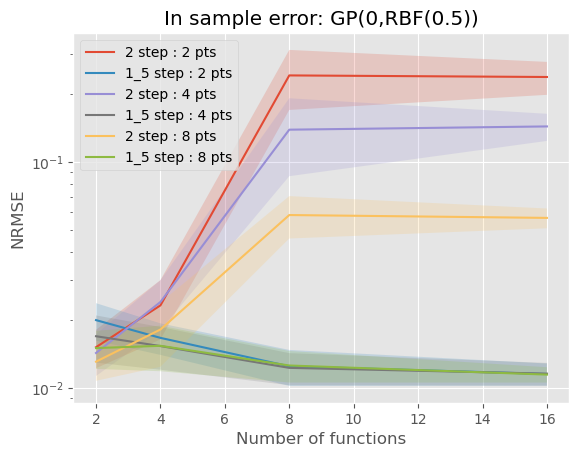

In [10]:
# In sample plot
plt.title('In sample error: GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_smpl_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    sd_i_smpl_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # 2 method
    mean_i_smpl_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    sd_i_smpl_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # Plot 2 method
    plt.plot(ms, mean_i_smpl_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_smpl_2 - sd_i_smpl_2, mean_i_smpl_2 + sd_i_smpl_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_i_smpl_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_smpl_1_5 - sd_i_smpl_1_5, mean_i_smpl_1_5 + sd_i_smpl_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

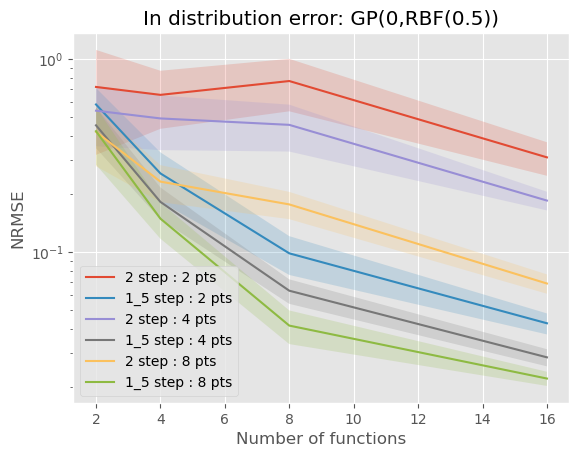

In [11]:
# In distribution plot
plt.title('In distribution error: GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # 2 method
    mean_i_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_i_dis_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_2 - sd_i_dis_2, mean_i_dis_2 + sd_i_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_i_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_1_5 - sd_i_dis_1_5, mean_i_dis_1_5 + sd_i_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

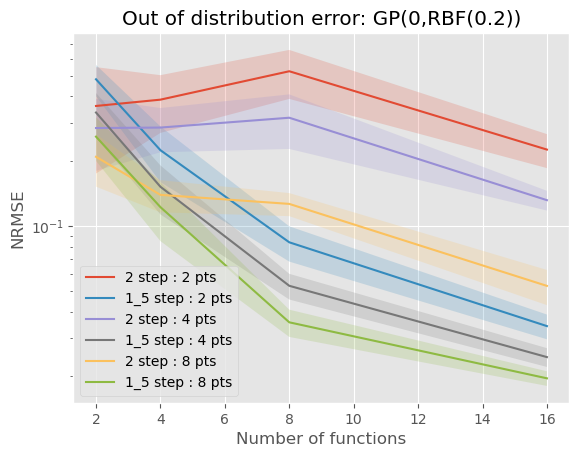

: 

In [12]:
# Out of distribution
plt.title('Out of distribution error: GP(0,RBF(0.2))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_o_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # 2 method
    mean_o_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_o_dis_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_o_dis_2 - sd_o_dis_2, mean_o_dis_2 + sd_o_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_o_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_o_dis_1_5 - sd_o_dis_1_5, mean_o_dis_1_5 + sd_o_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()